In [14]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
#import numdifftools

In [15]:
sga_ids = [9769, 11977, 12892, 14501, 16383, 19235, 19278, 25532, 30149, 31220, 32484, 36904, 37543, 46327, 58617, 73111, 88963, 91660, 90791, 106536, 
           114405, 114489, 122580, 126630, 125611, 128163, 128411, 130766, 149502, 153504, 175220, 176736, 184044, 186239, 189685, 188525, 190308, 
           192158, 196470, 199038, 202236, 205028, 209429, 212382, 218773, 235556, 254532, 272164, 272562, 276638, 288715, 289743, 291766, 300446, 
           302062, 305831, 309378, 319942, 330678, 349027, 349346, 363344, 373692, 378842, 384420, 389177, 393190, 395070, 398443, 398532, 416531, 
           431242, 430161, 432294, 450689, 450566, 455486, 457147, 458798, 462867, 466872, 467582, 471327, 469868, 471893, 473436, 477805, 481956, 
           485800, 493017, 507499, 526710, 544419, 544810, 544799, 544943, 548724, 548848, 550458, 564440, 569298, 568664, 570086, 582248, 591927, 
           607528, 608015, 629144, 630029, 630390, 635043, 638386, 641578, 643231, 643845, 644940, 647966, 649753, 649960, 651096, 654469, 659599, 
           663463, 671301, 671533, 694525, 696291, 696345, 706579, 720480, 722142, 726854, 728327, 729726, 729754, 736449, 742167, 743030, 744650, 
           752683, 757313, 757166, 758123, 759261, 759003, 766672, 783693, 793633, 804643, 805225, 819754, 820598, 823301, 824225, 826809, 827949, 
           833961, 833981, 843065, 843126, 845052, 887433, 901663, 901980, 908818, 908978, 911046, 914975, 914909, 916161, 920806, 923400, 925923, 
           925354, 928810, 928876, 932984, 947709, 953644, 957521, 957850, 967351, 968864, 971635, 975775, 972260, 977015, 976853, 979168, 978708, 
           989040, 989244, 1001302, 1003319, 1008726, 1014959, 1018187, 1021462, 1026141, 1031898, 1033651, 1033344, 1050173, 1065602, 1073430, 
           1086934, 1087039, 1087374, 1090772, 1091806, 1096564, 1098043, 1103477, 1111824, 1117018, 1124386, 1143335, 1146354, 1161160, 1167691, 
           1171841, 1179377, 1184894, 1184912, 1186034, 1187240, 1188032, 1188617, 1188926, 1193015, 1191665, 1194588, 1194958, 1199020, 1199539, 
           1201319, 1203786, 1204237, 1206707, 1218166, 1219319, 1254154, 1264056, 1264591, 1267967, 1271477, 1271549, 1272700, 1273605, 1278144, 
           1281619, 1282407, 1285273, 1286710, 1289613, 1293967, 1301768, 1304908, 1335916, 1338866, 1345100, 1348956, 1349555, 1354266, 1355575, 
           1361363, 1361399, 1365519, 1365549, 1367137, 1368018, 1368443, 1374964, 1379143, 1405053, 1429680, 1434487]

In [16]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/rotcurves/'

# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs in rot curve galaxies
tf_galaxies = np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1])
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID'][tf_mastertable['ROT_CURVE']==1]):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]

# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

In [17]:
tf_mastertable['ROTCURVE_CHI2']=np.nan
tf_mastertable['VMAX']=np.nan
tf_mastertable['VMAX_ERR']=np.nan
tf_mastertable['RTURN']=np.nan
tf_mastertable['RTURN_ERR']=np.nan
tf_mastertable['ALPHA']=np.nan
tf_mastertable['ALPHA_ERR']=np.nan
tf_mastertable['INCLINATION']=np.nan

In [18]:
def inclination_angle(axis_ratio):
    '''
    Calculate Inclination Angle
    Parameters
    ----------
    axis_ratio : float
        Axis ratio for galaxy.
        
    Returns
    -------
    Inclination angle in Radians
    '''
    cos_i2 = (axis_ratio ** 2 - 0.2 ** 2)/(1 - 0.2 ** 2)
    if cos_i2 < 0:
        cos_i2 = 0.001
    inclination = np.arccos(cos_i2 ** 0.5)
    return inclination

In [19]:
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [20]:
def chi_2(params, v, v_err, r):
    '''
    Calculate Chi Squared 
    Parameters
    ----------
    params : list
        v_max, r_turn, alpha.
    v : float
        Absolute value of velocity.
    v_err : float
        Uncertainty for velocity.
    r : 
        Target distance.
    Returns
    -------
    Chi Squared value
    '''
    v_max, r_turn, alpha = params
    v_model = v_rot(r, v_max, r_turn, alpha)
    chi_sq = np.sum((v_model - v)**2/(v_err**2))
    return chi_sq

/tmp/ipykernel_845310/1769431299.py:18: RuntimeWarning: overflow encountered in power
  vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))


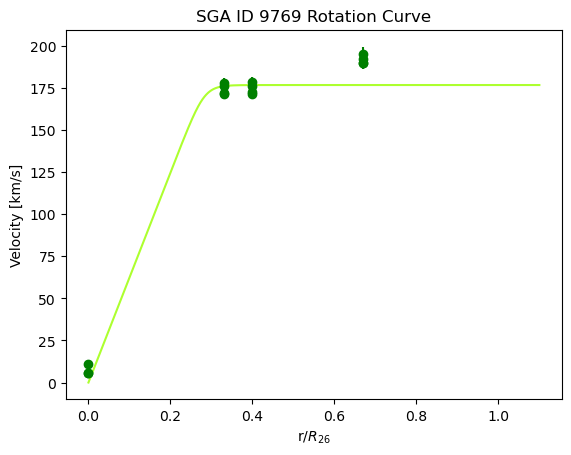

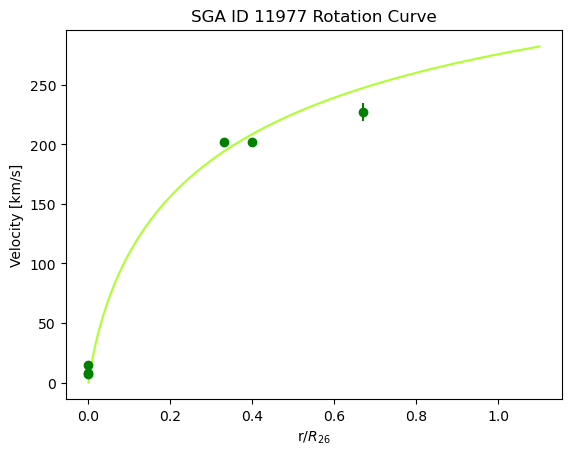

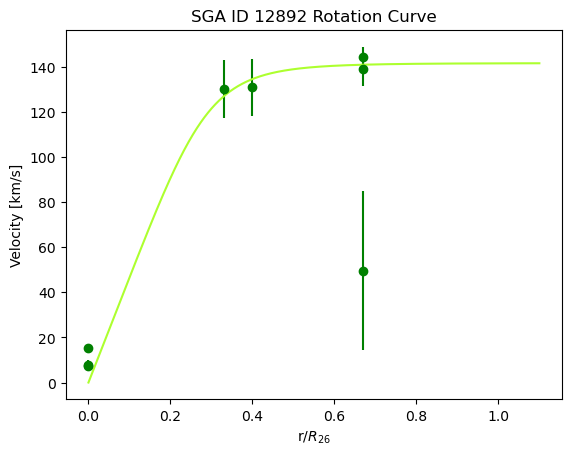

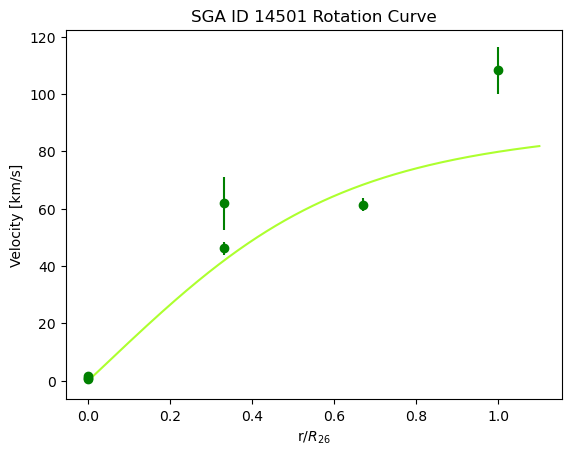

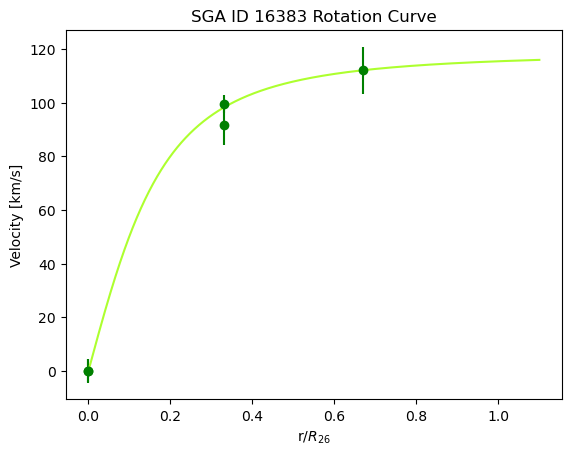

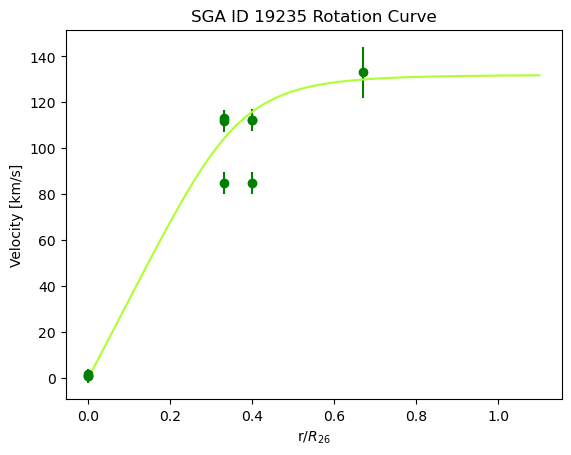

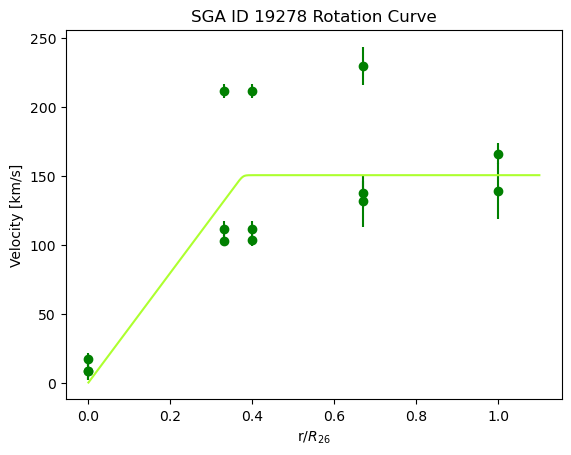

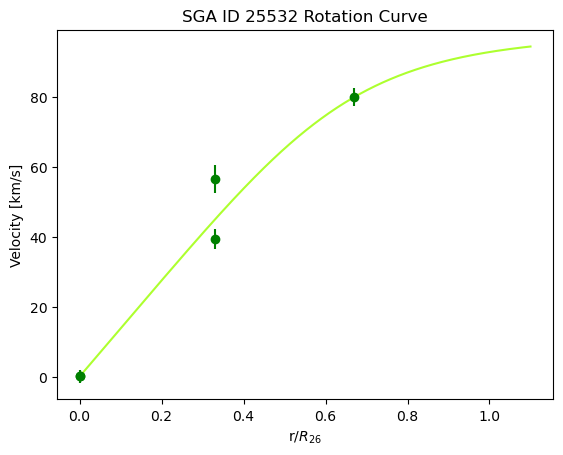

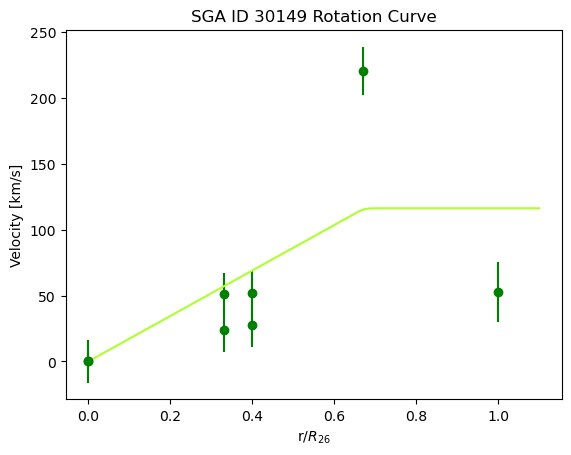

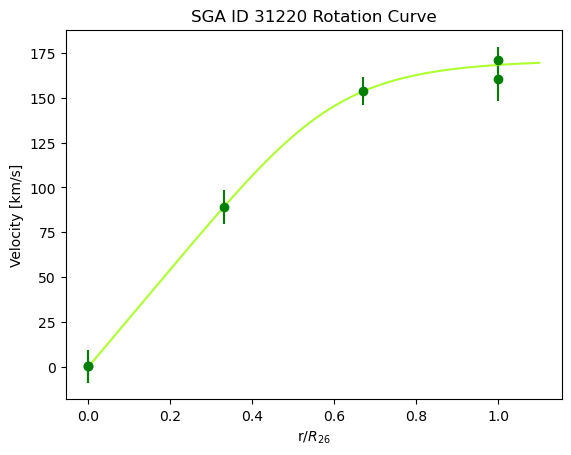

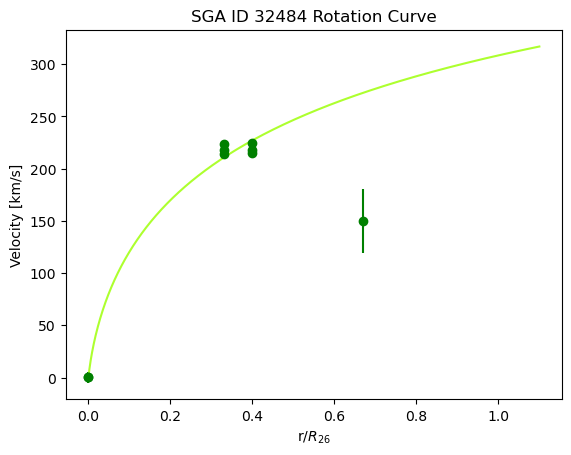

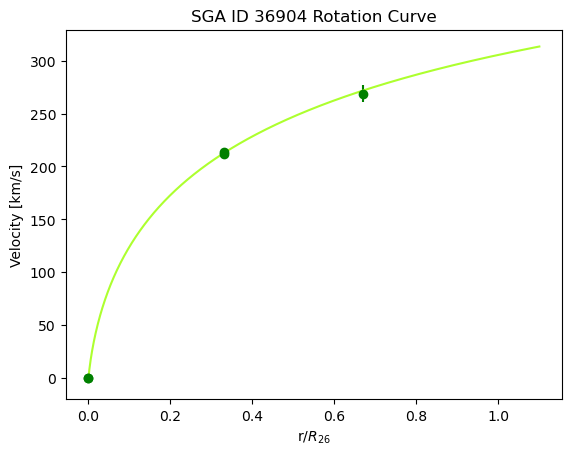

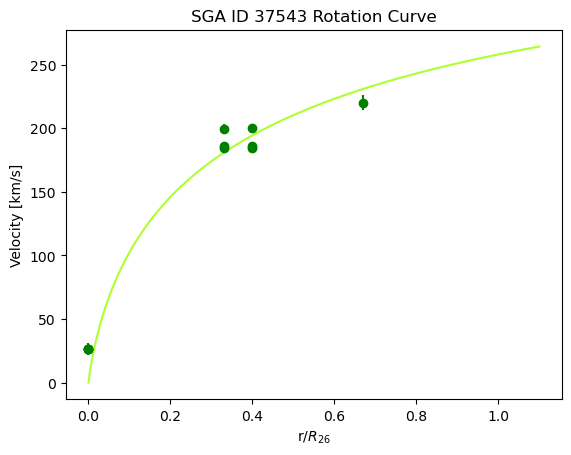

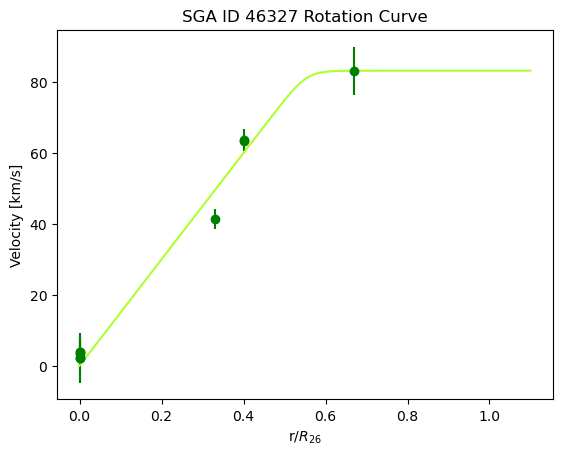

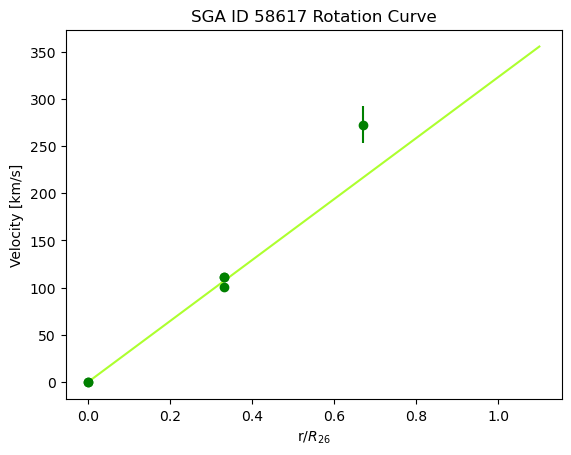

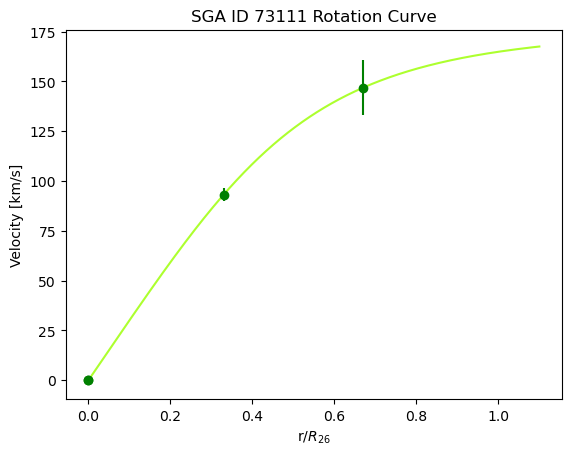

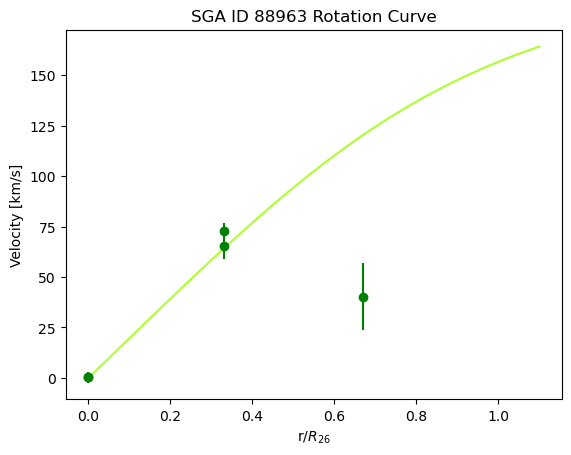

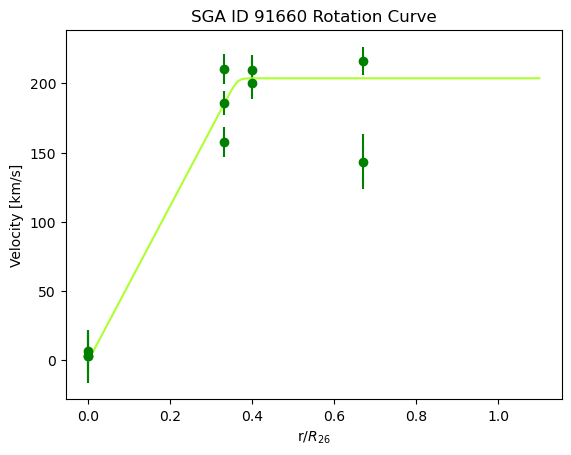

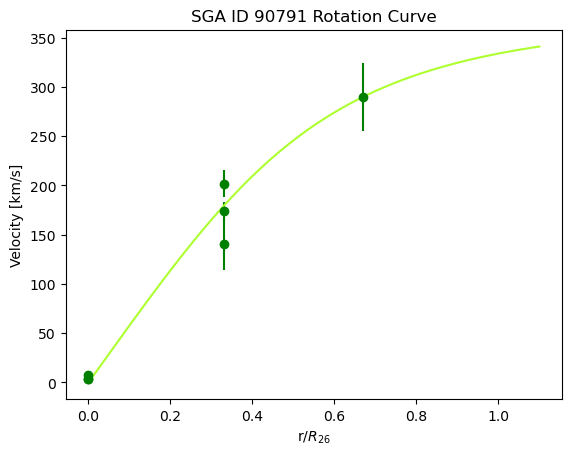

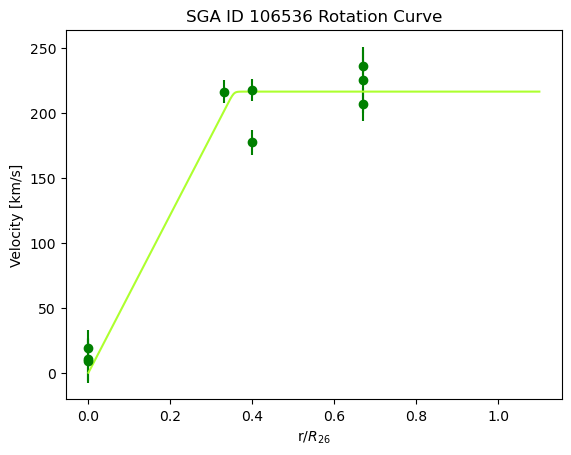

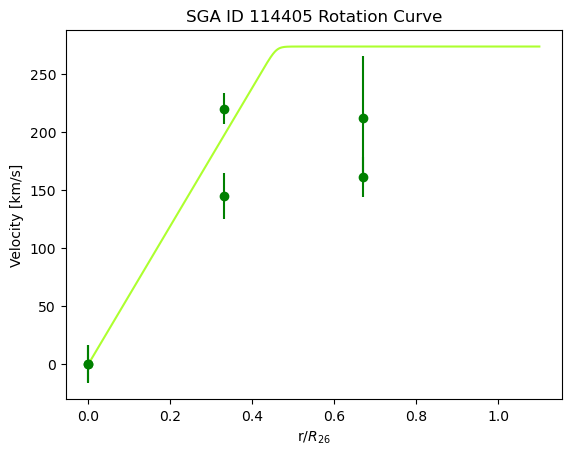

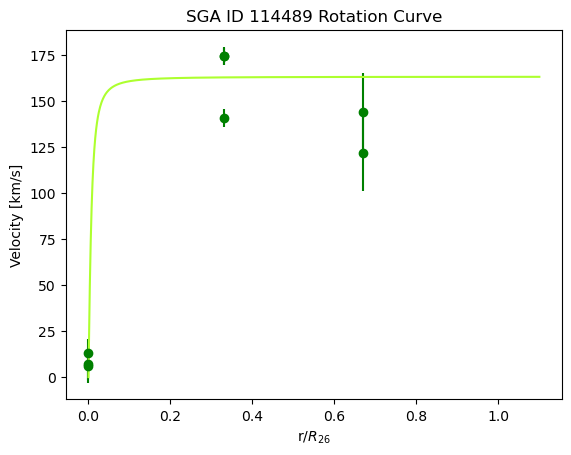

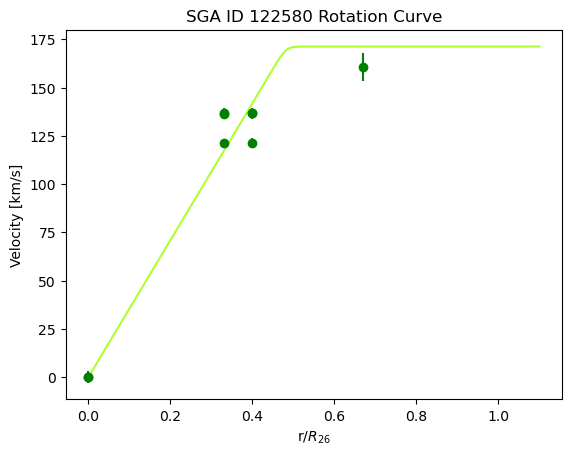

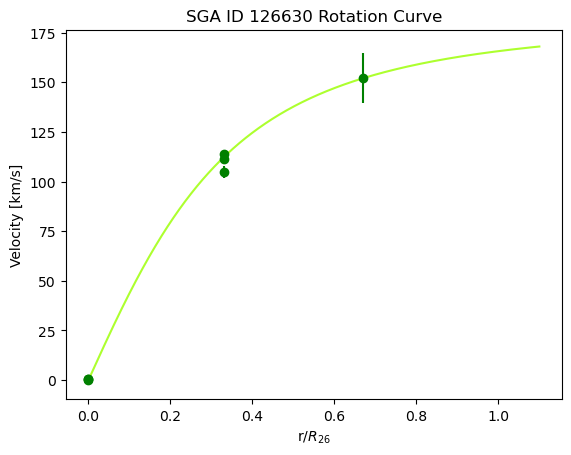

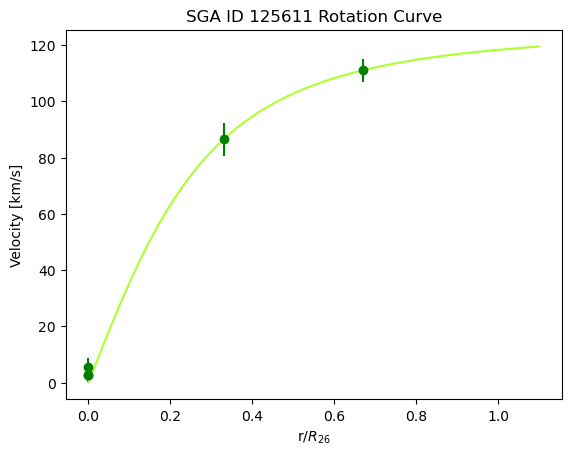

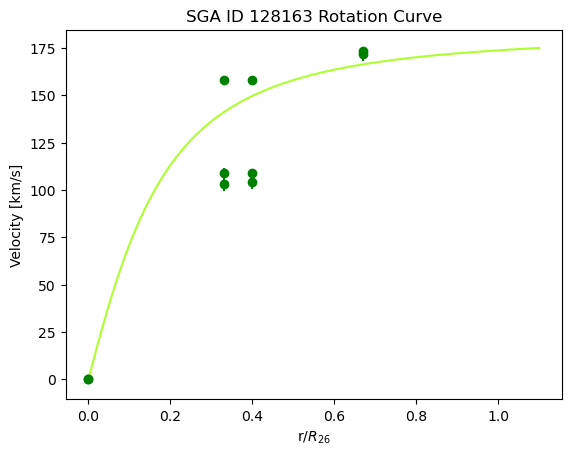

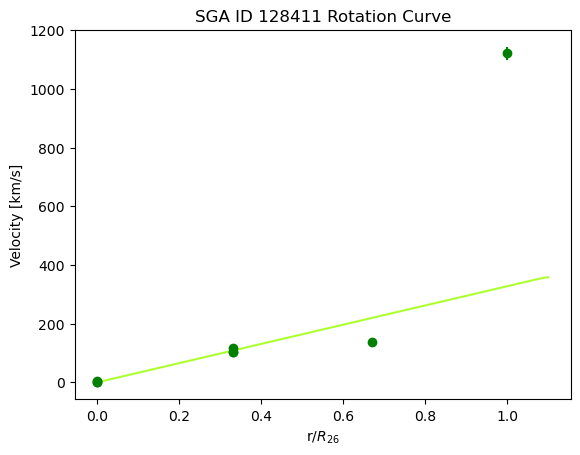

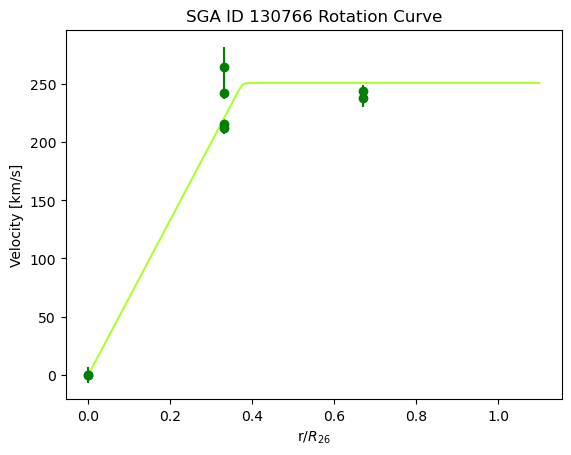

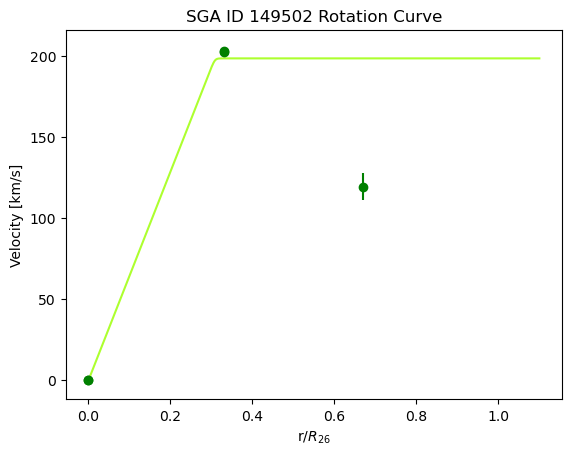

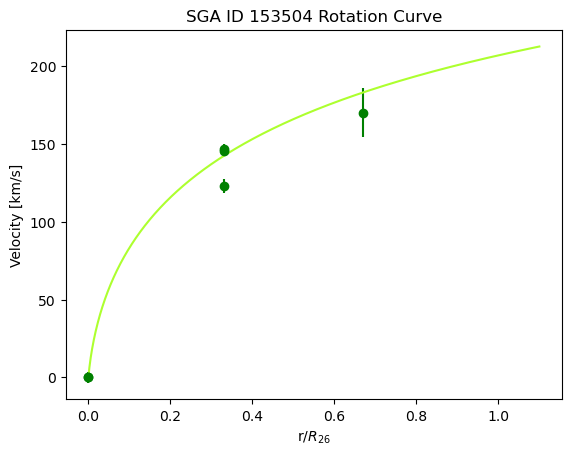

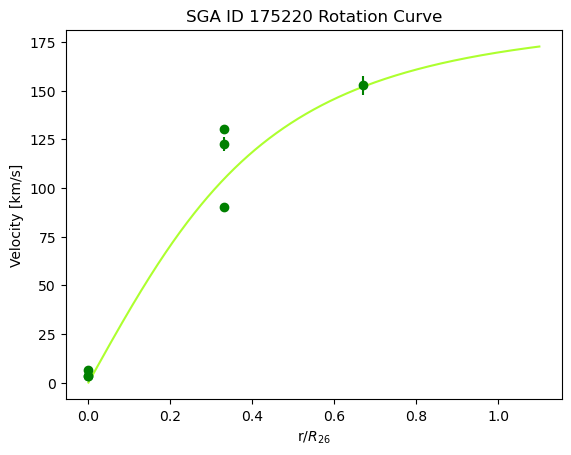

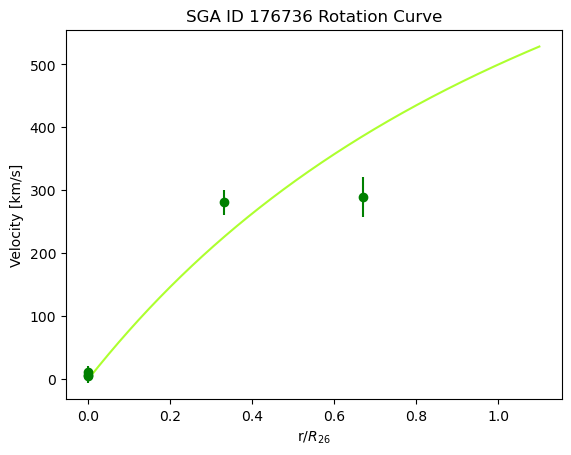

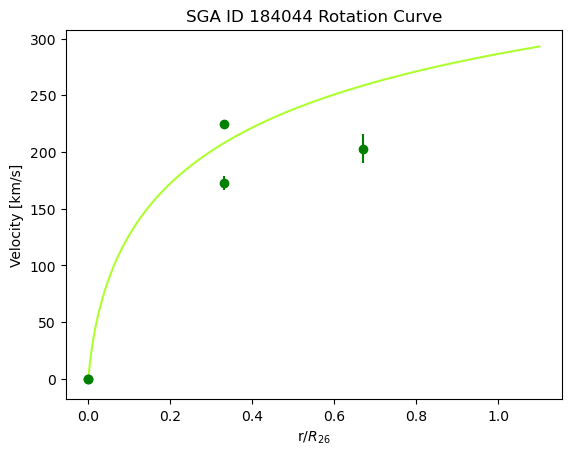

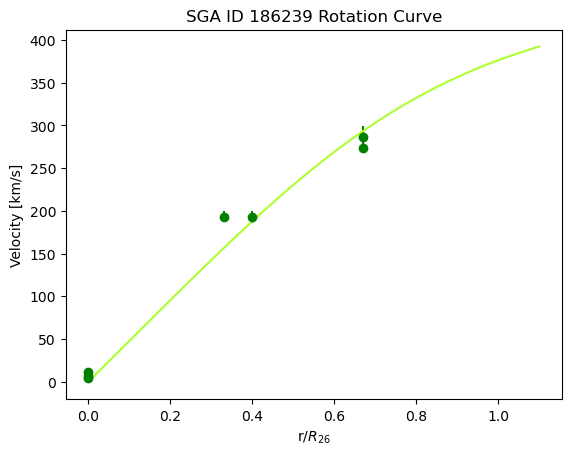

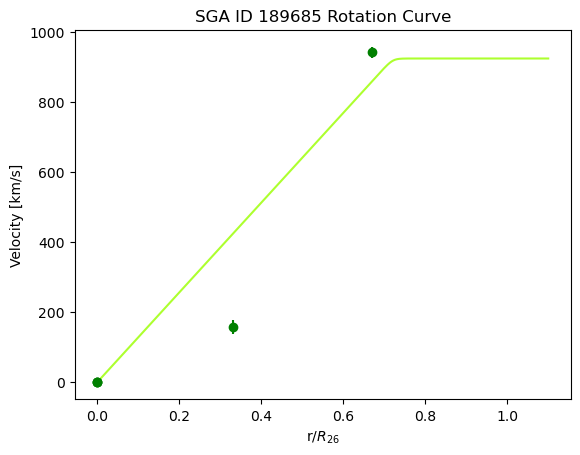

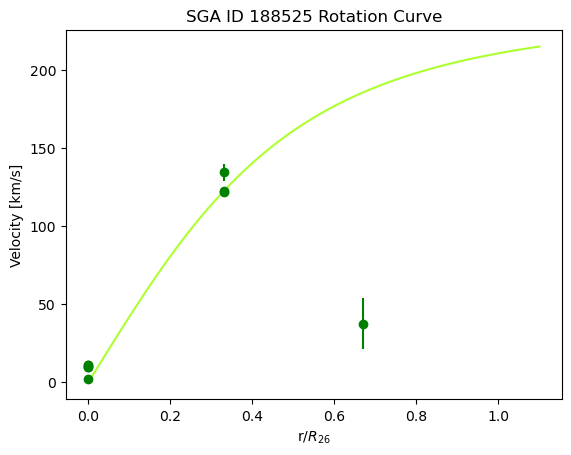

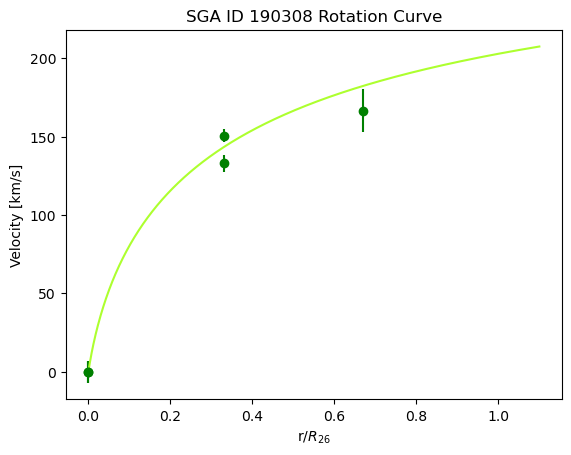

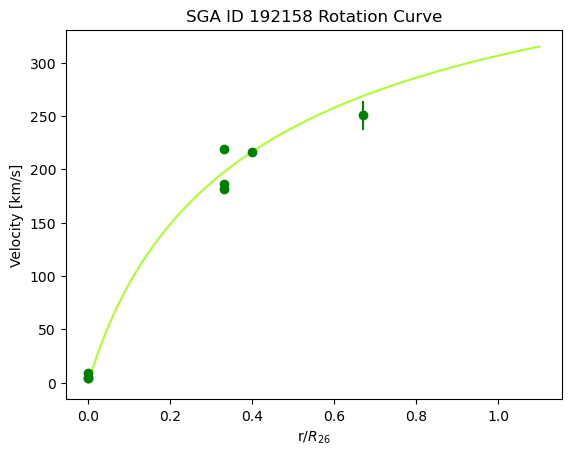

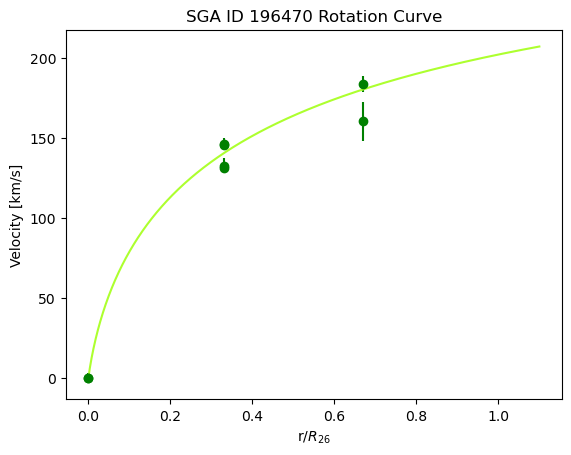

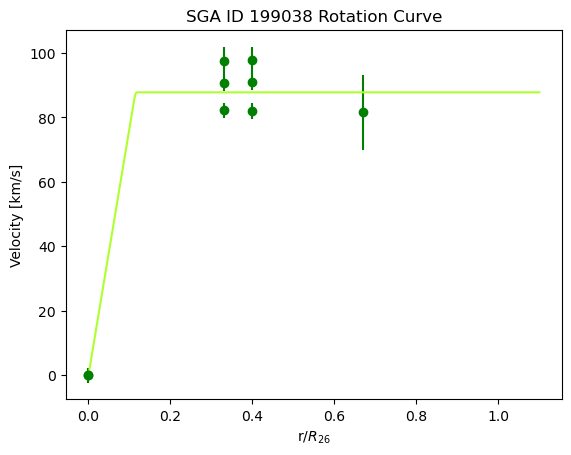

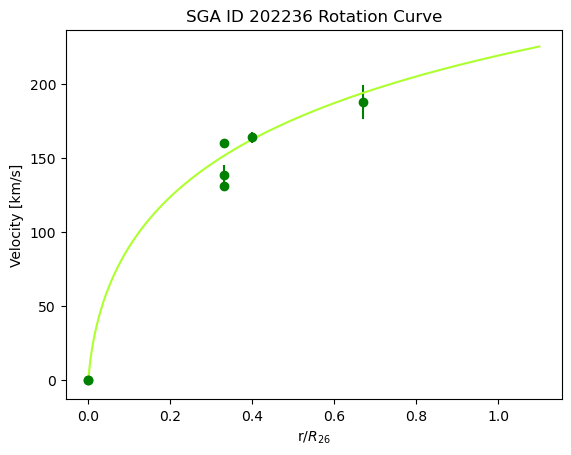

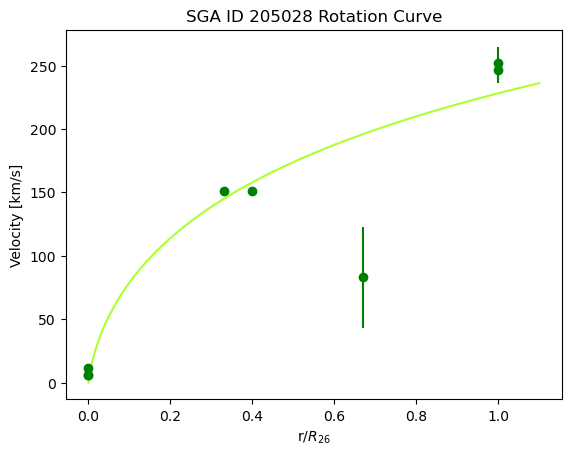

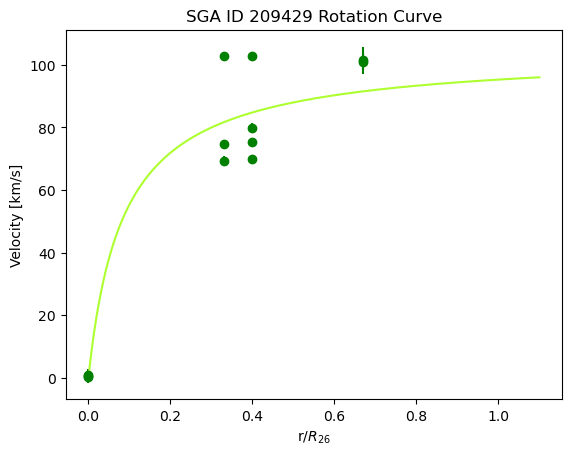

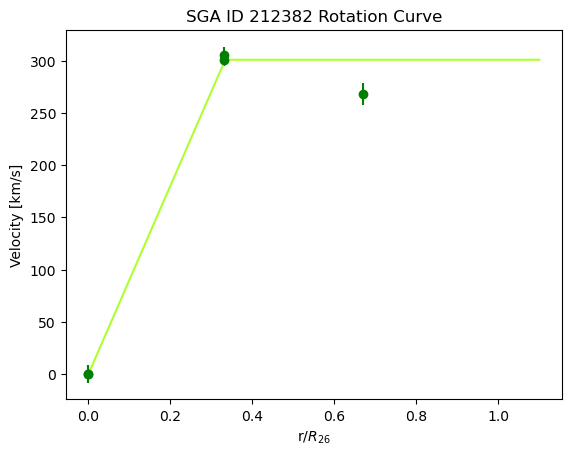

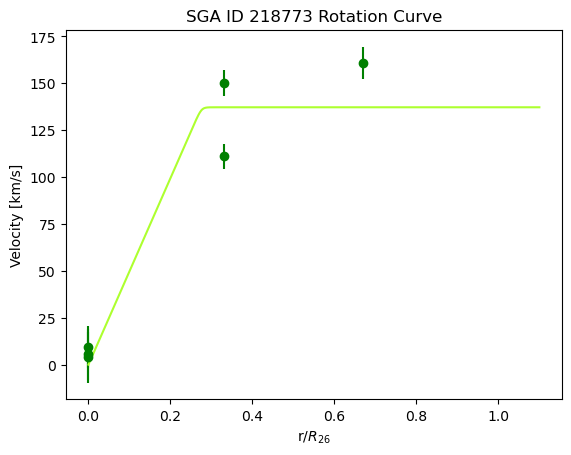

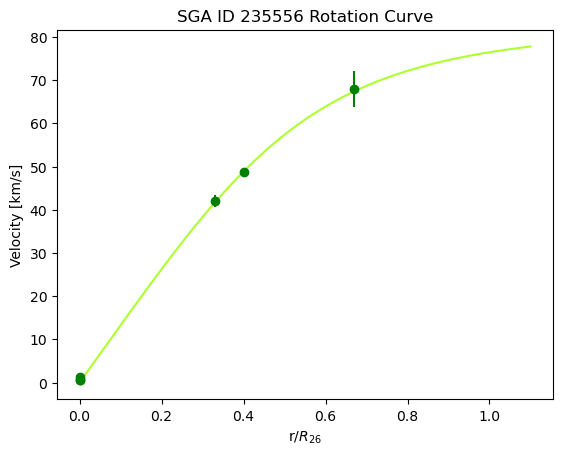

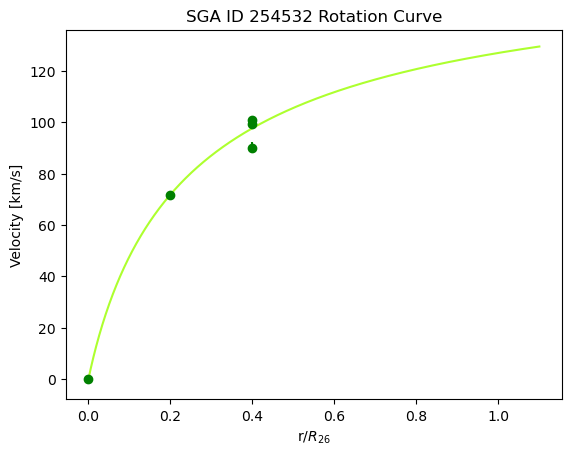

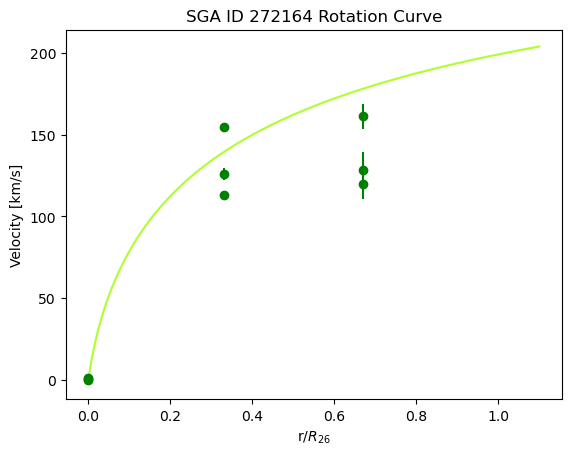

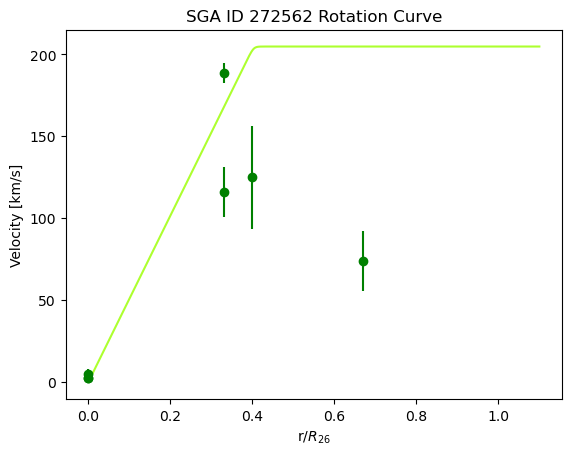

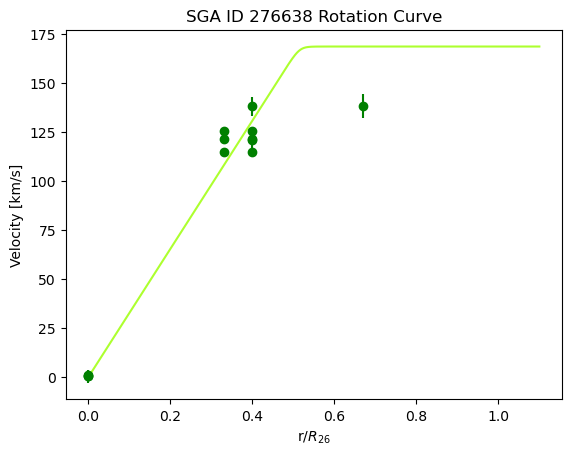

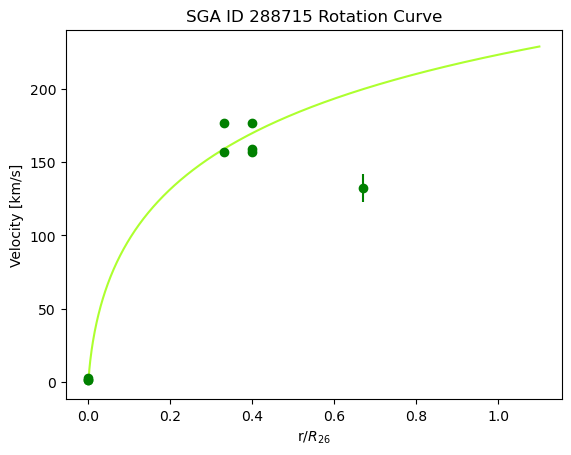

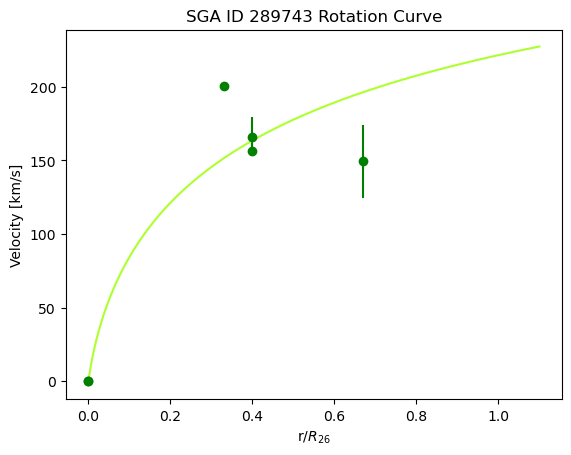

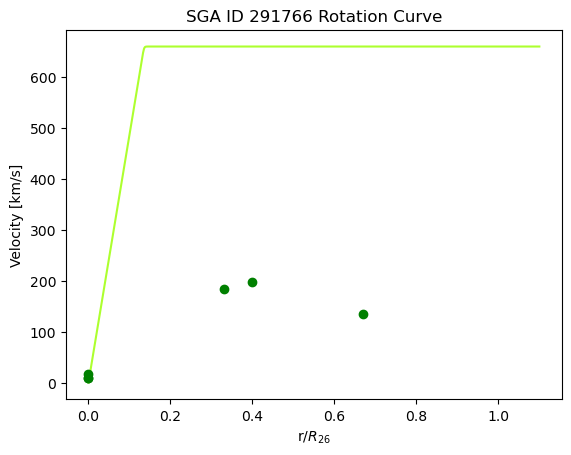

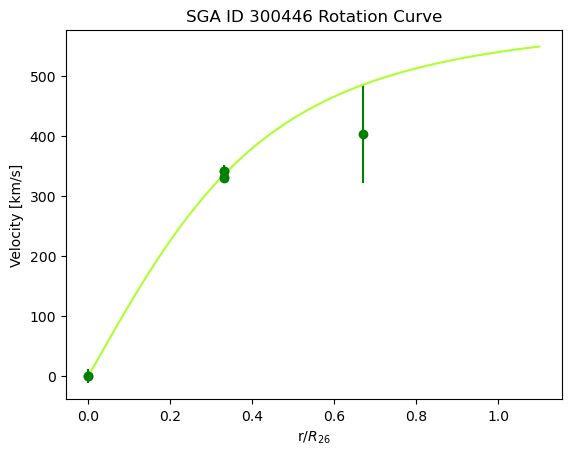

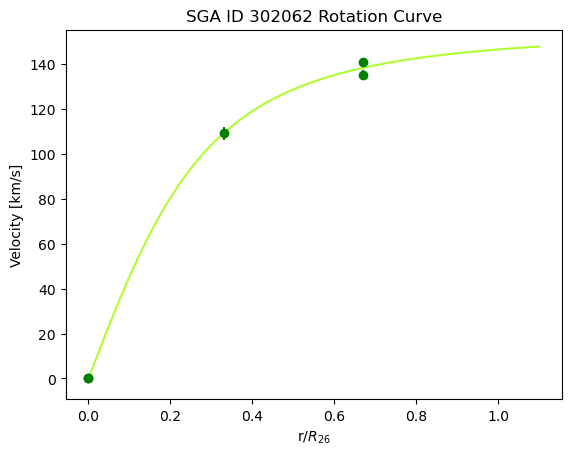

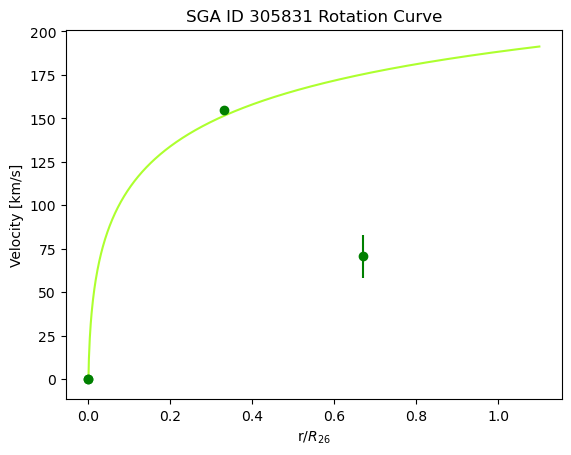

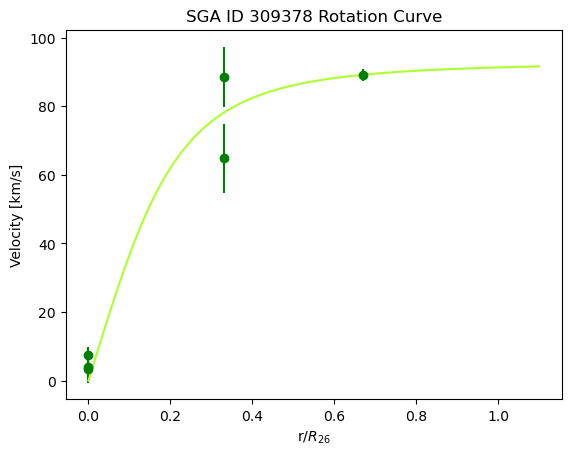

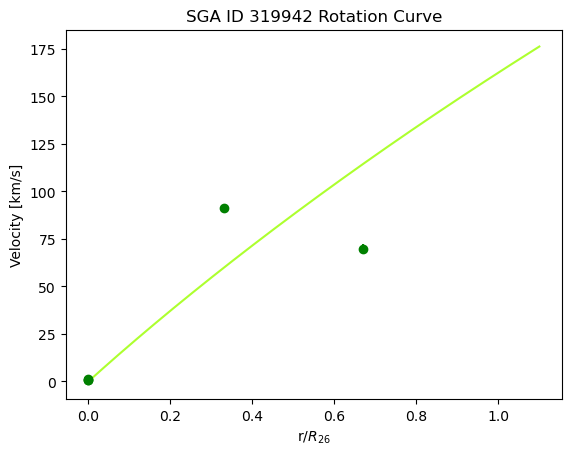

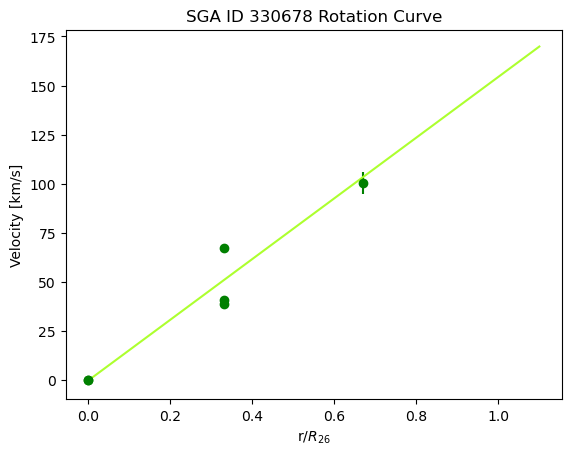

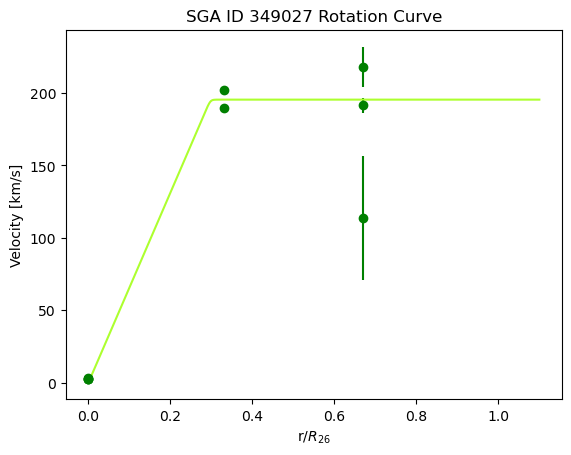

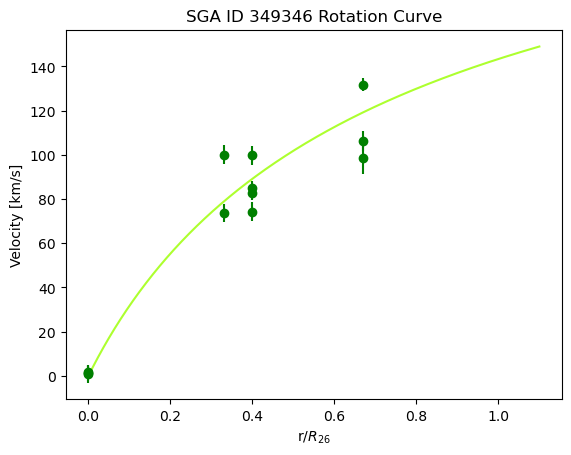

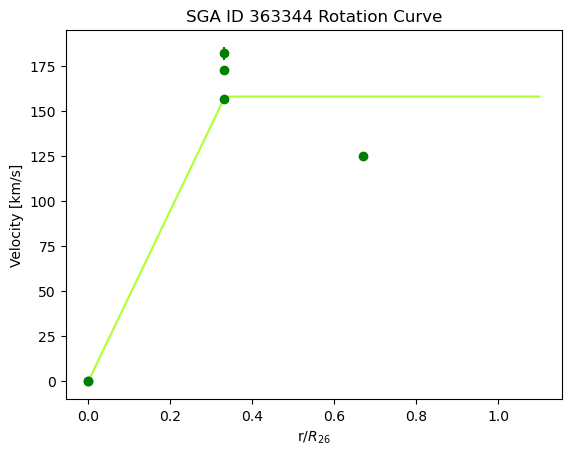

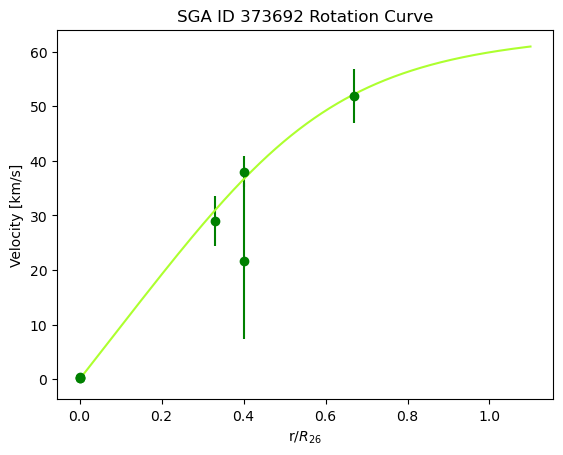

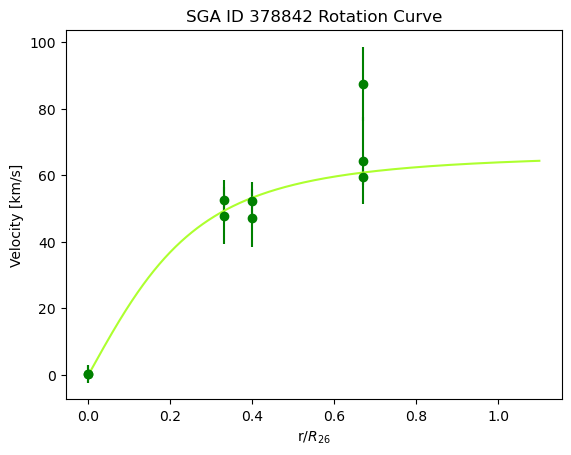

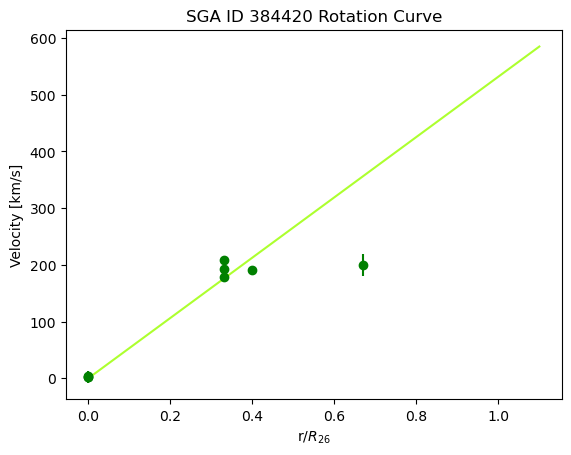

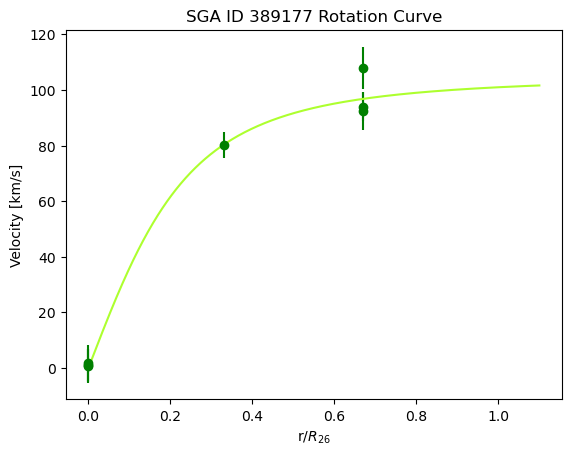

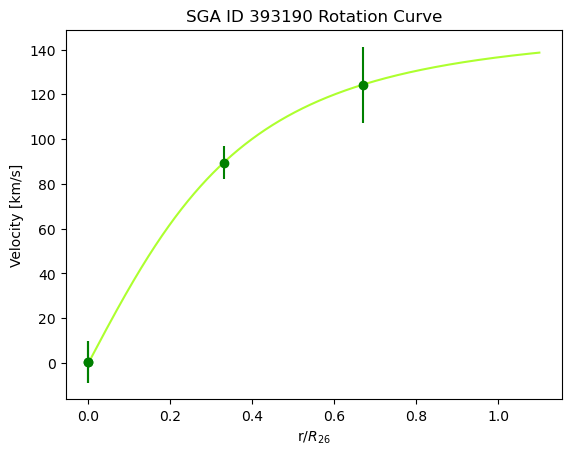

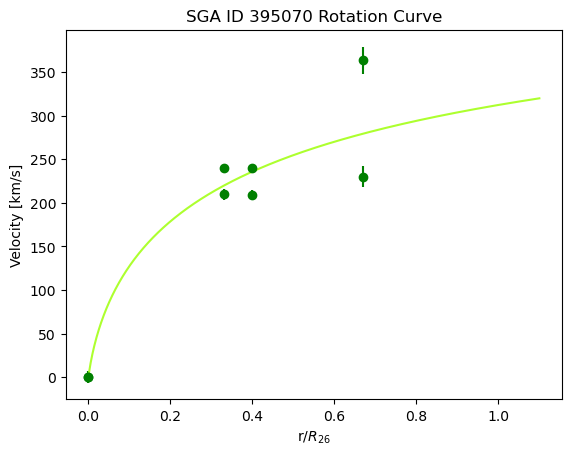

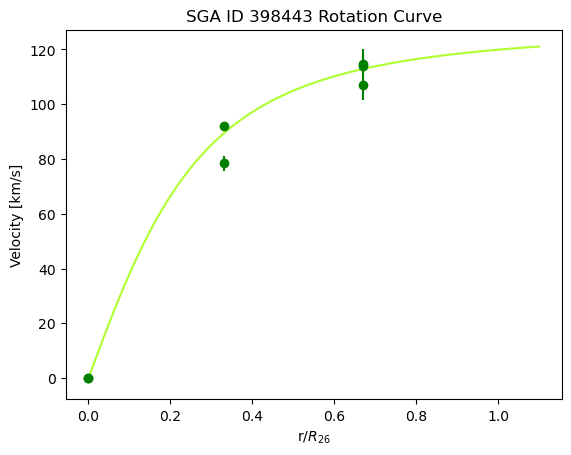

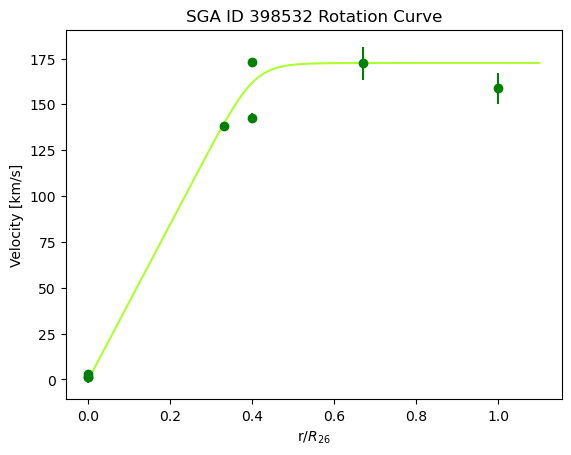

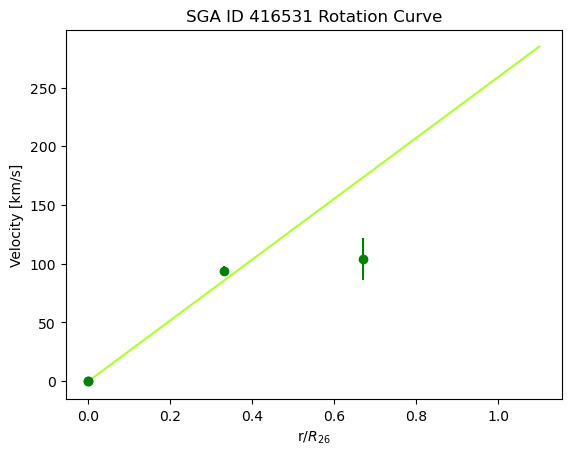

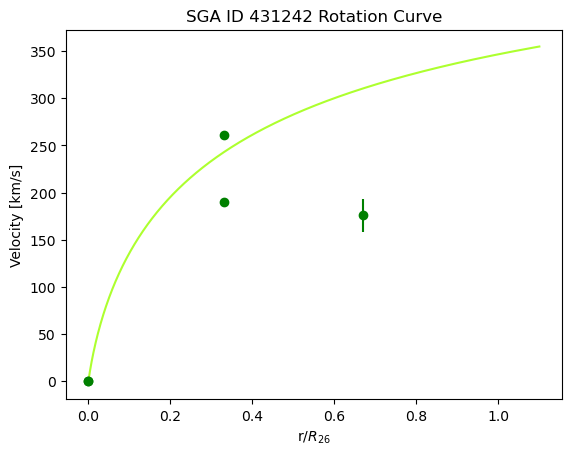

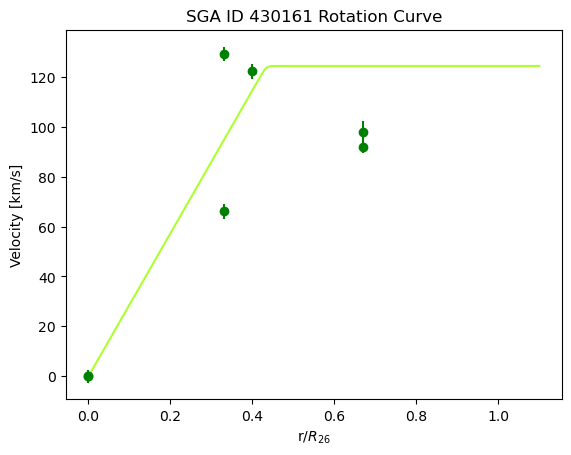

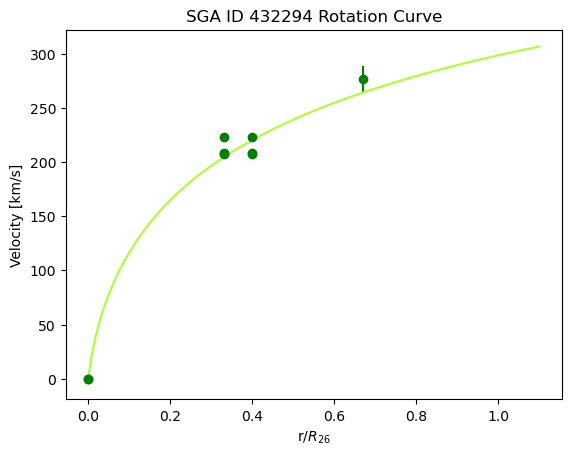

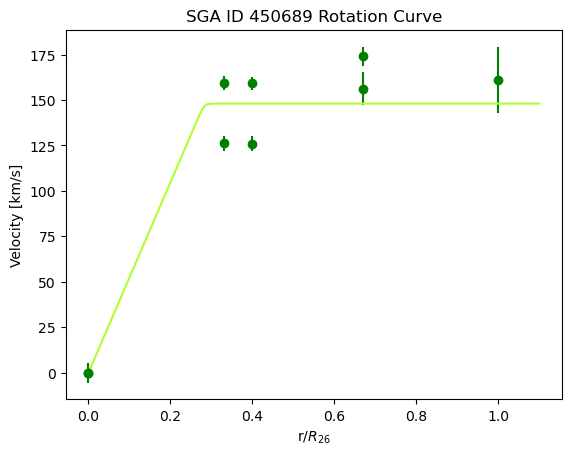

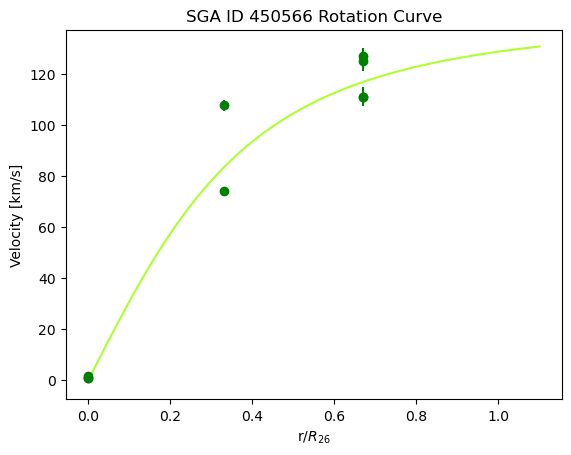

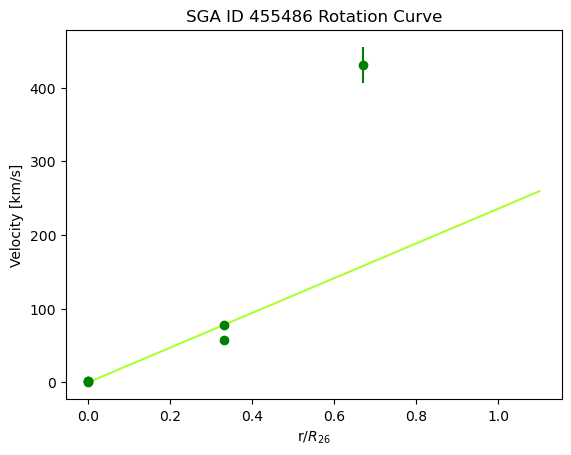

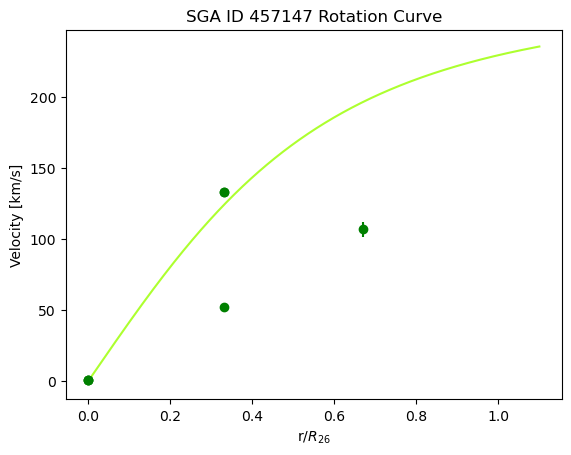

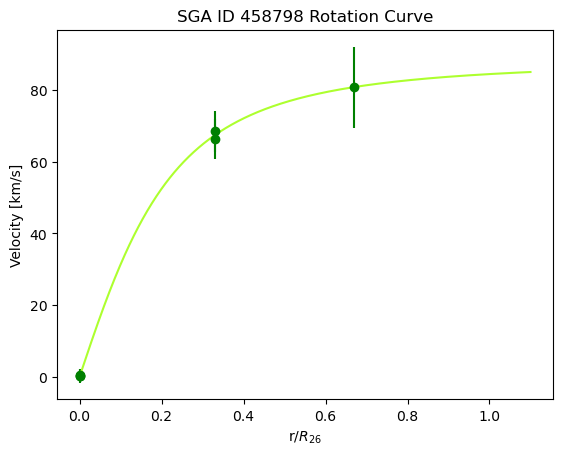

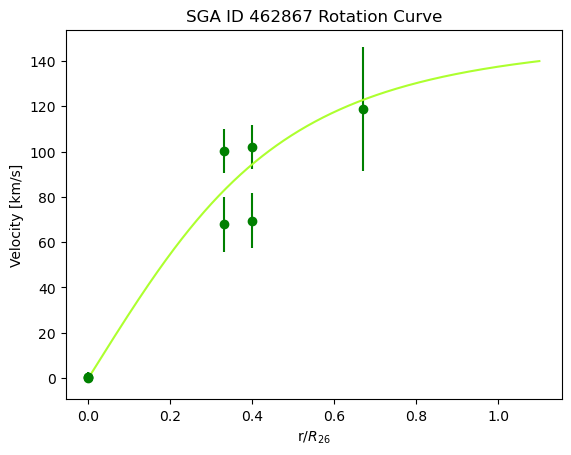

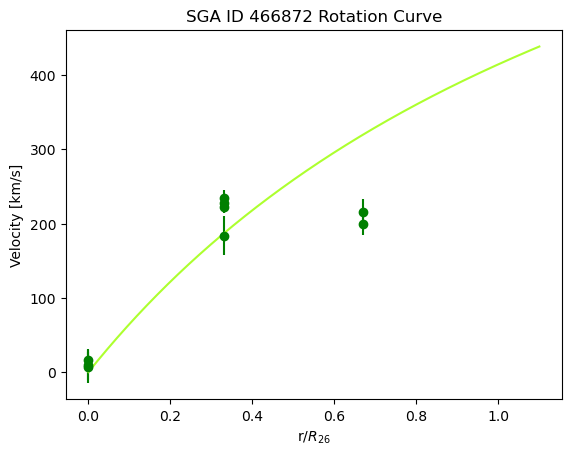

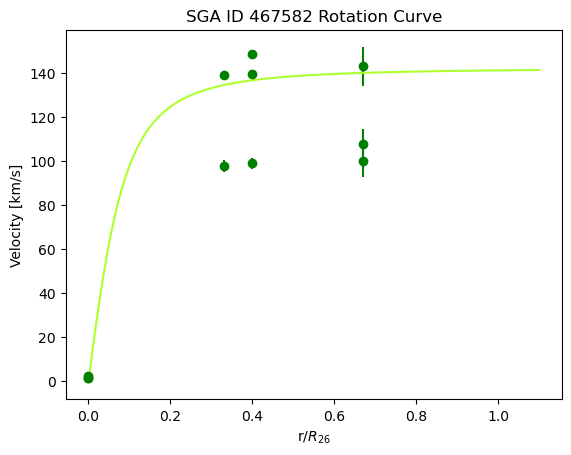

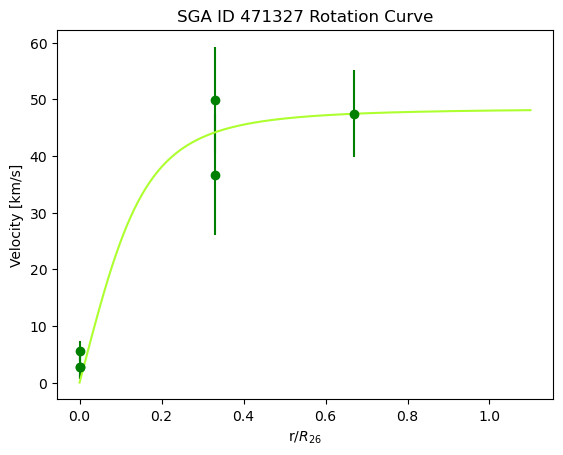

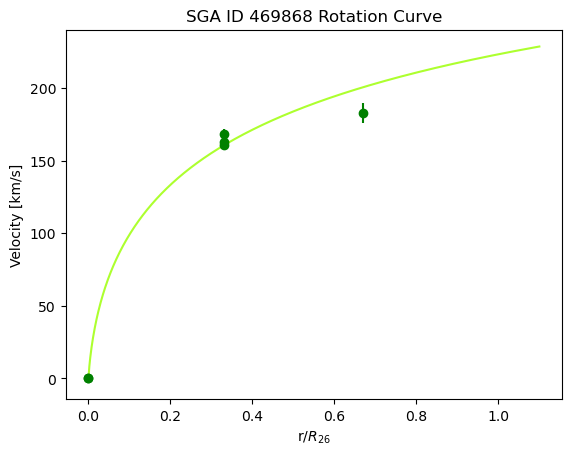

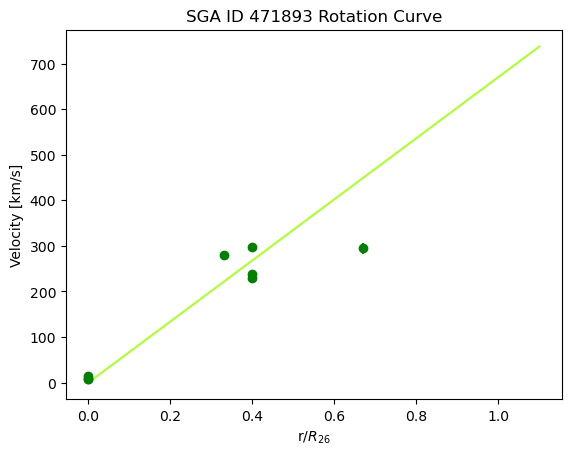

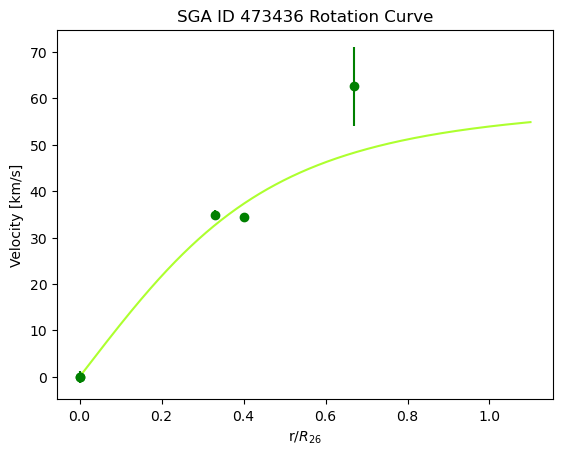

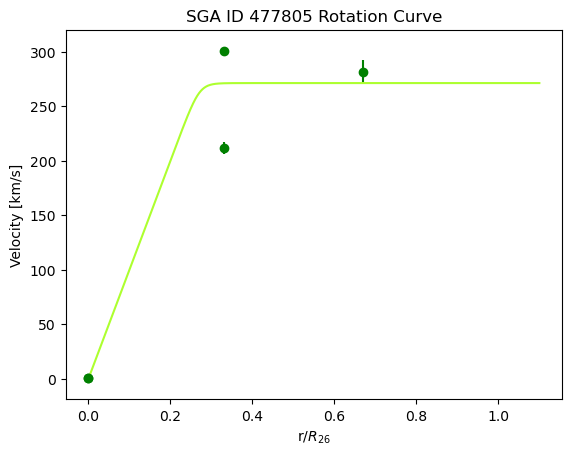

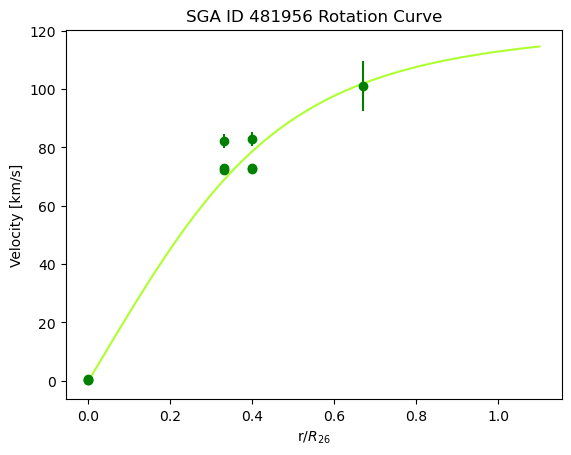

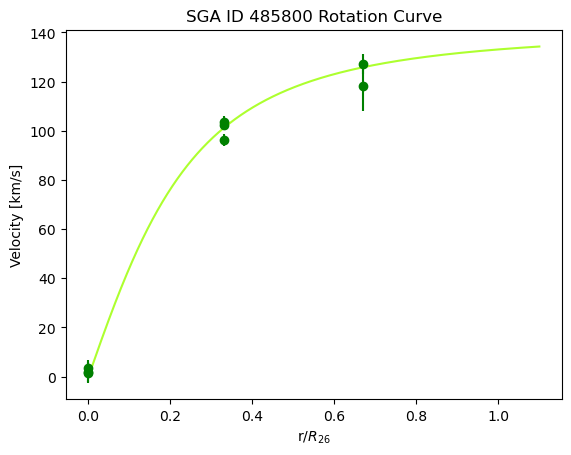

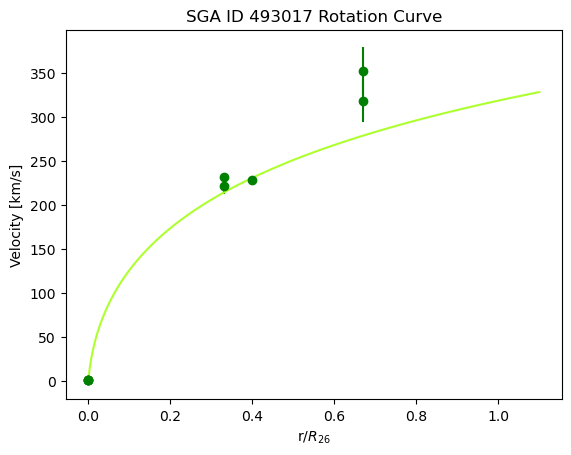

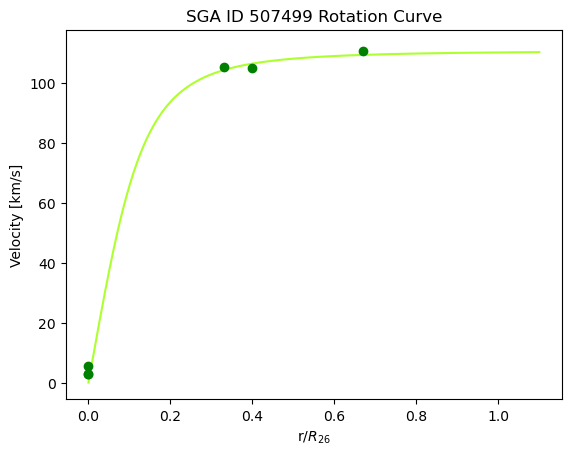

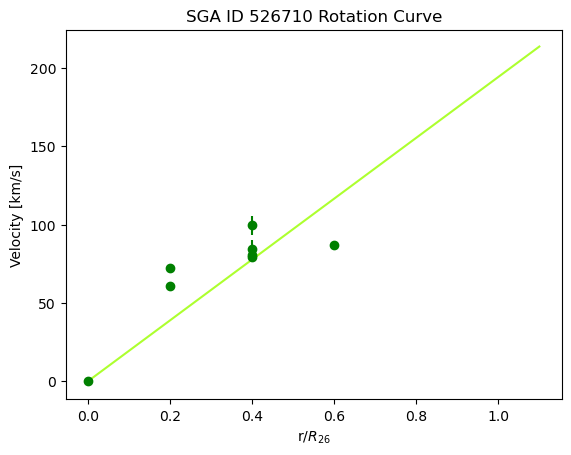

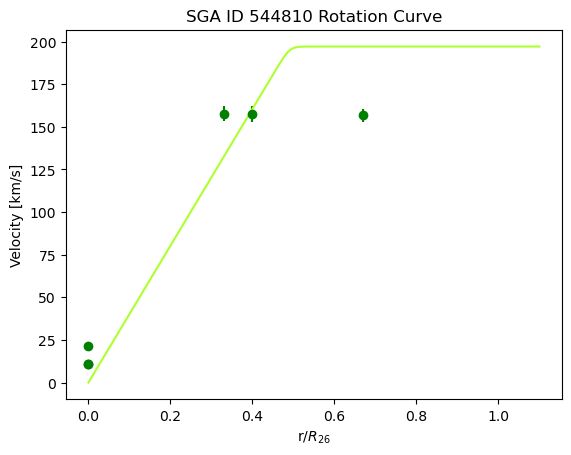

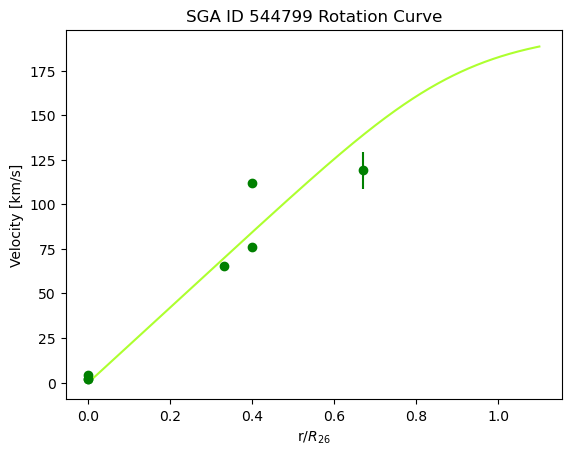

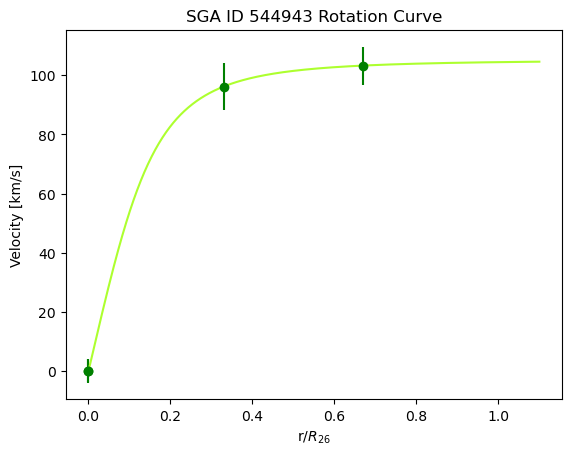

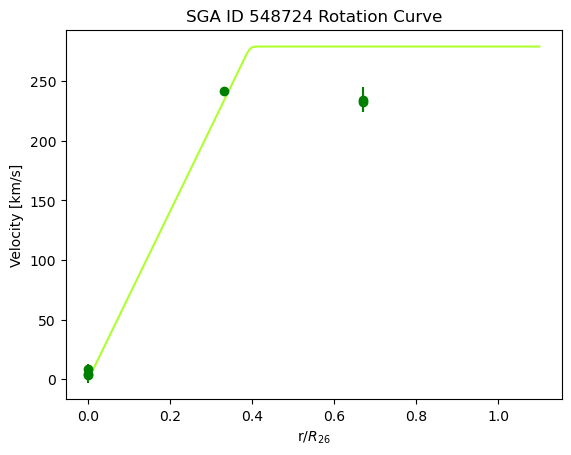

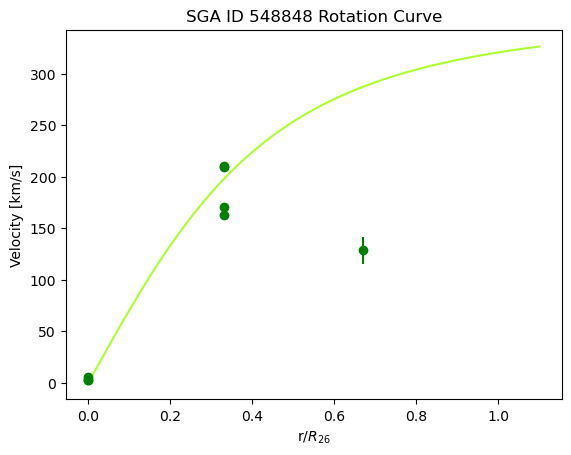

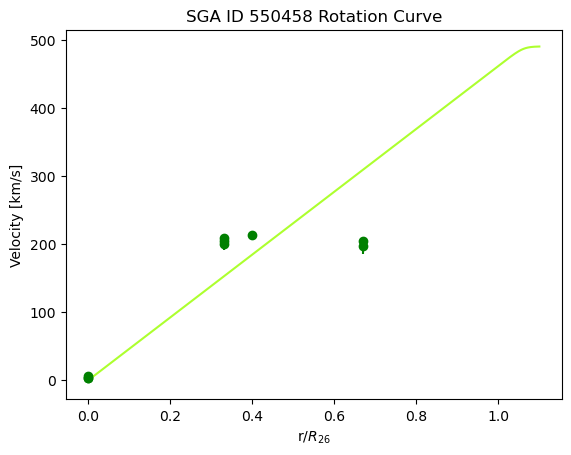

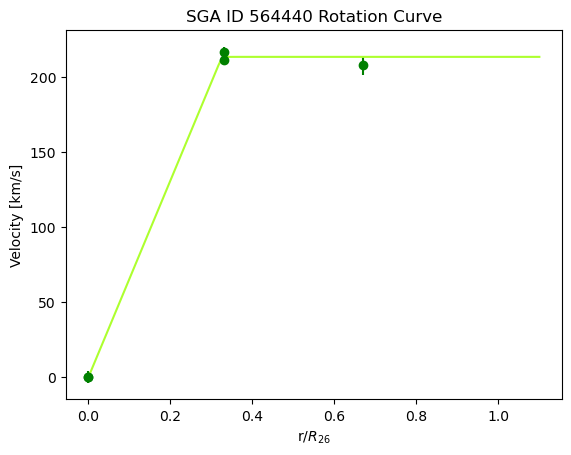

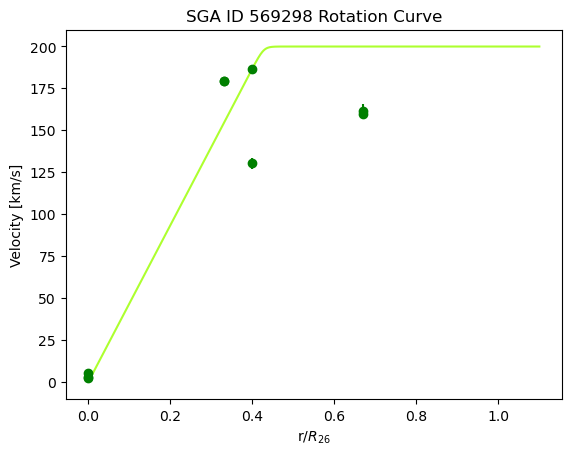

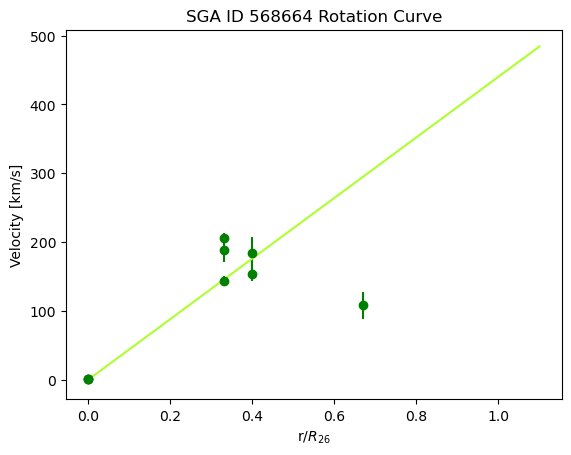

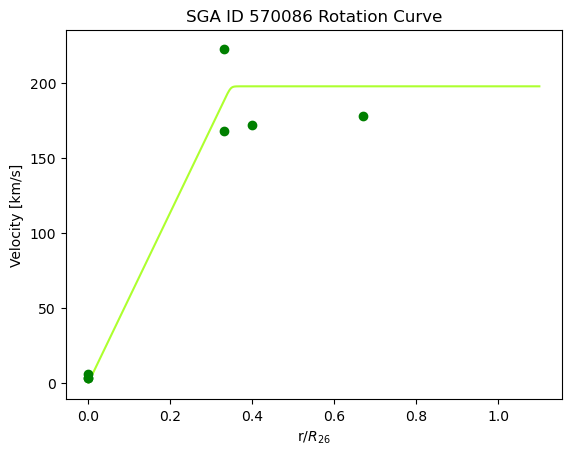

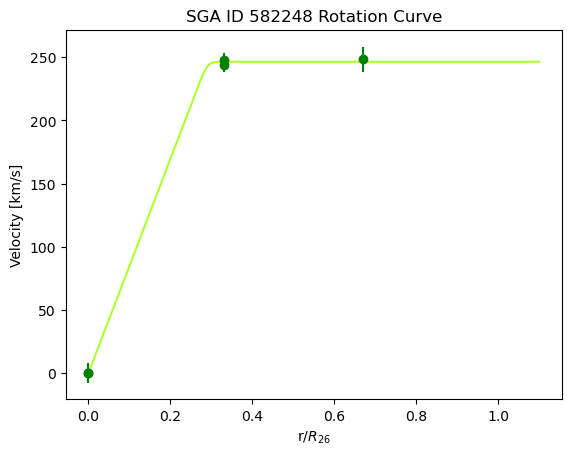

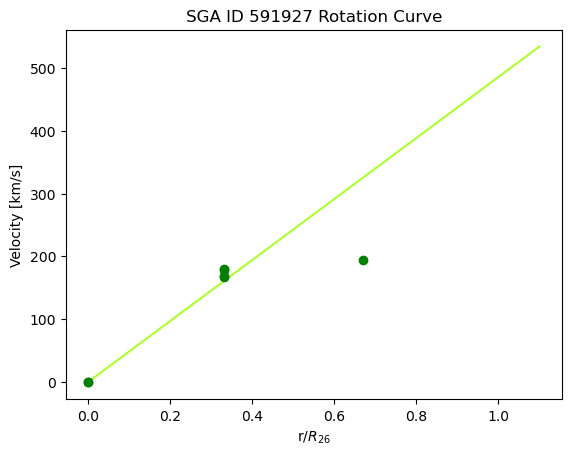

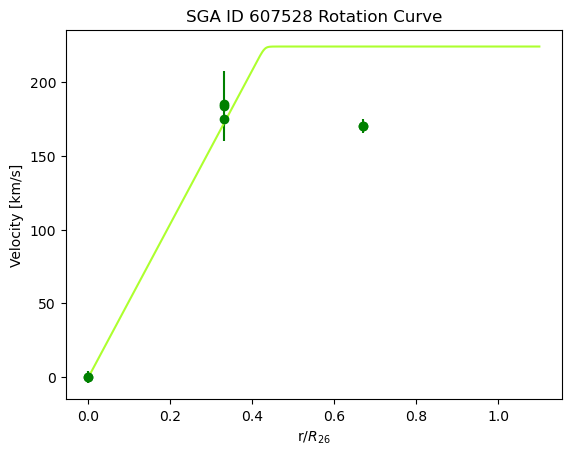

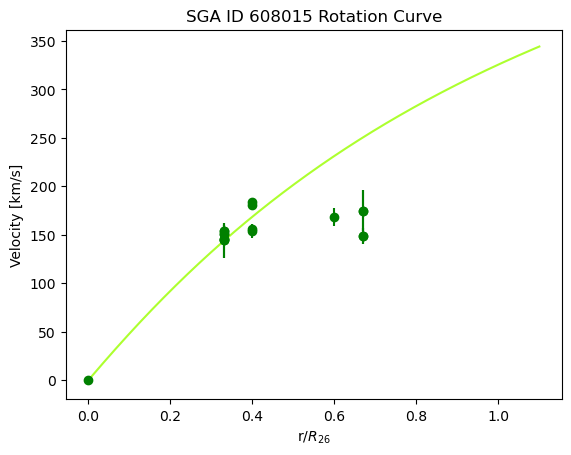

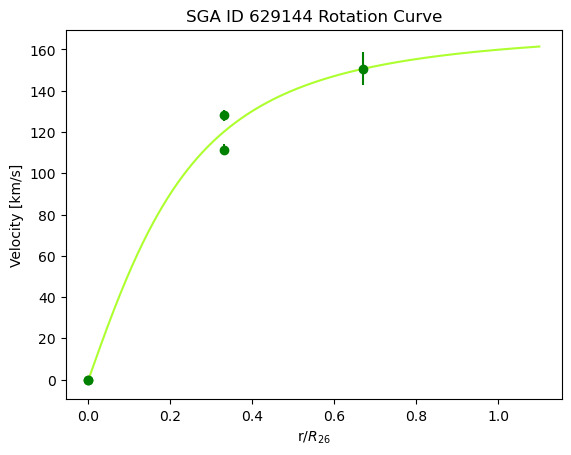

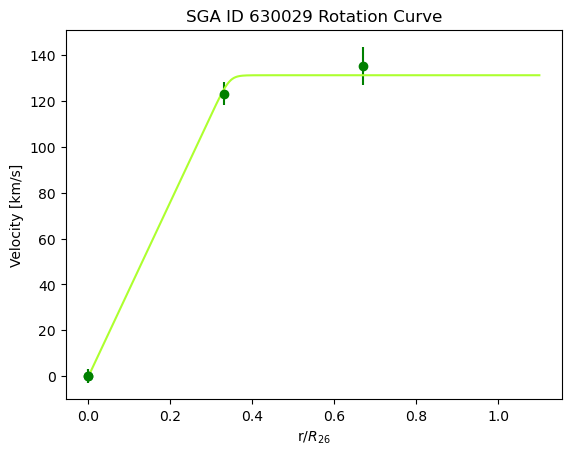

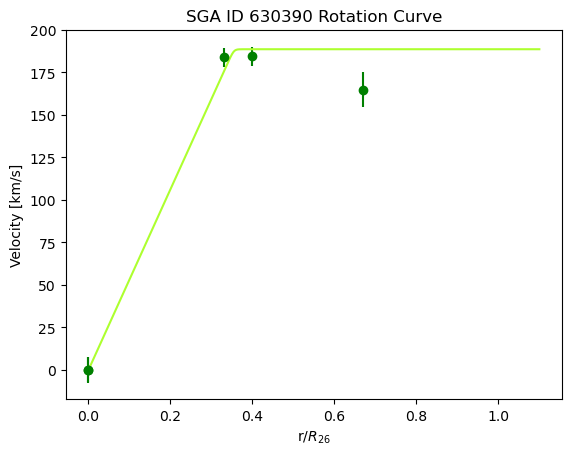

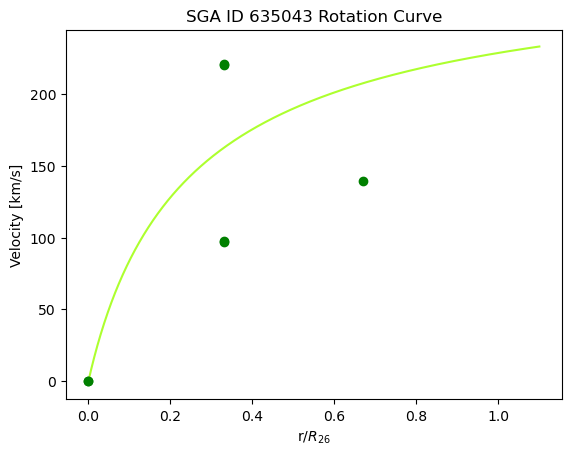

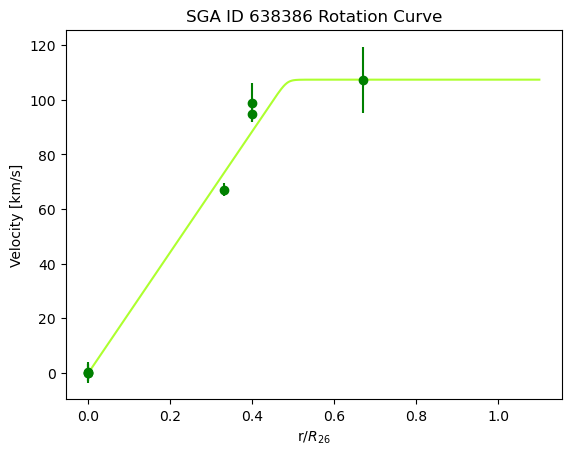

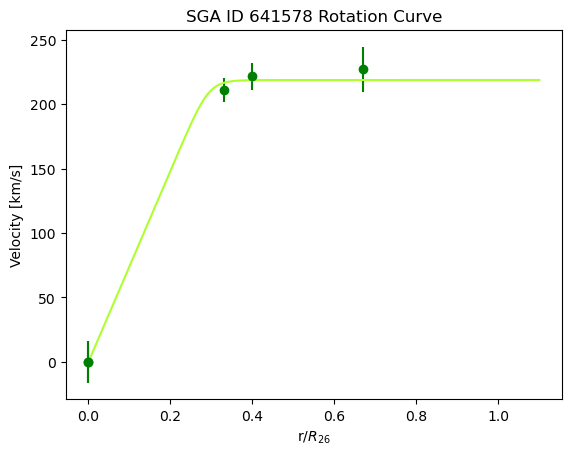

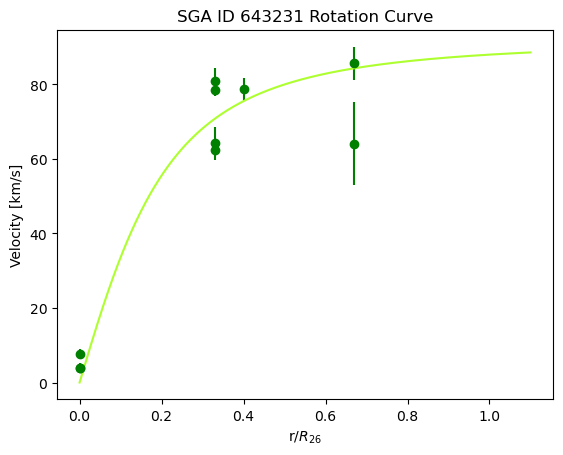

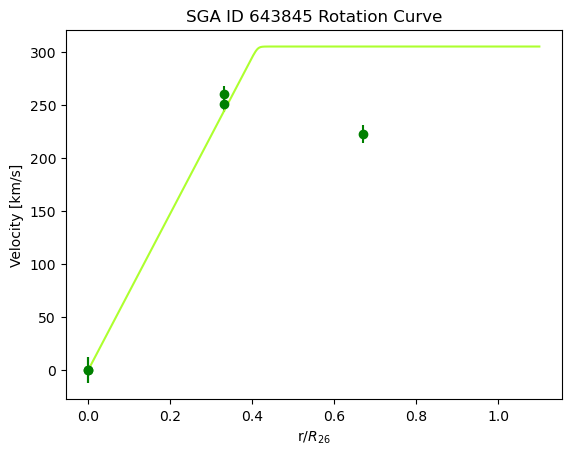

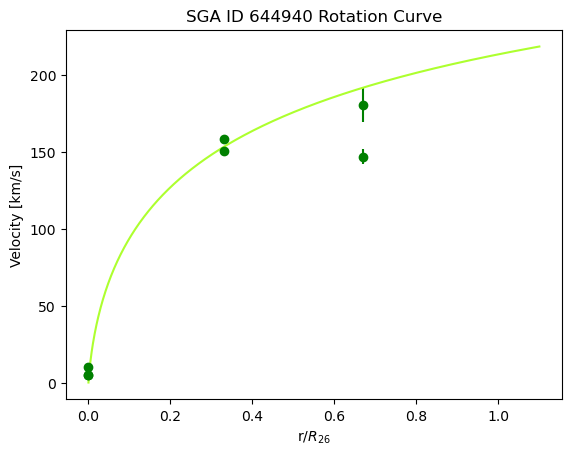

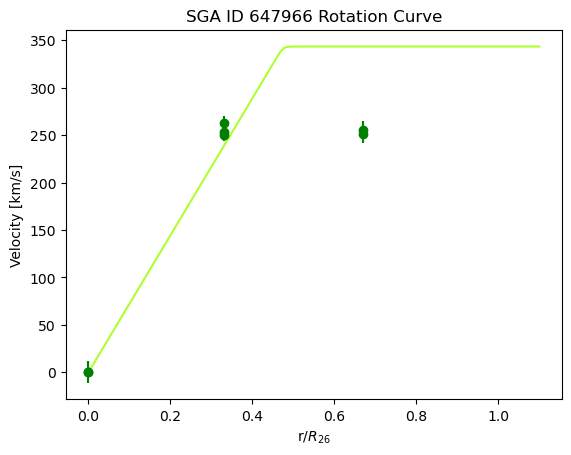

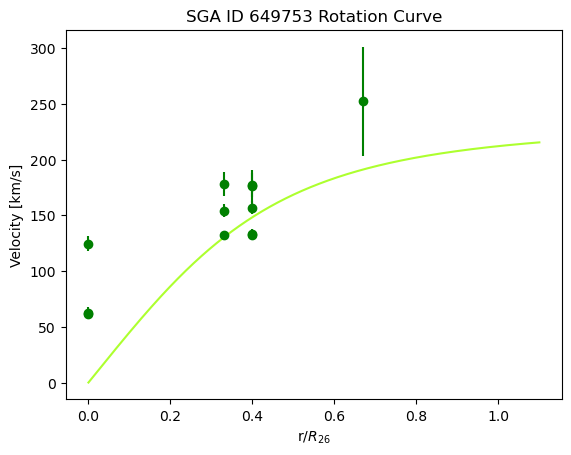

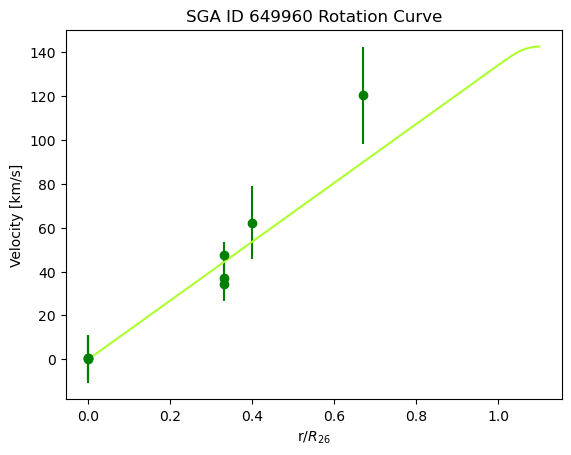

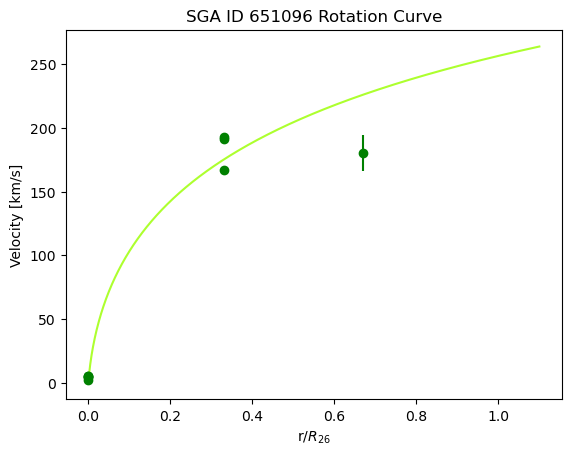

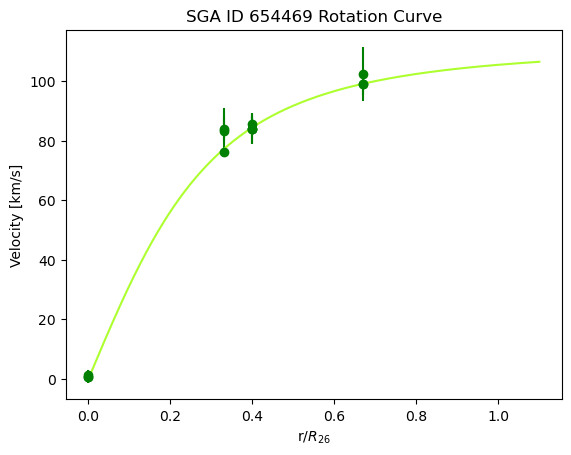

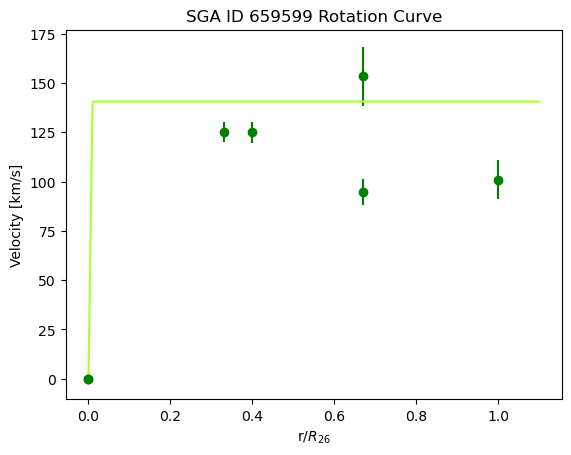

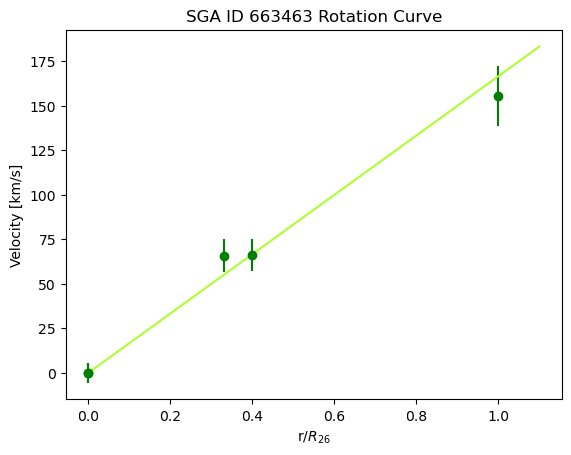

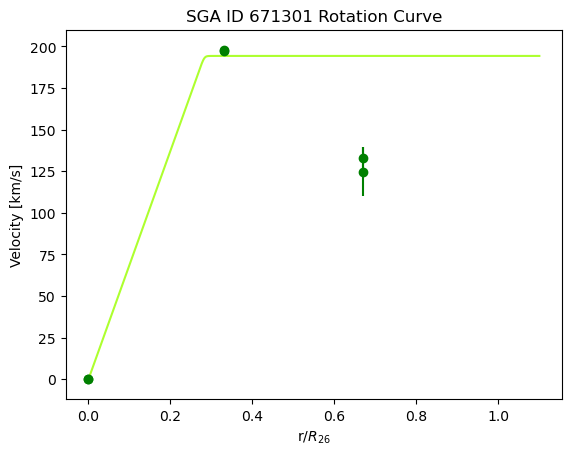

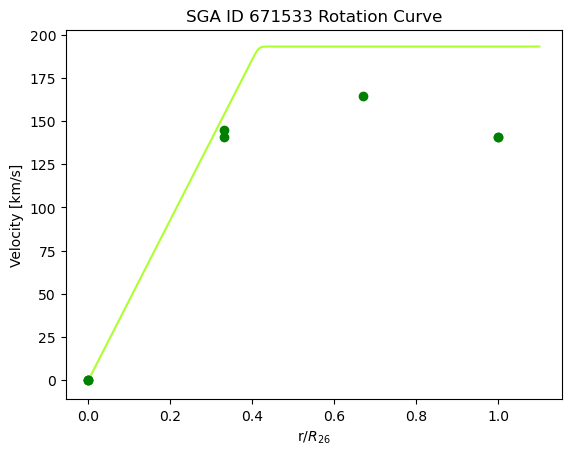

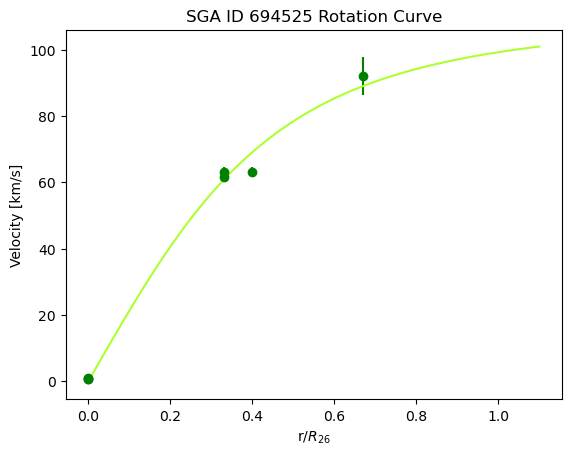

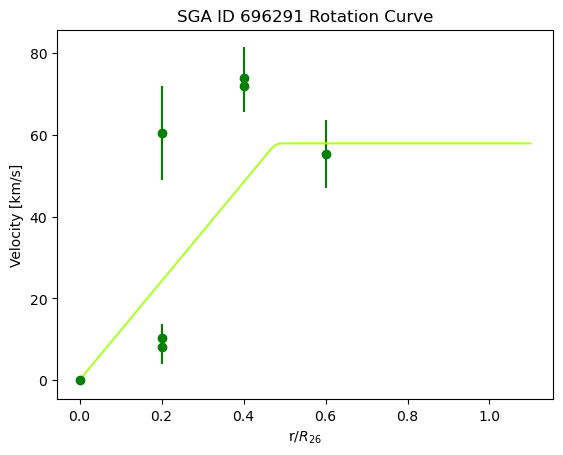

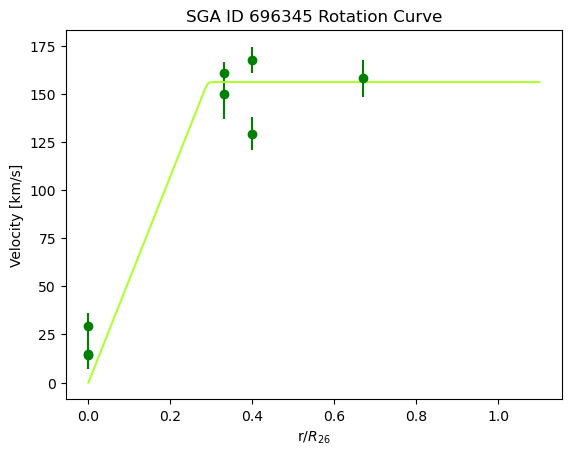

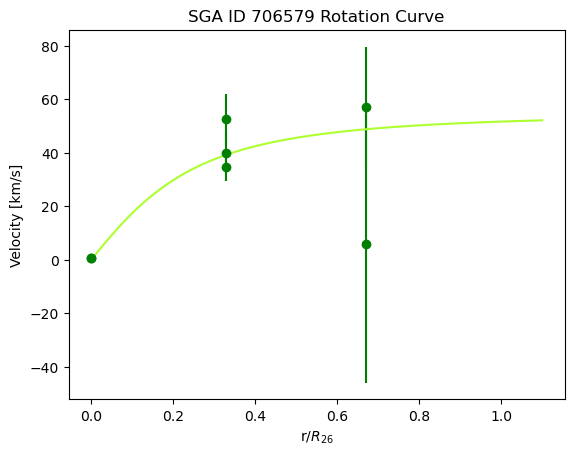

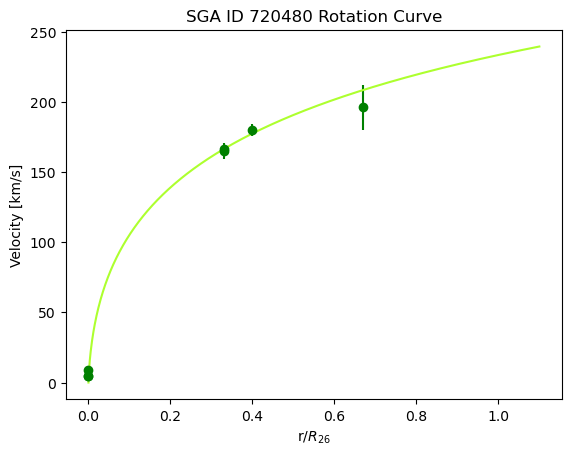

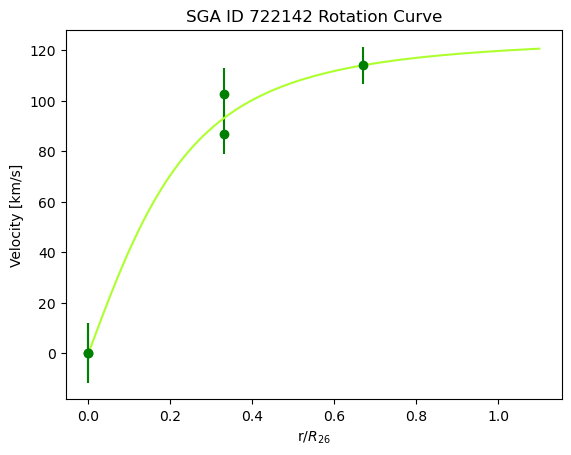

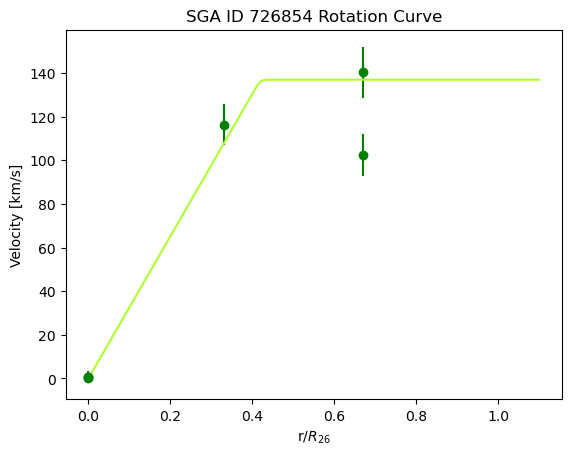

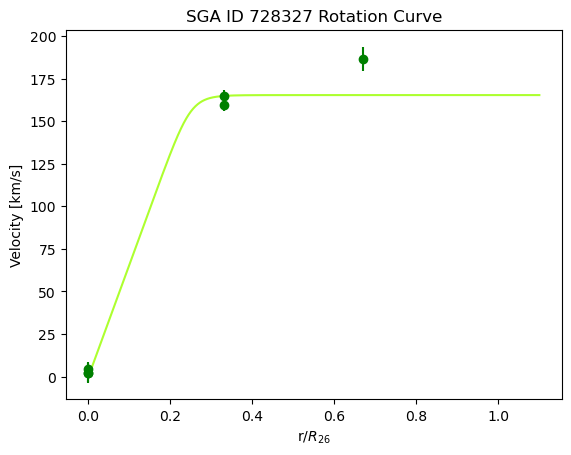

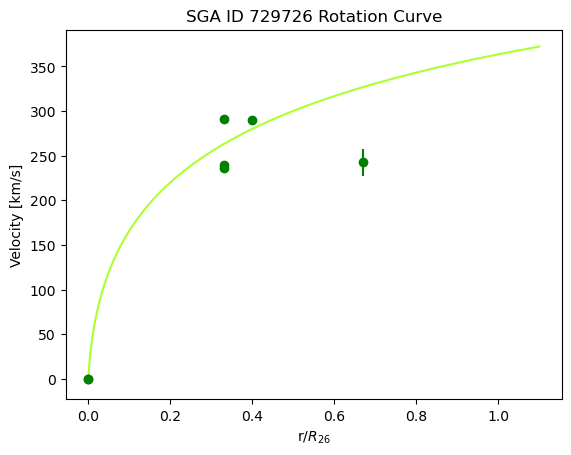

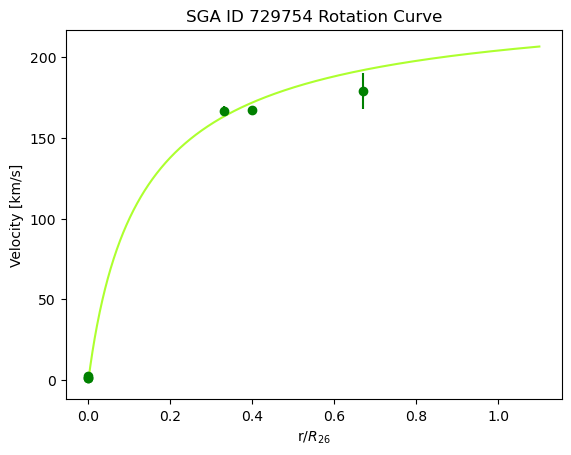

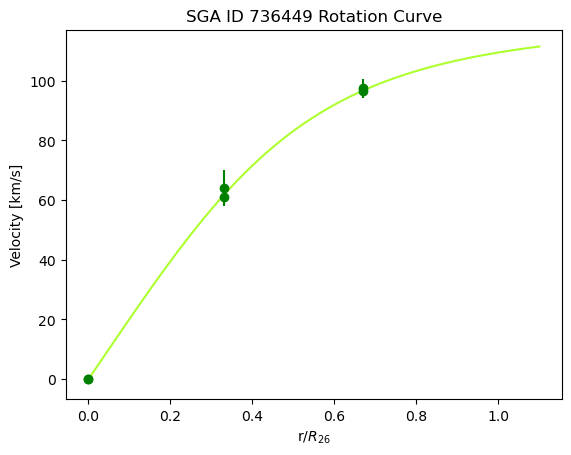

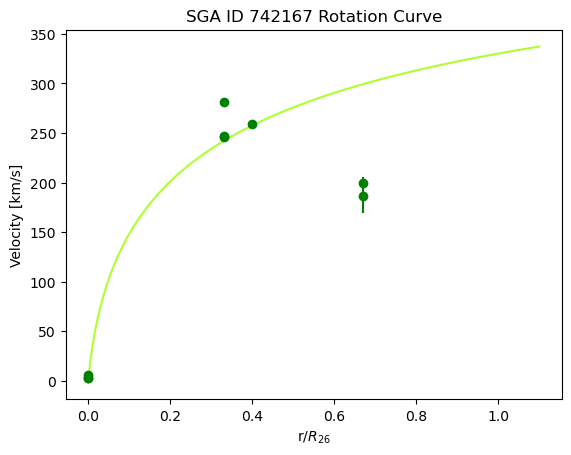

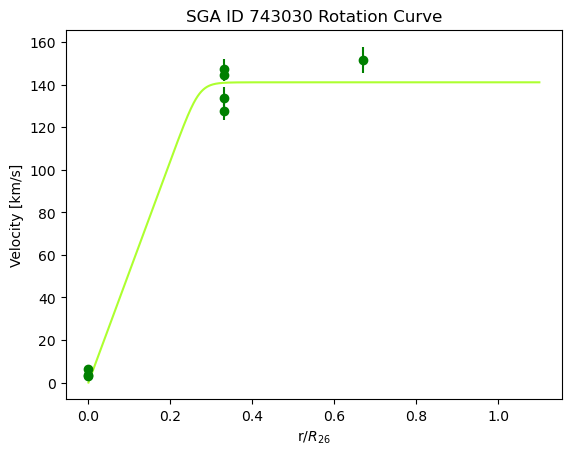

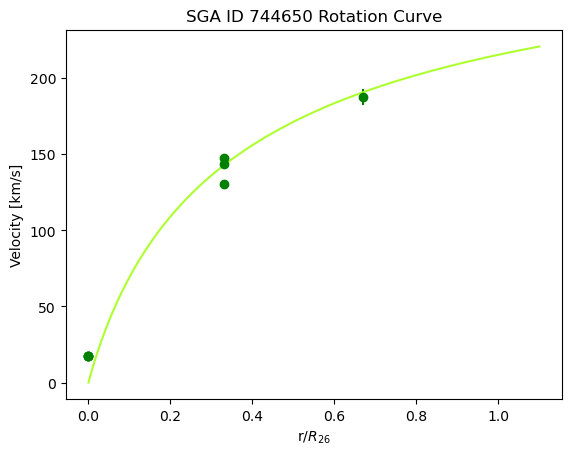

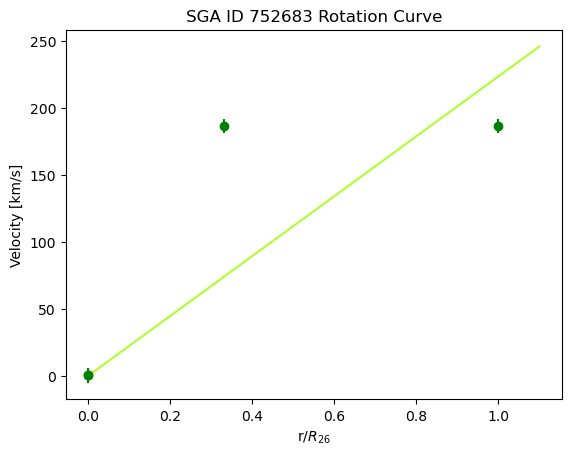

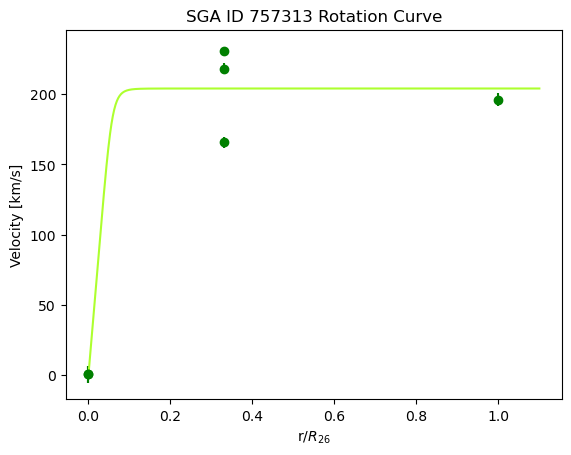

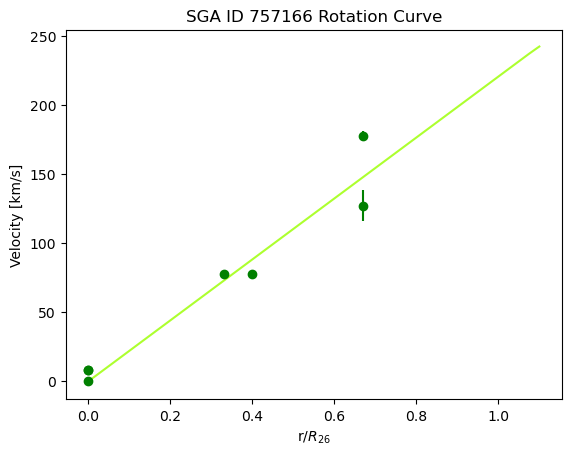

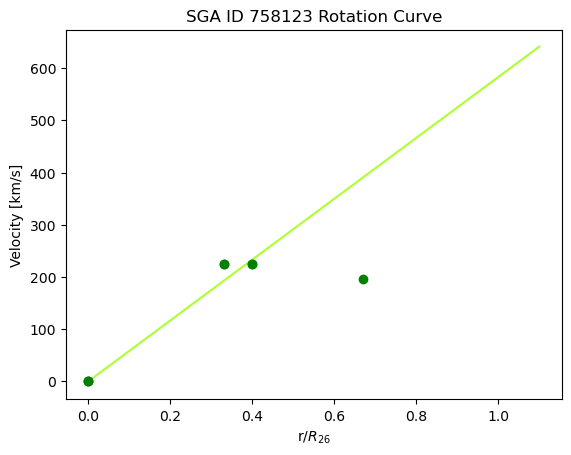

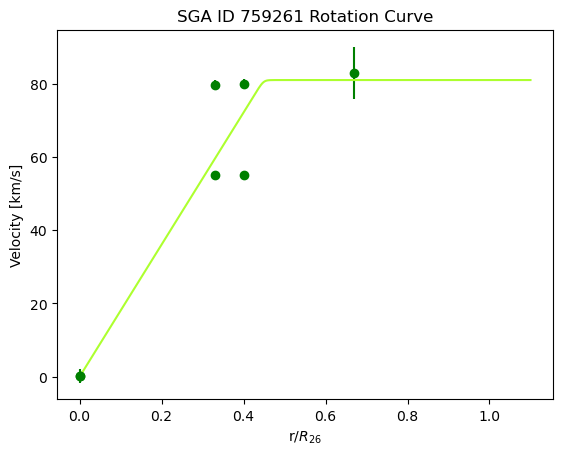

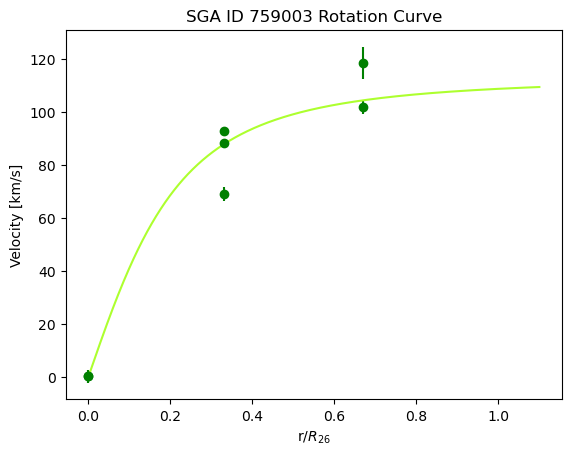

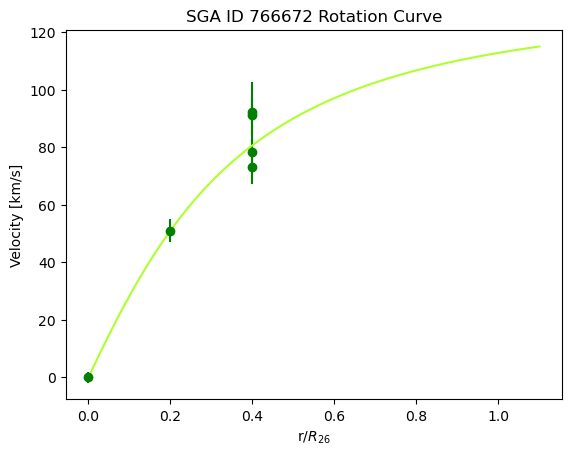

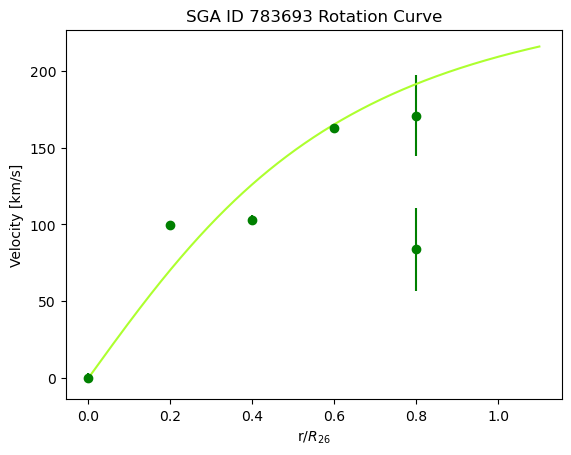

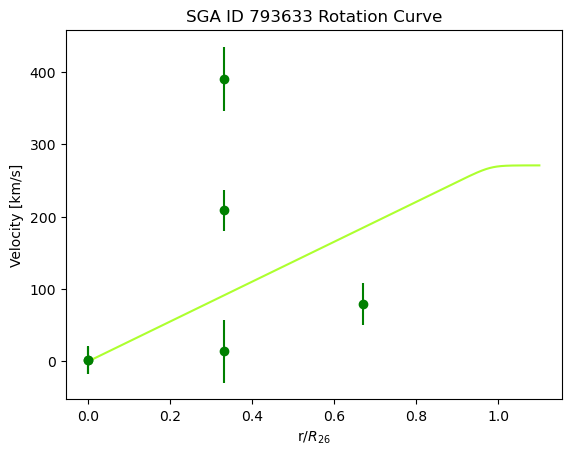

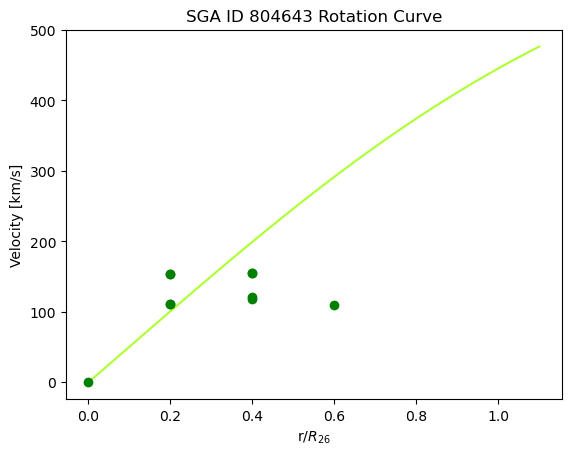

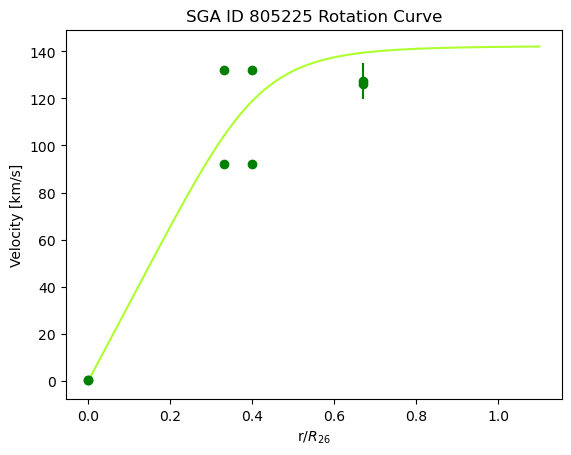

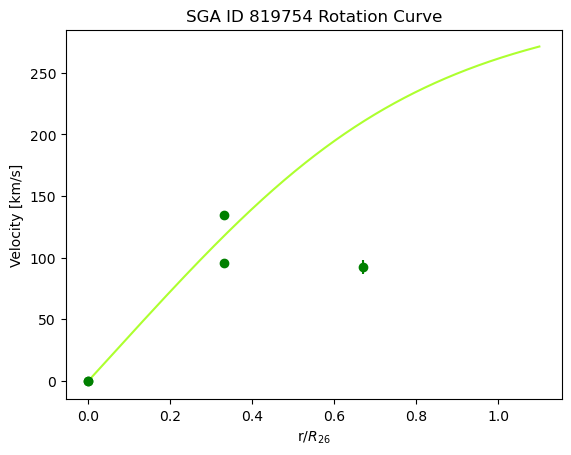

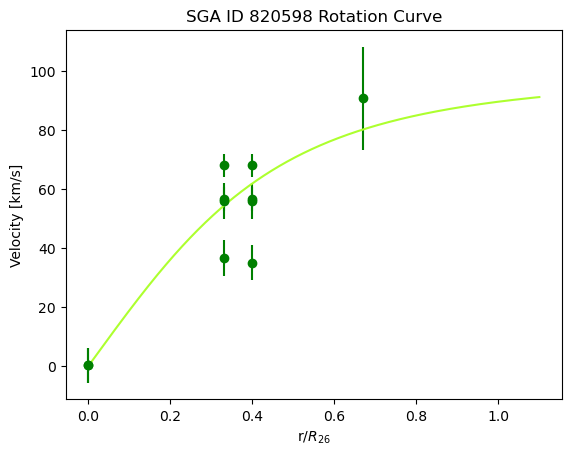

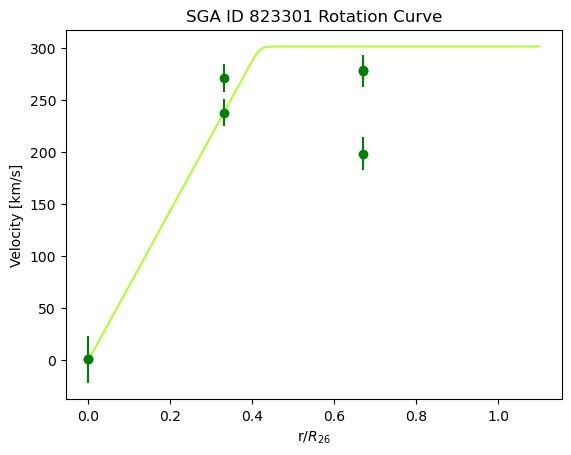

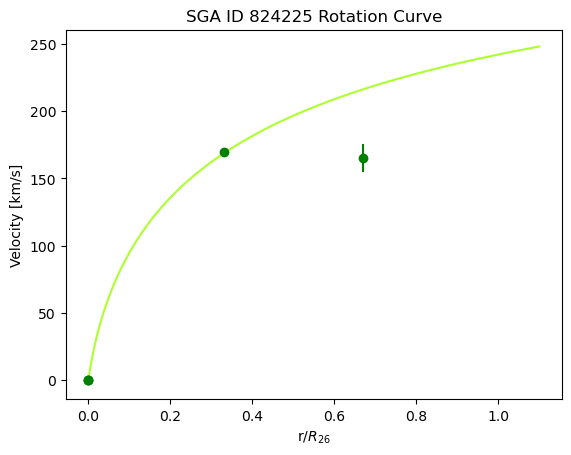

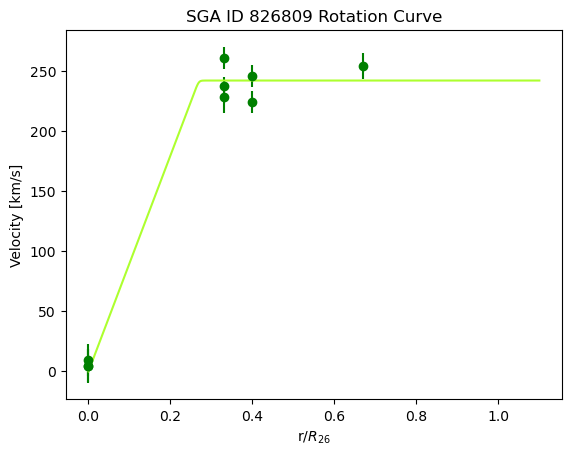

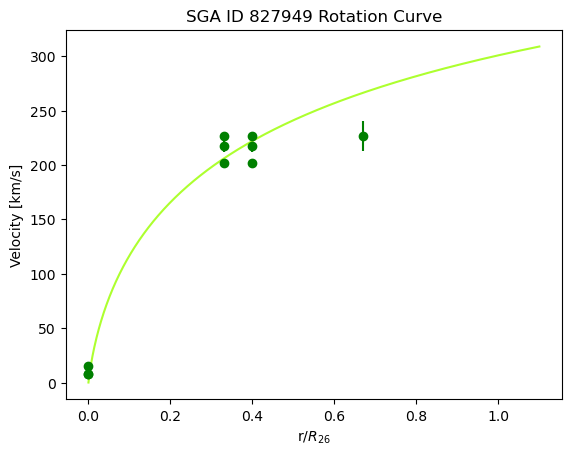

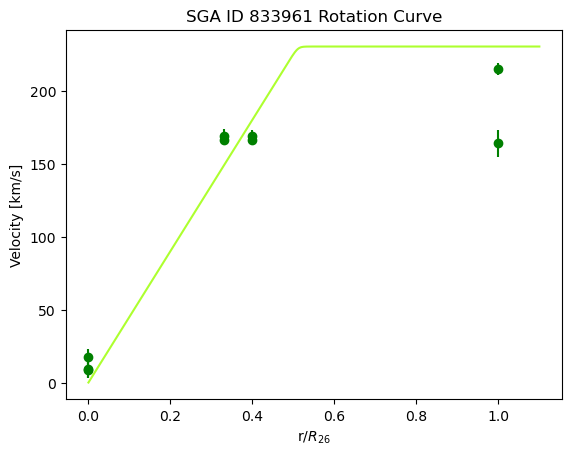

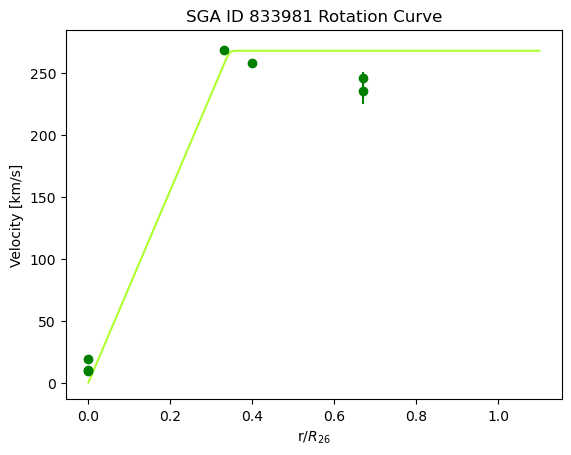

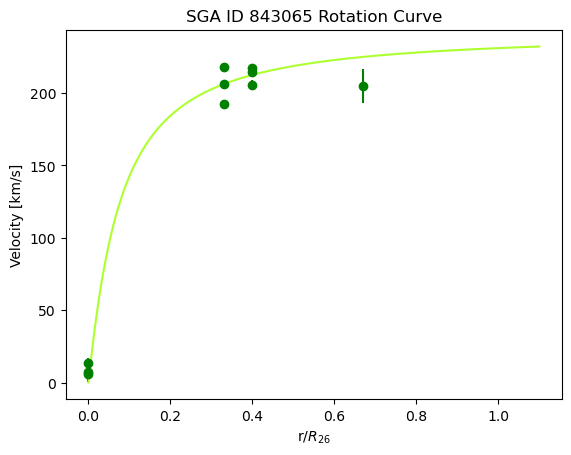

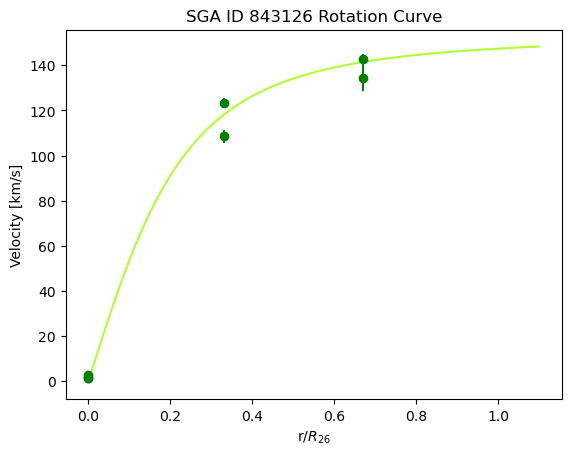

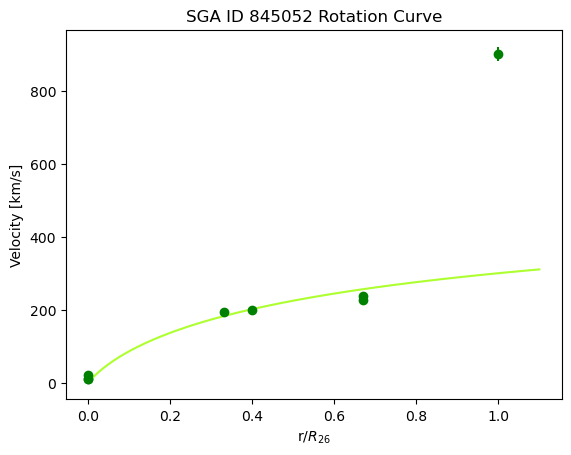

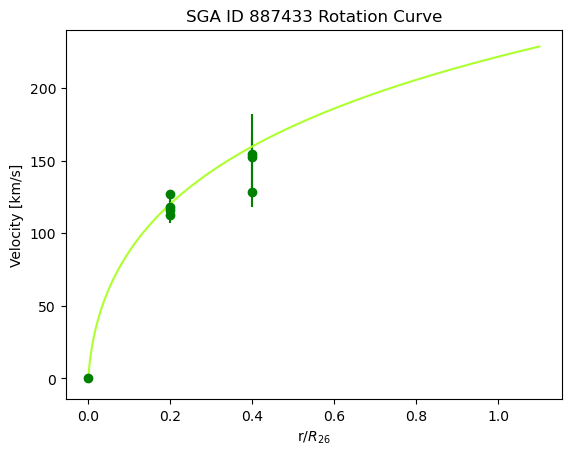

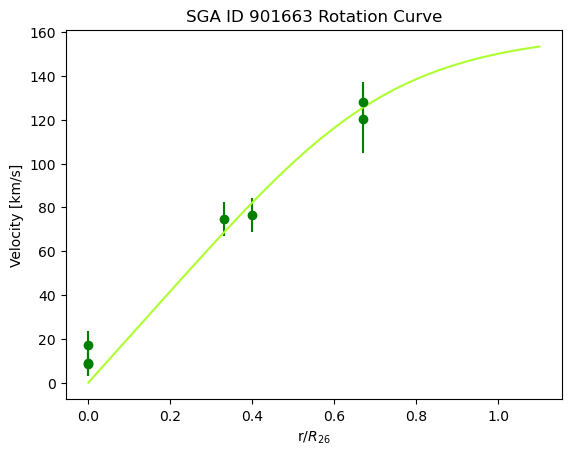

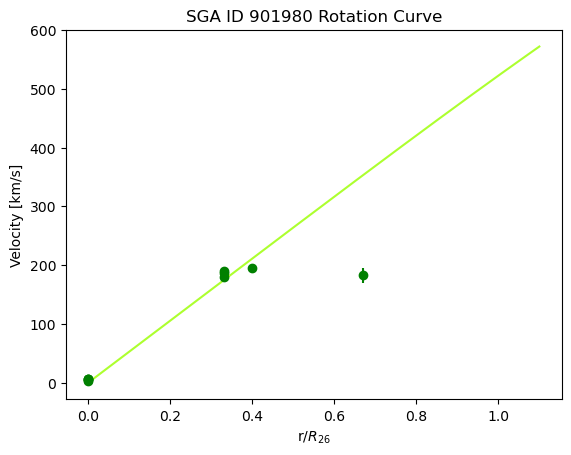

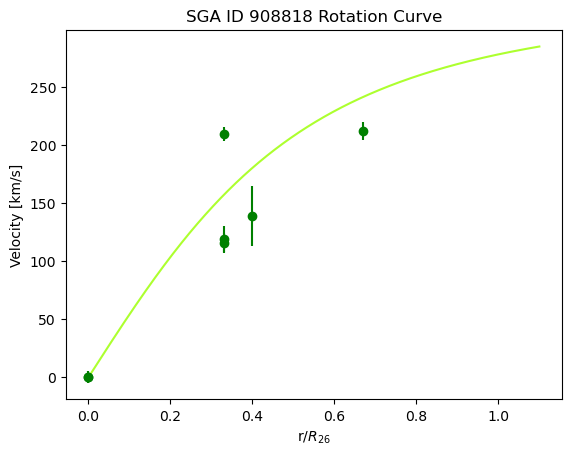

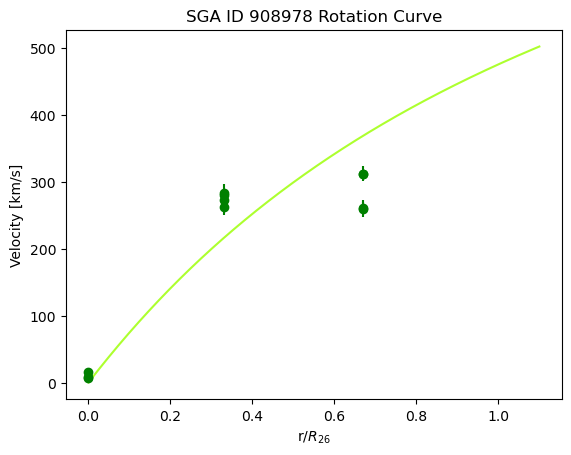

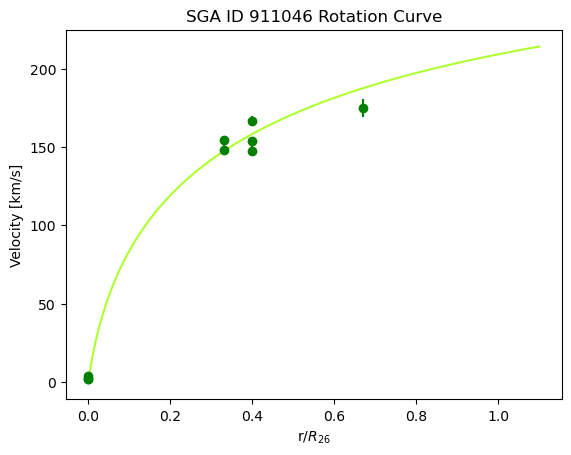

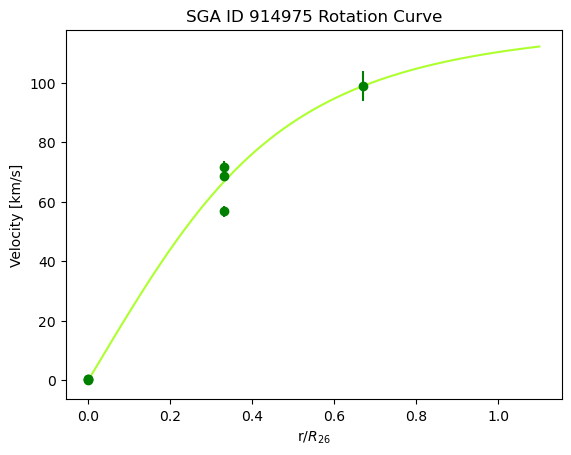

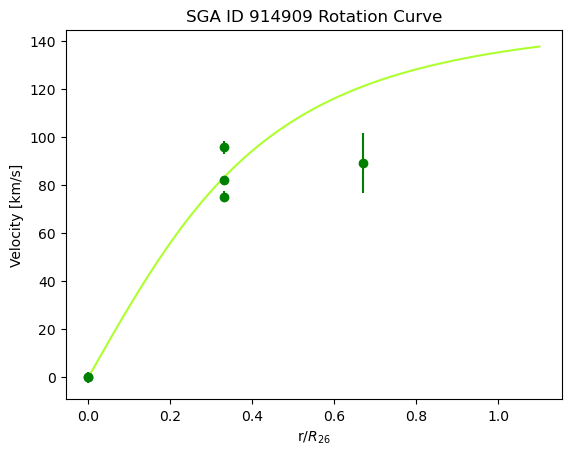

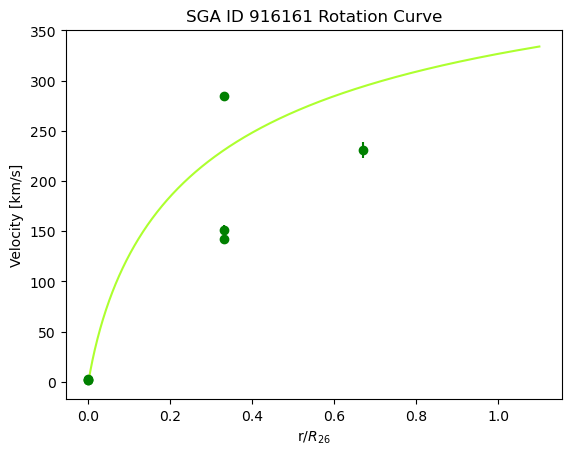

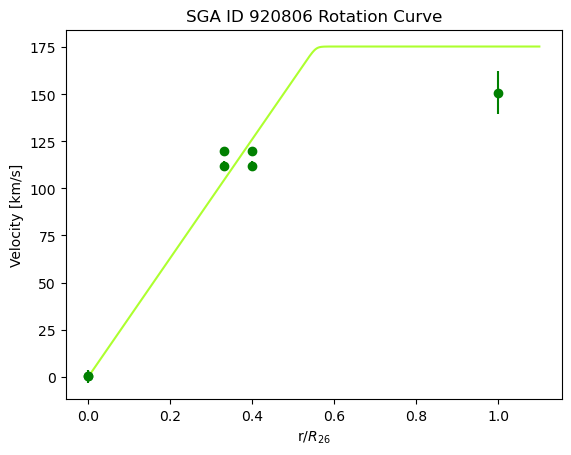

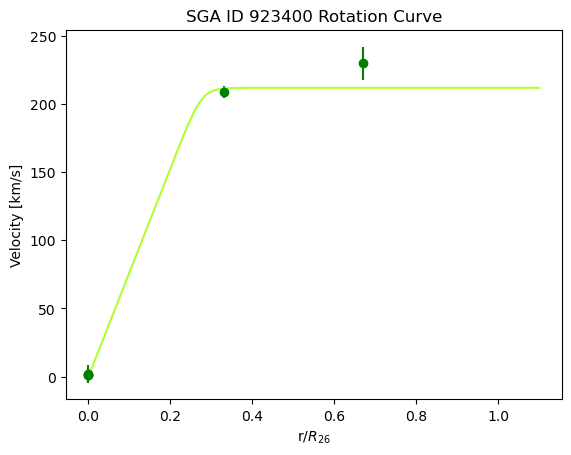

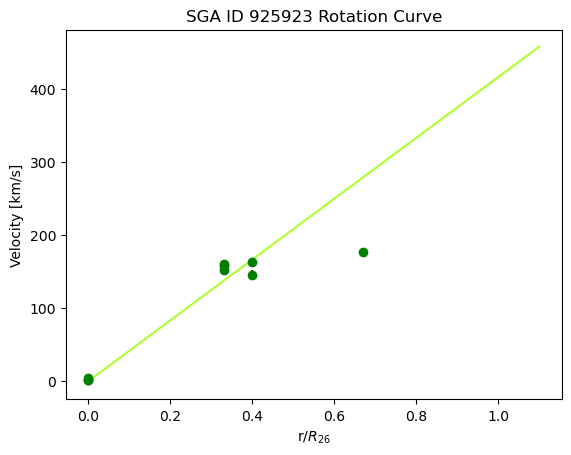

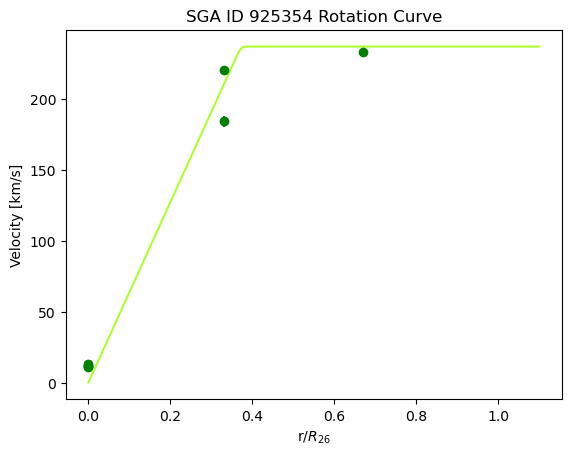

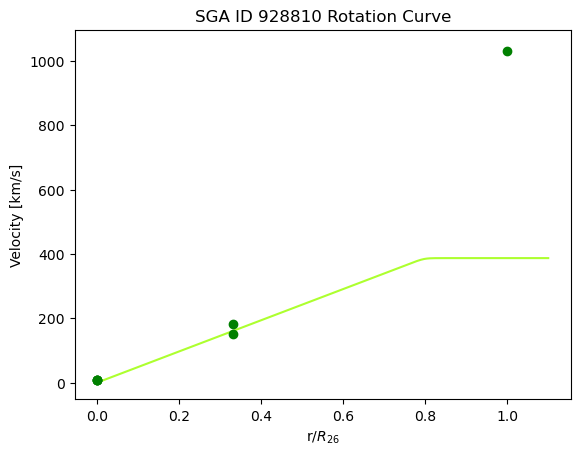

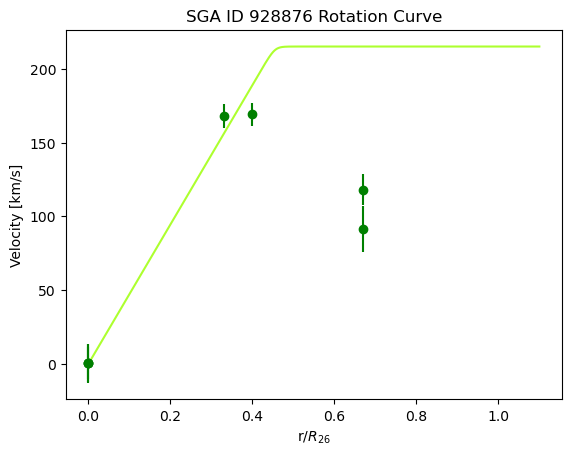

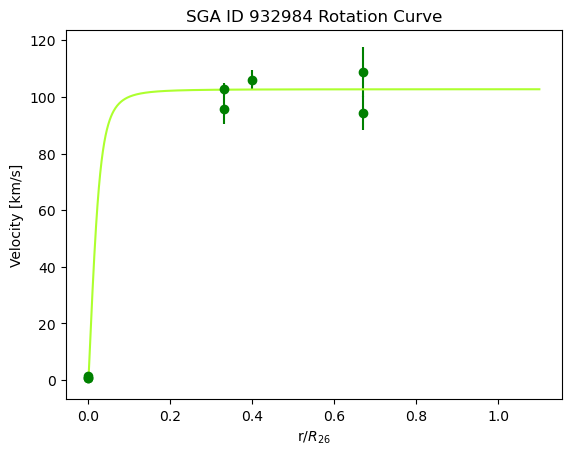

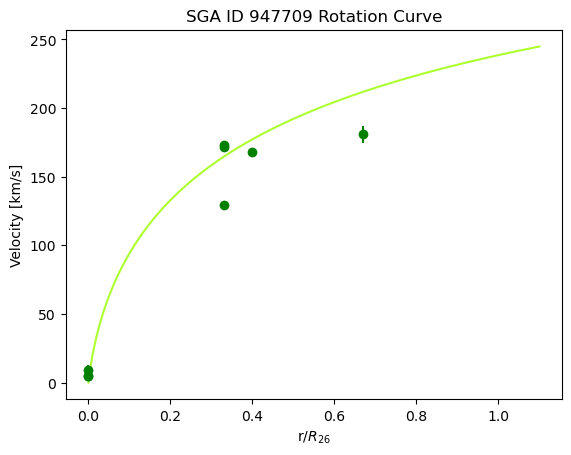

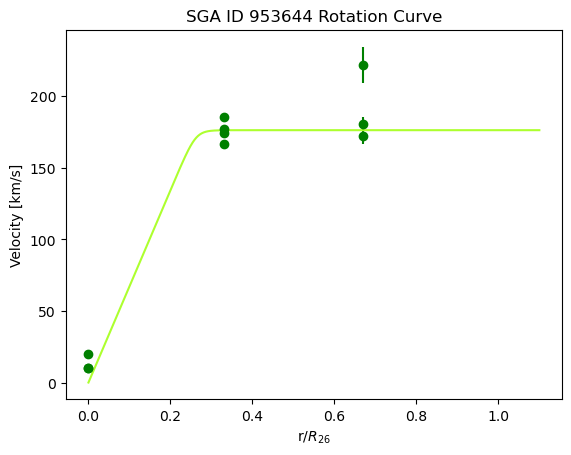

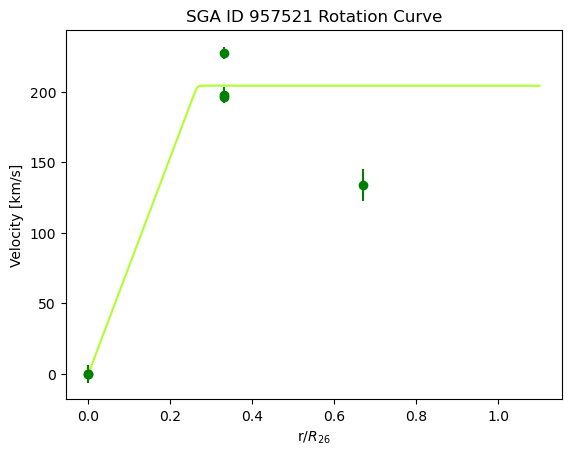

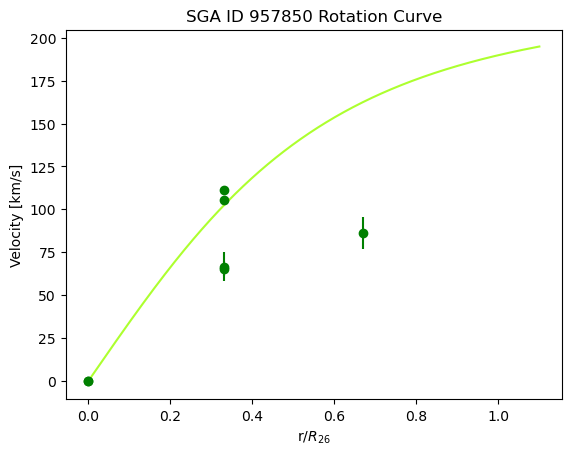

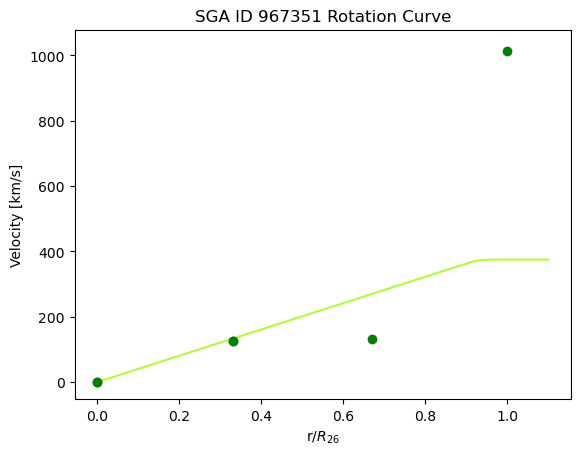

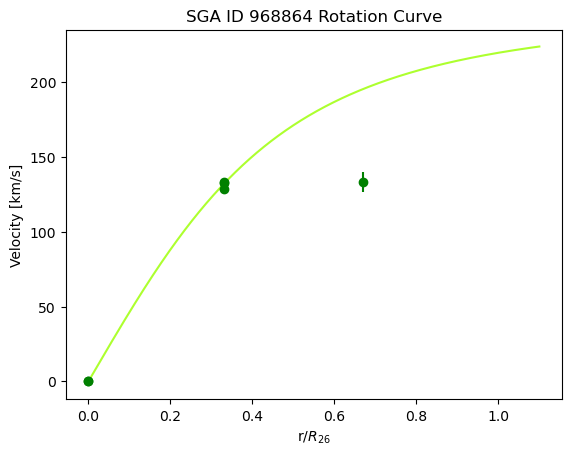

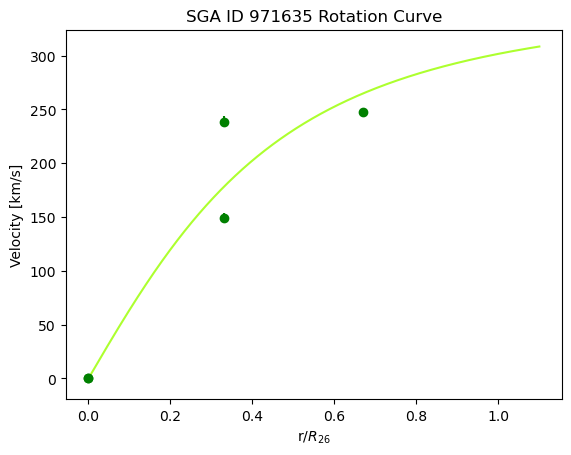

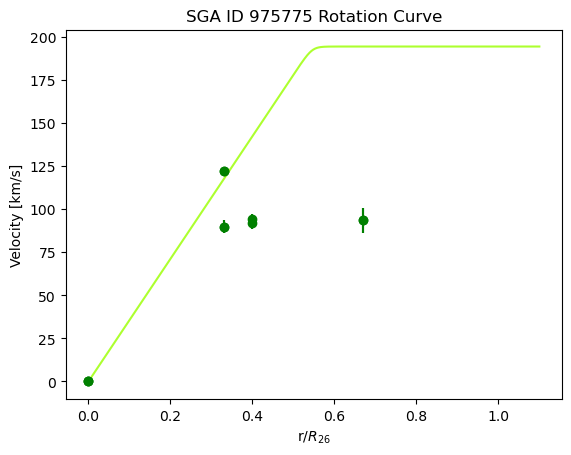

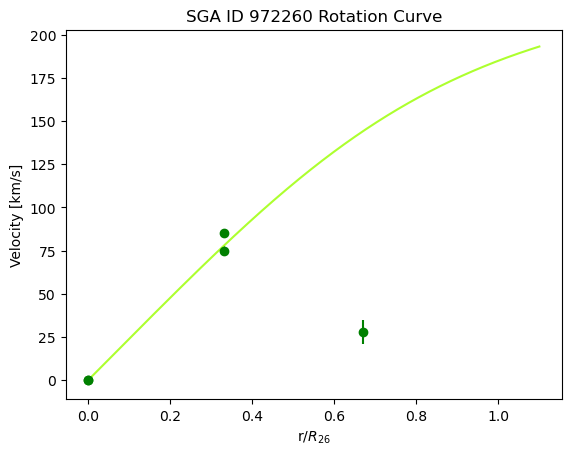

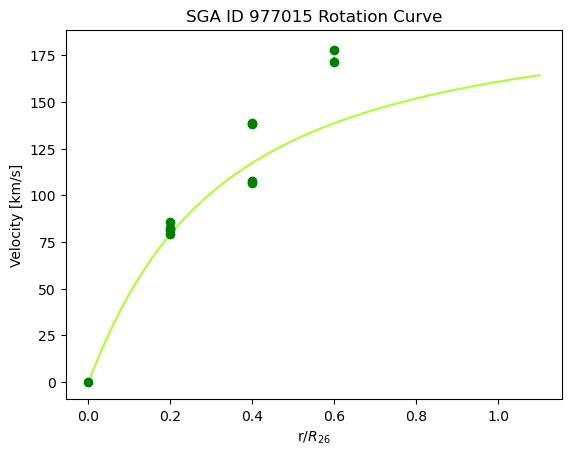

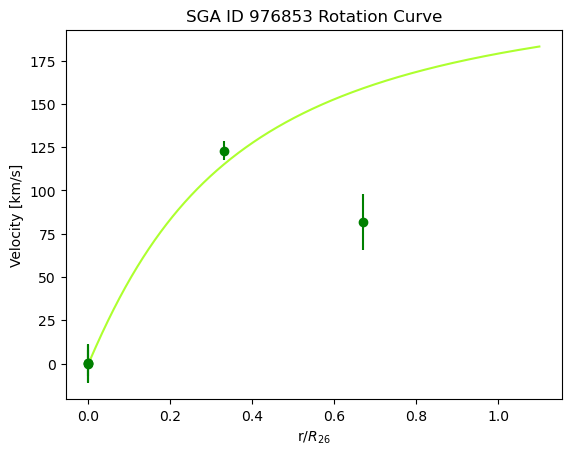

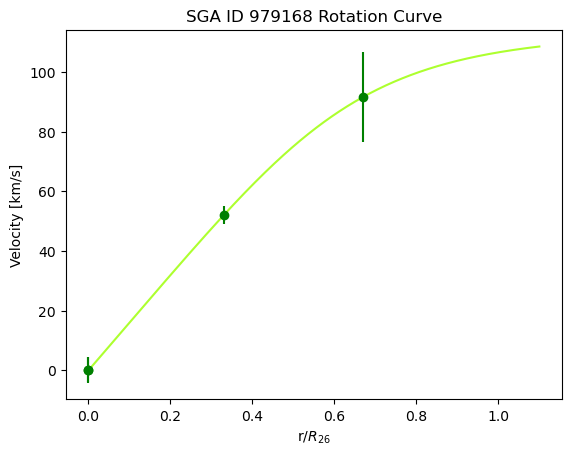

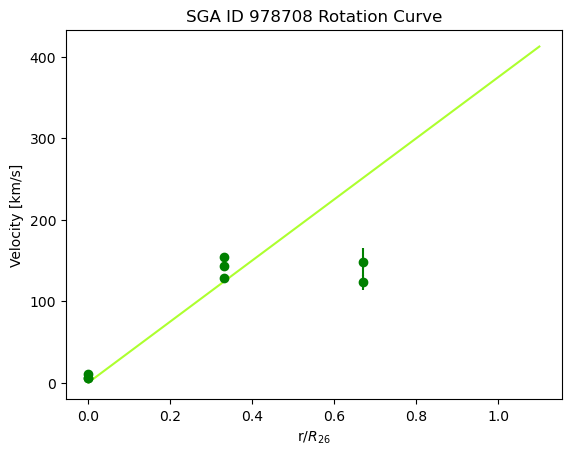

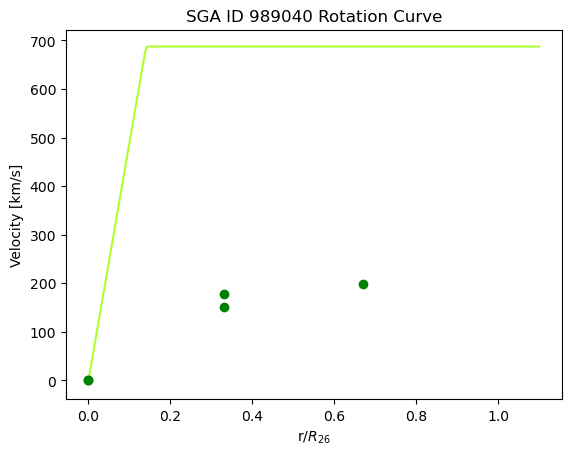

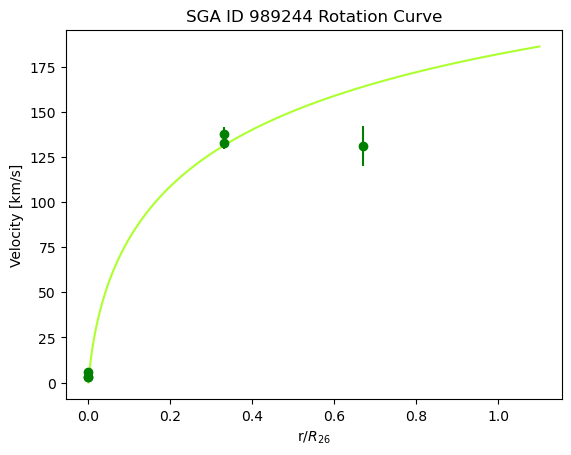

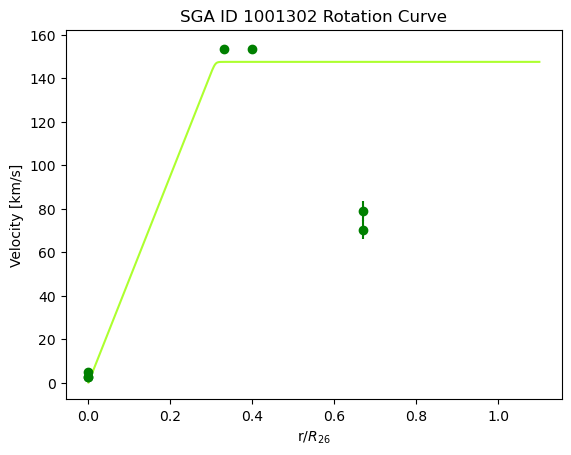

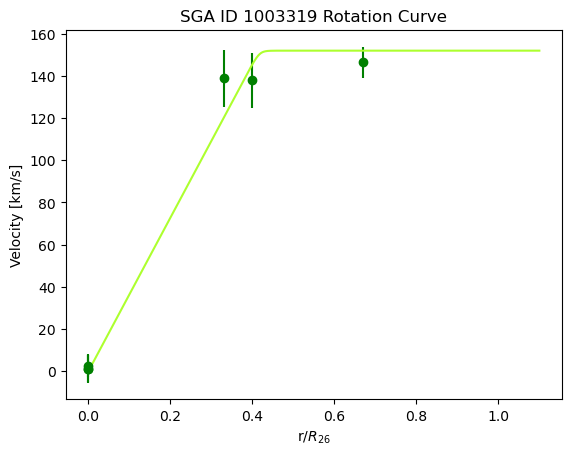

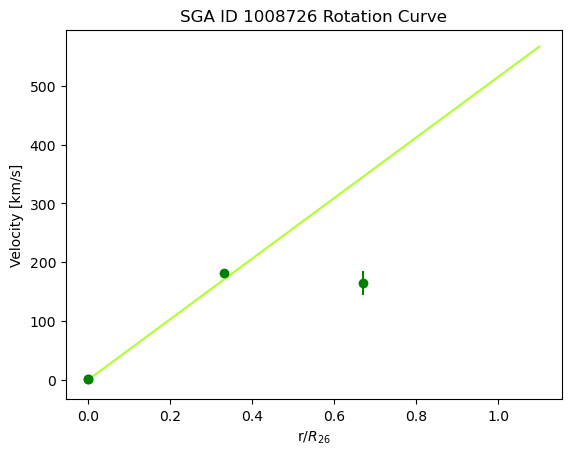

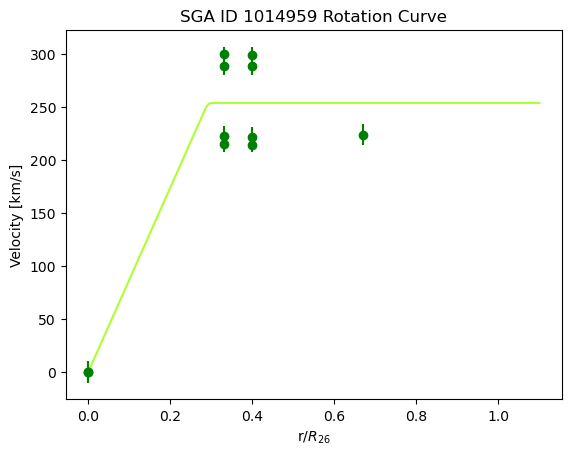

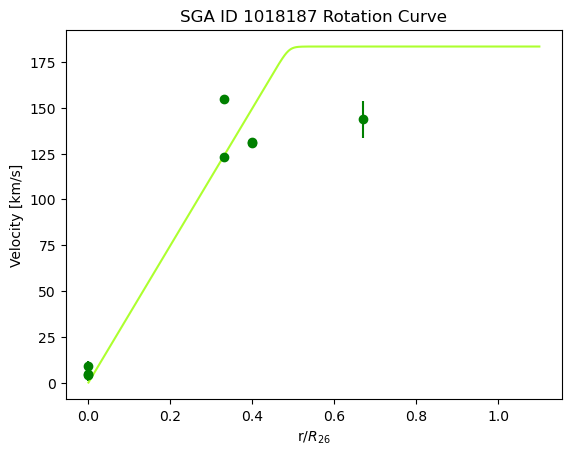

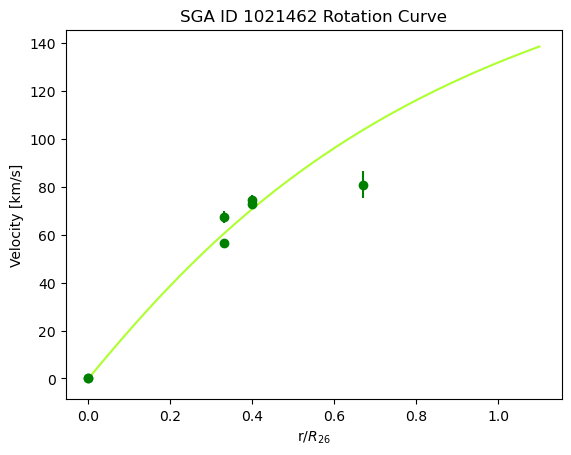

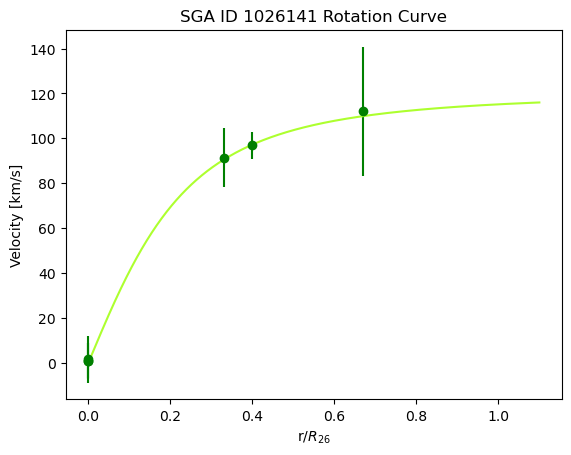

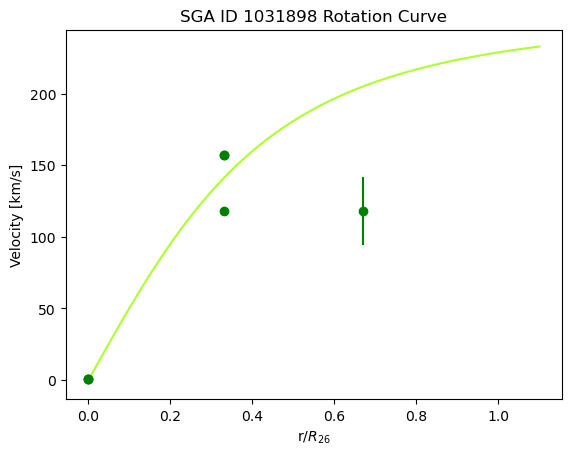

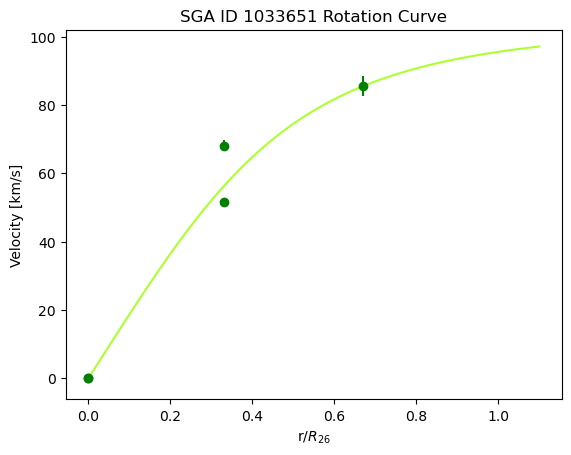

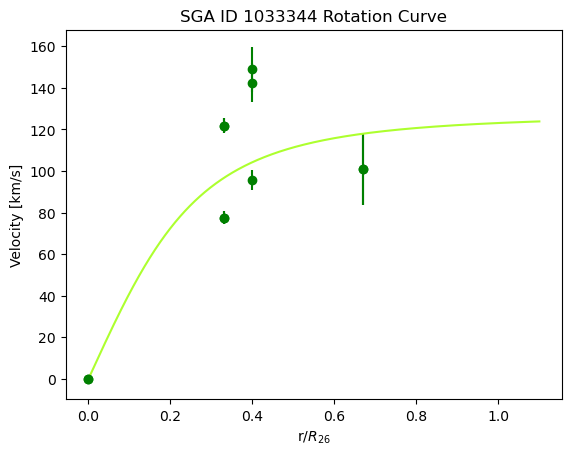

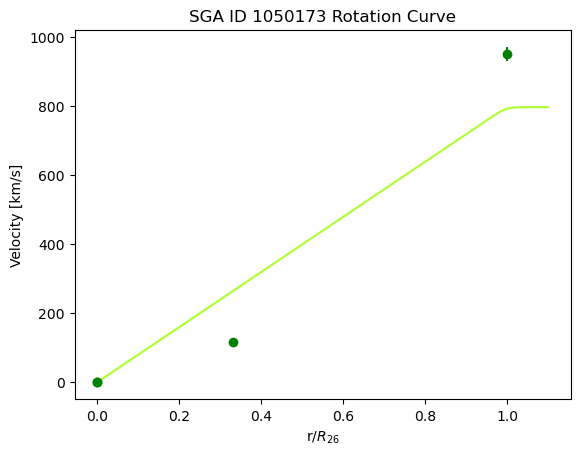

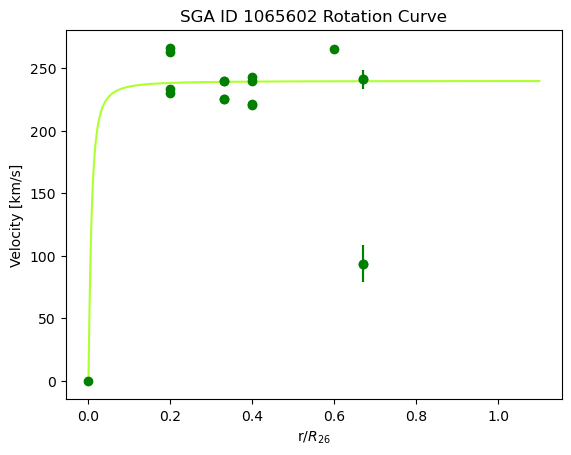

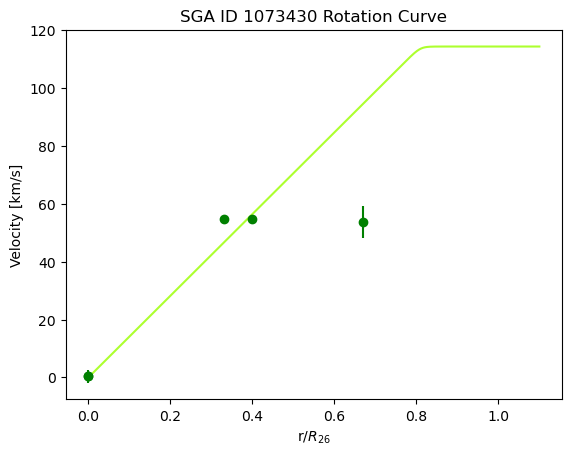

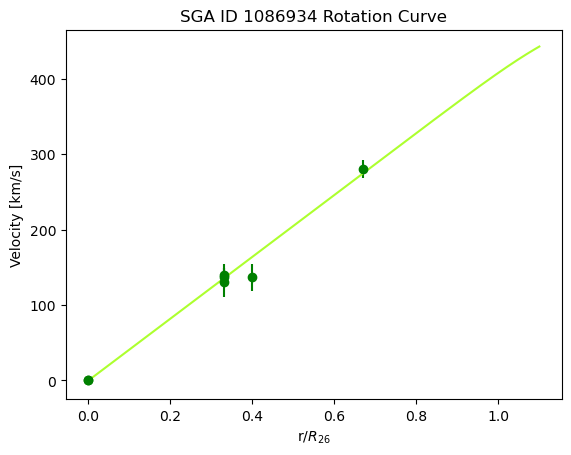

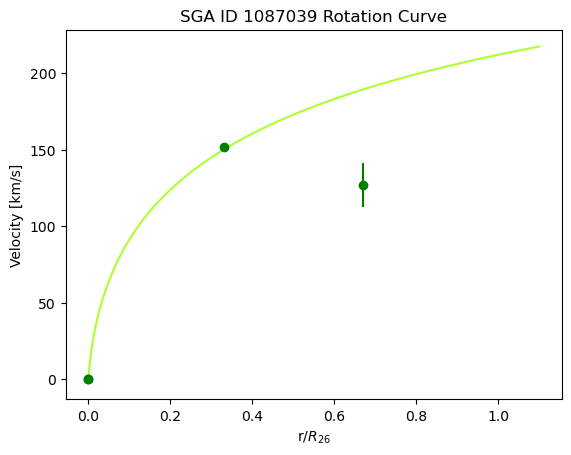

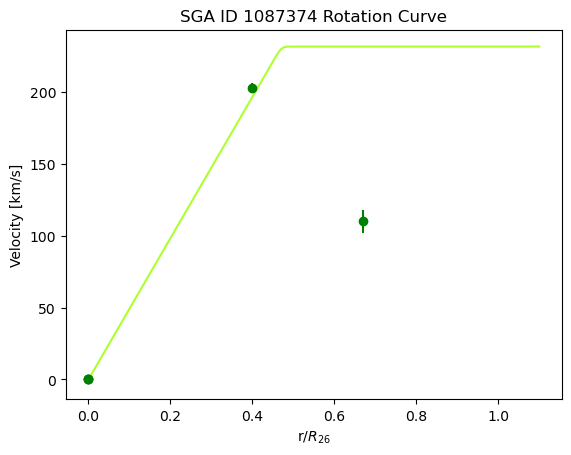

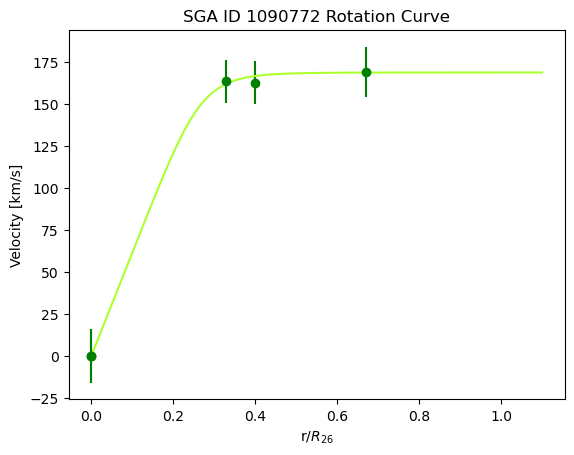

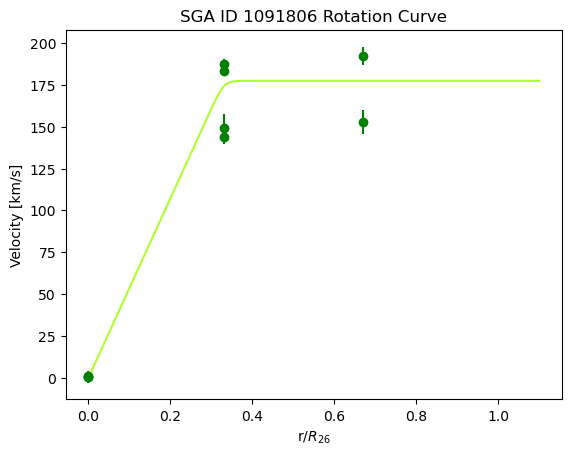

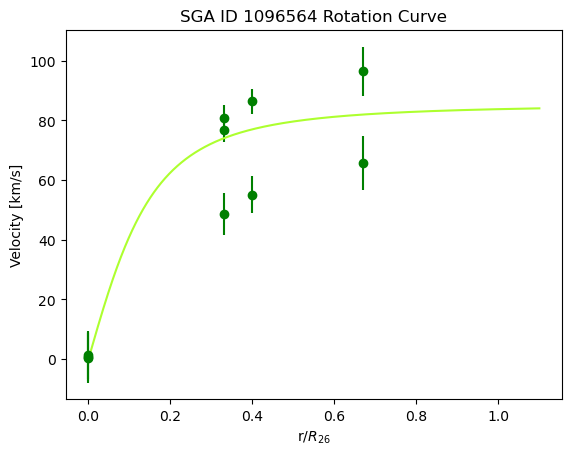

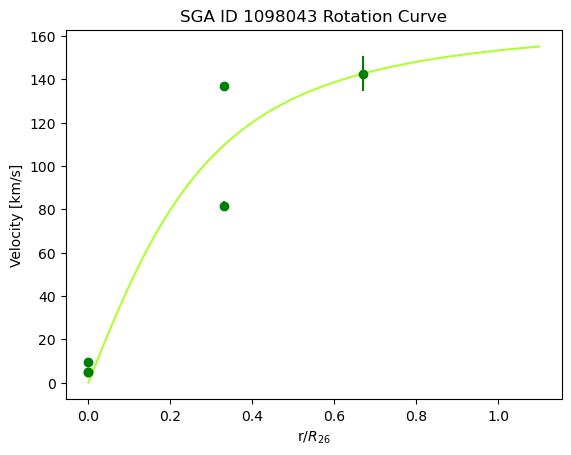

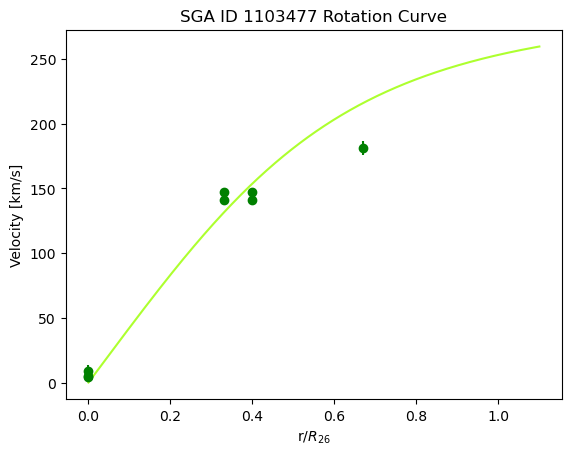

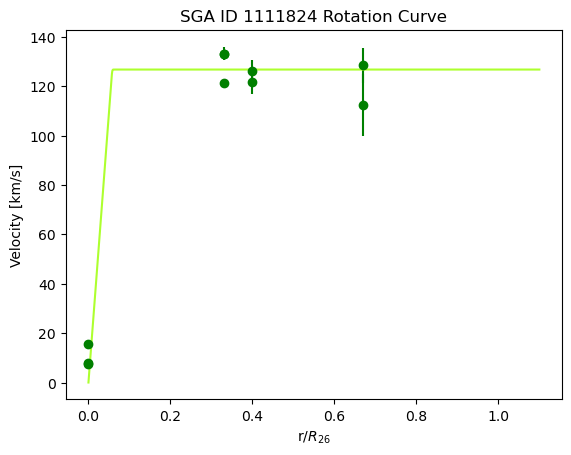

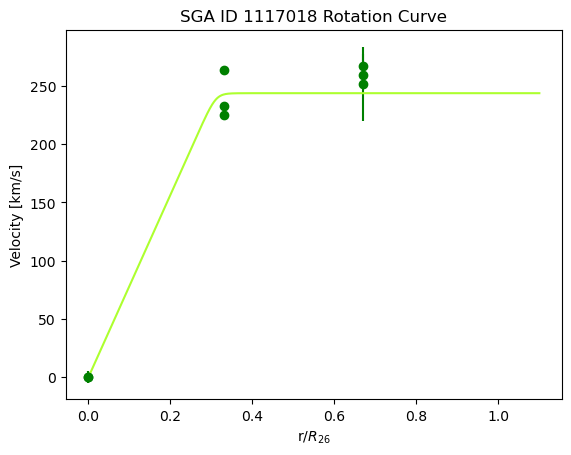

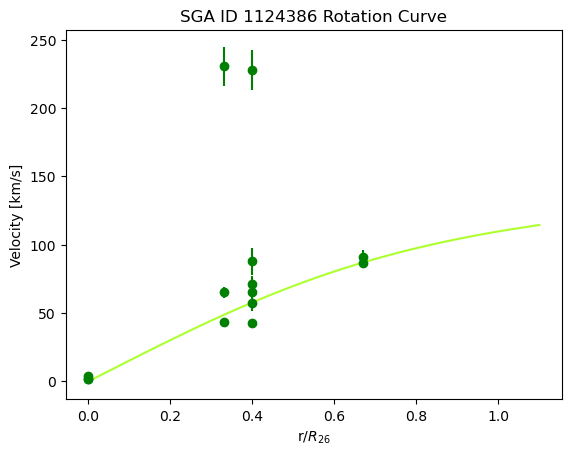

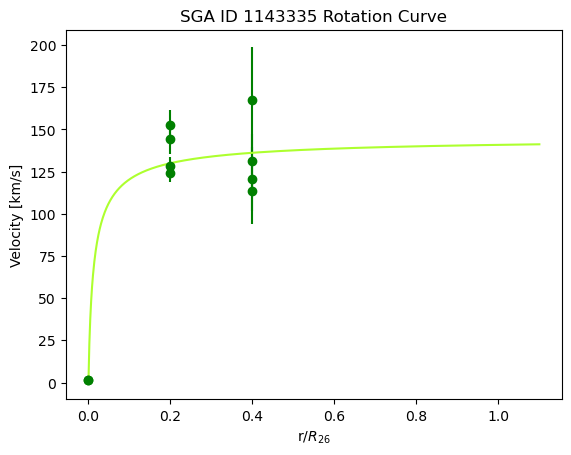

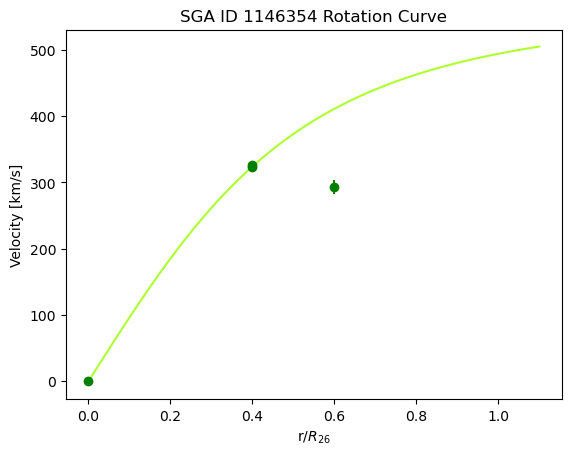

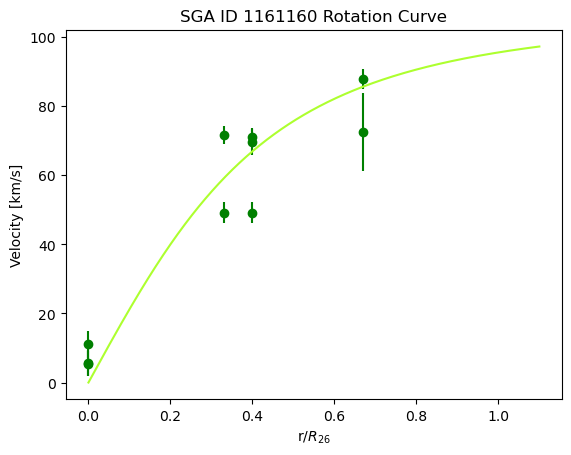

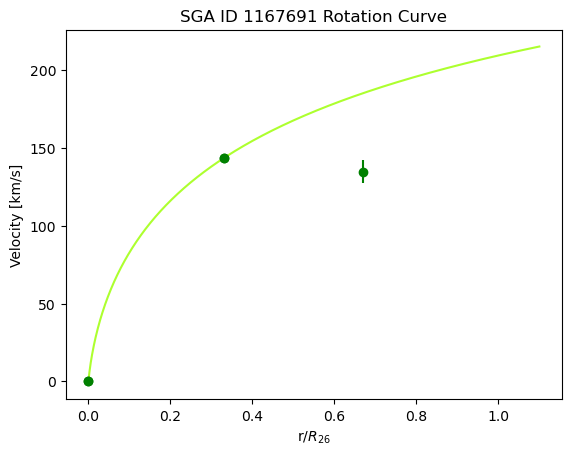

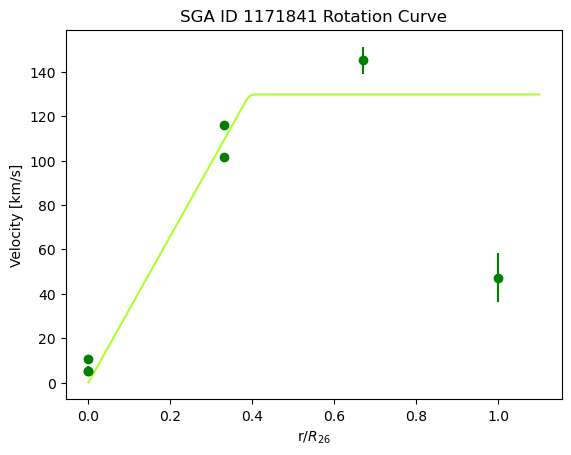

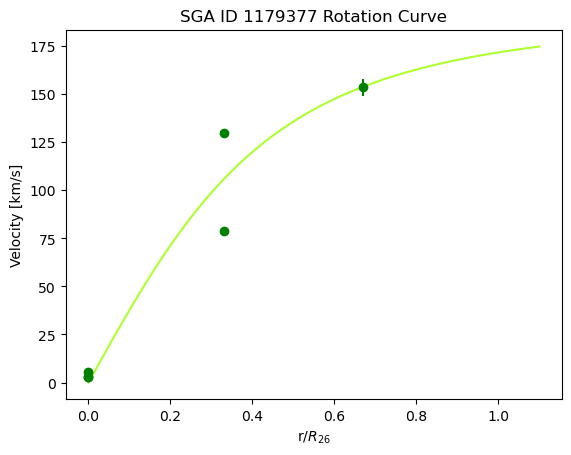

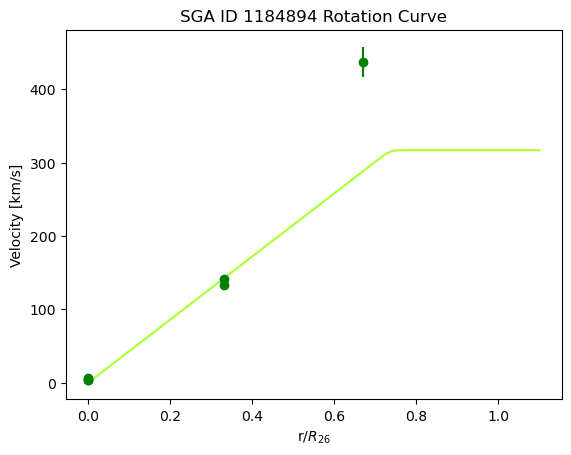

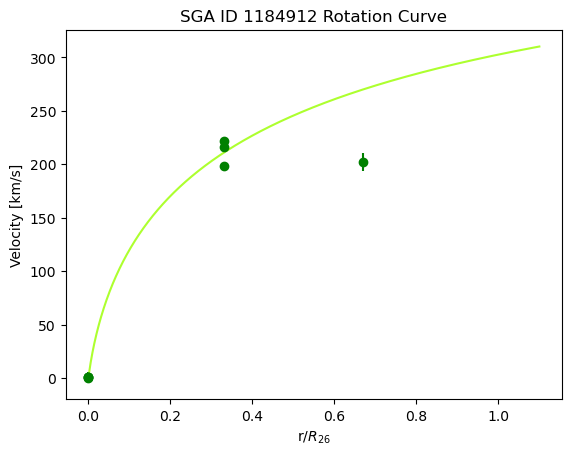

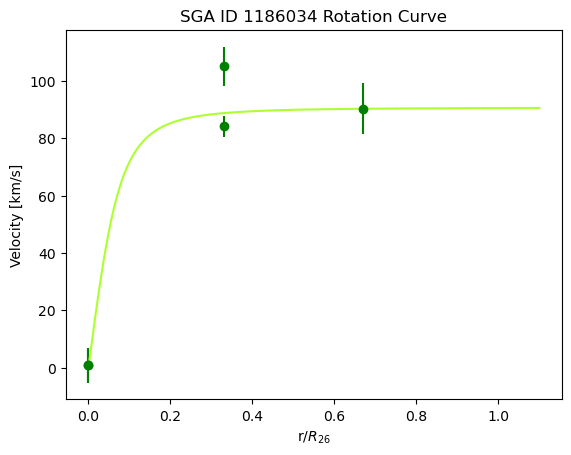

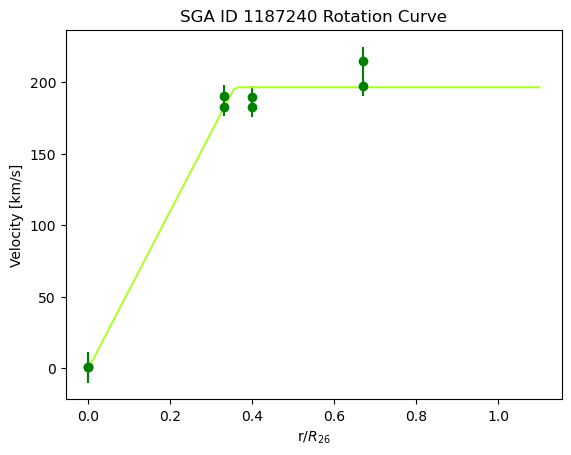

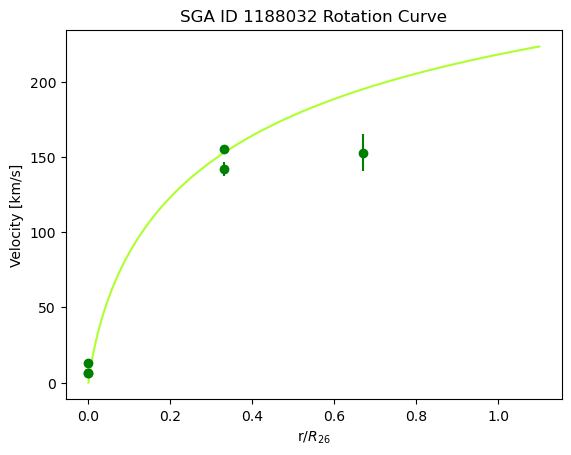

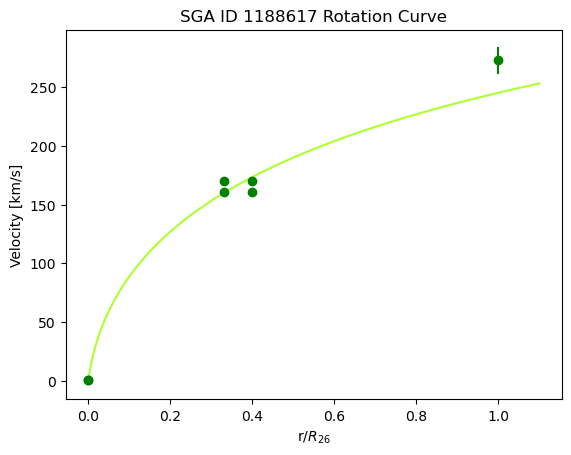

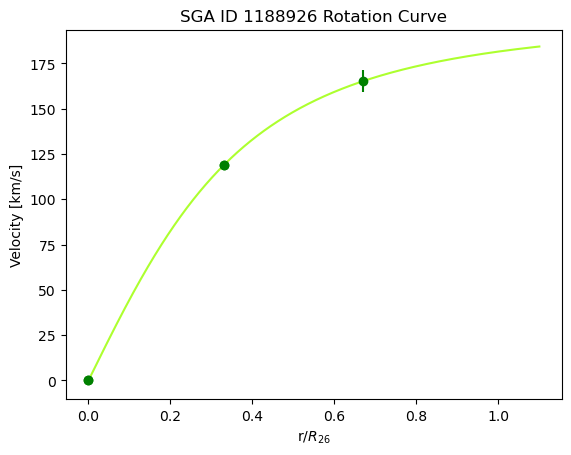

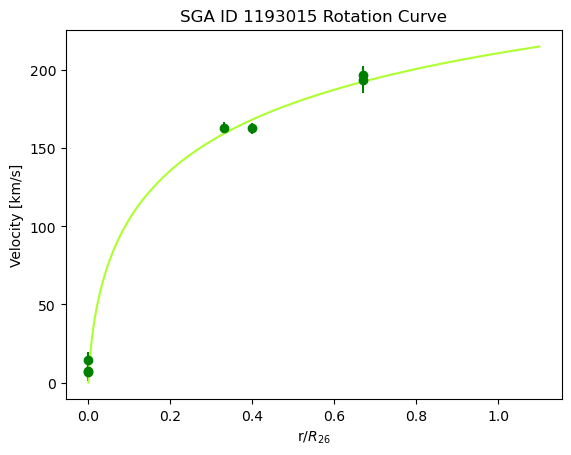

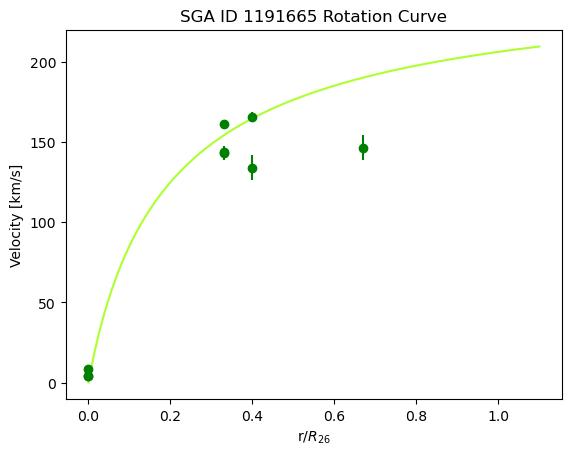

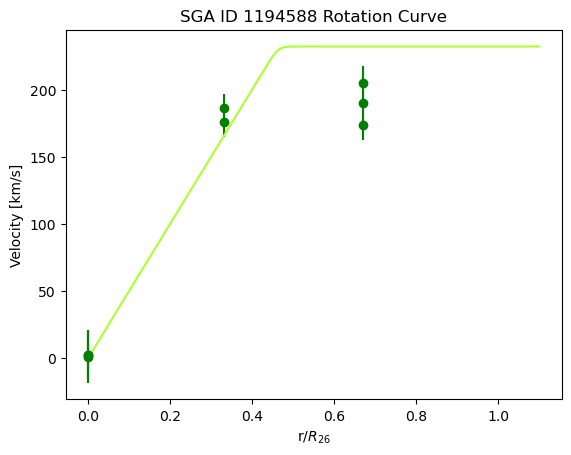

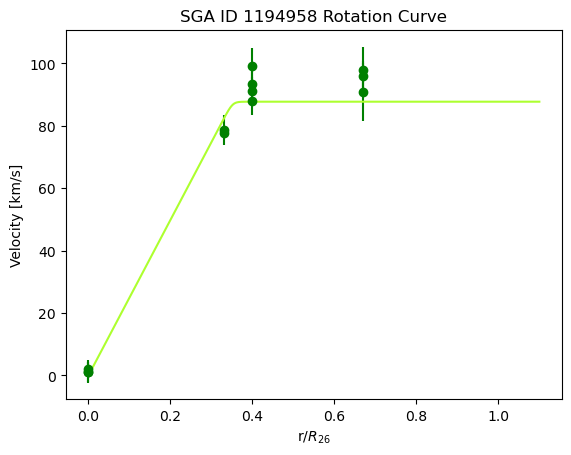

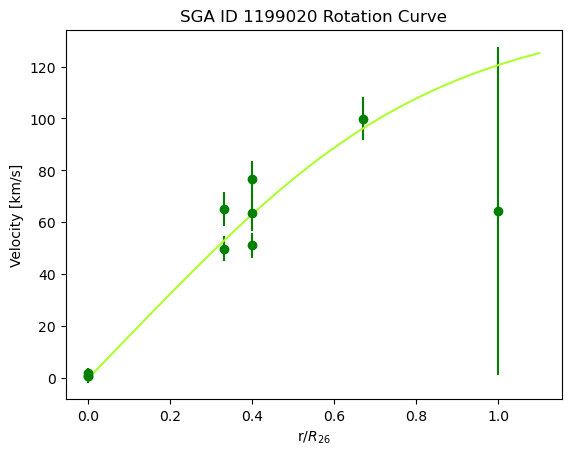

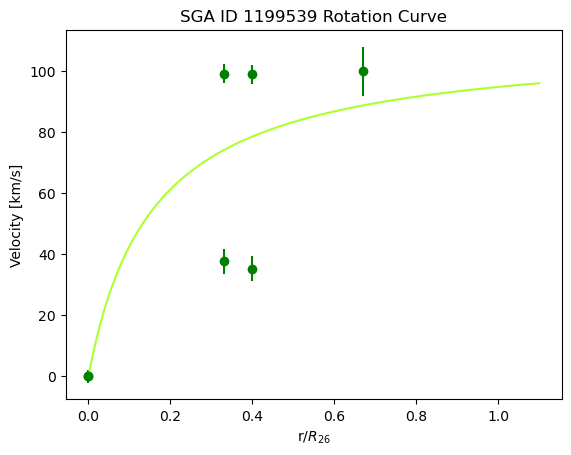

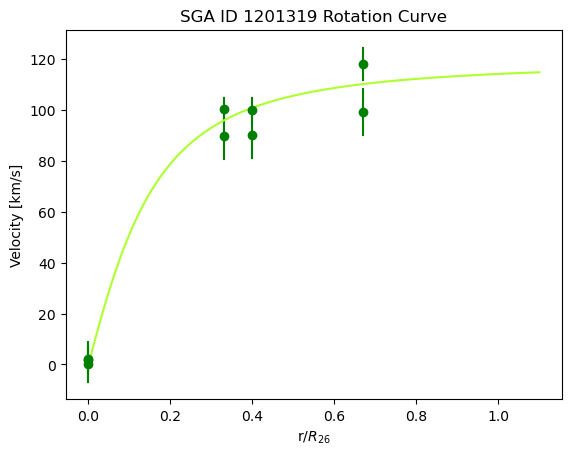

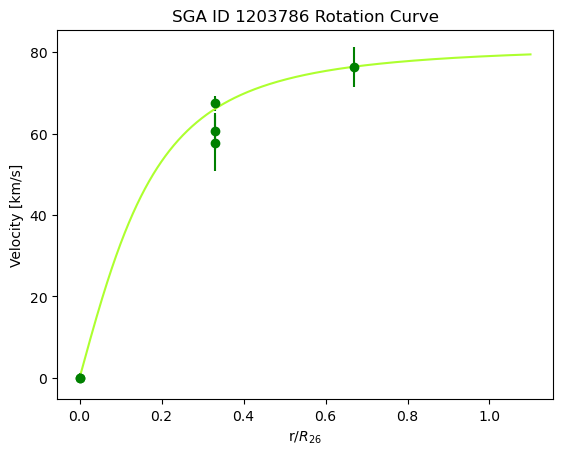

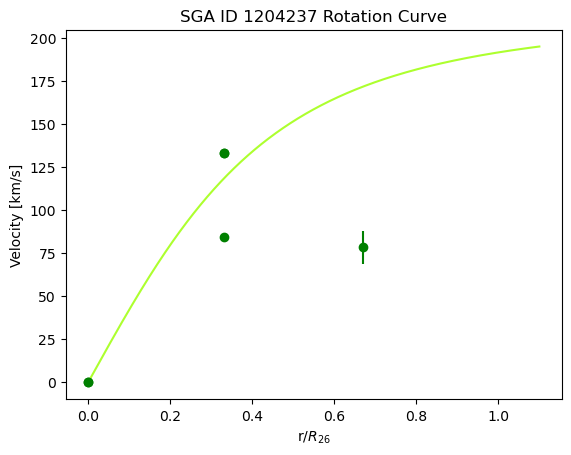

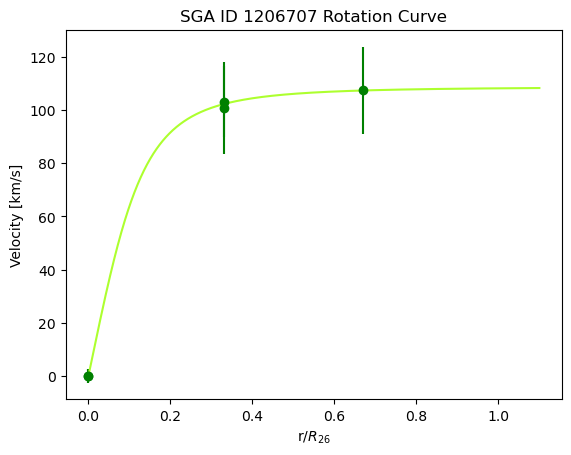

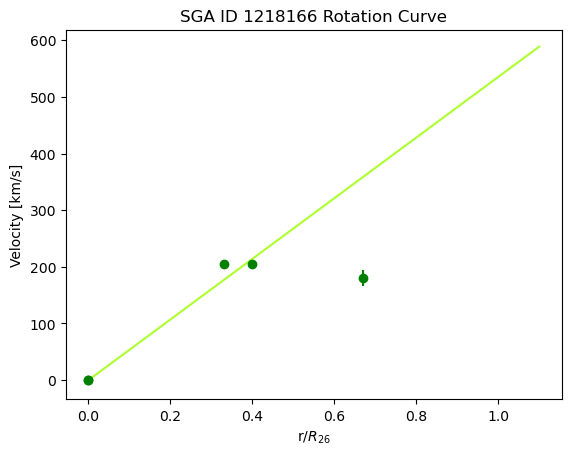

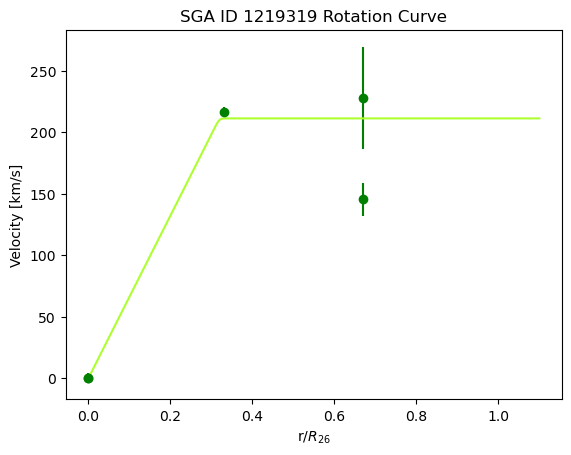

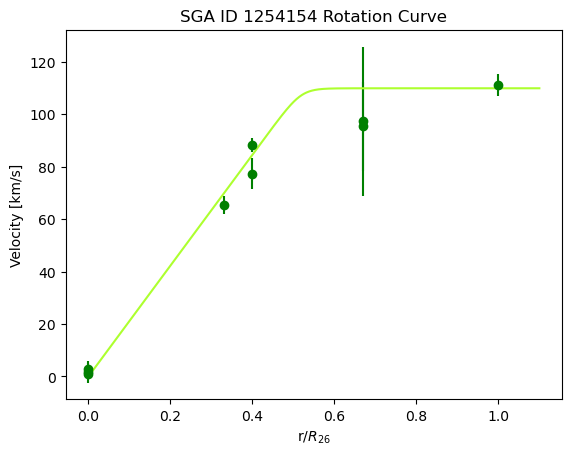

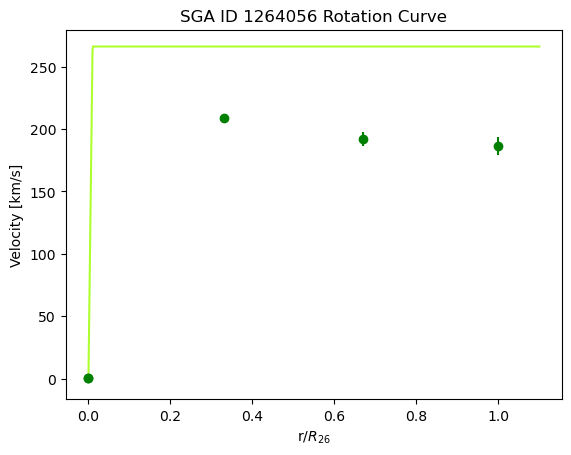

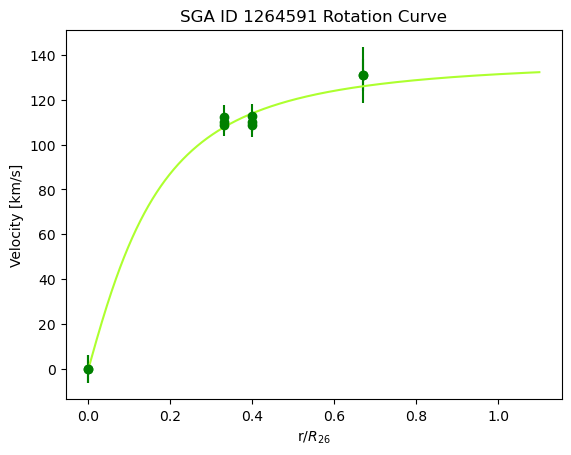

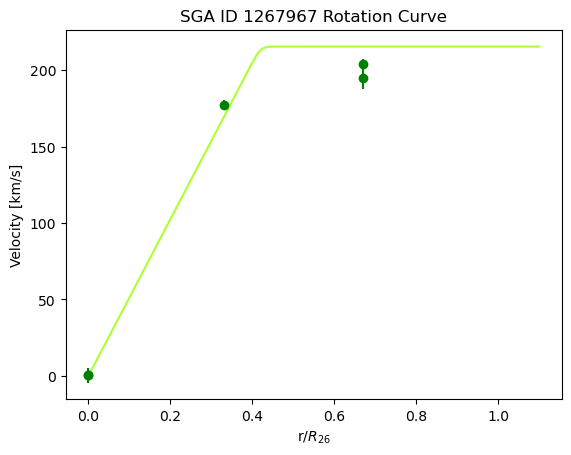

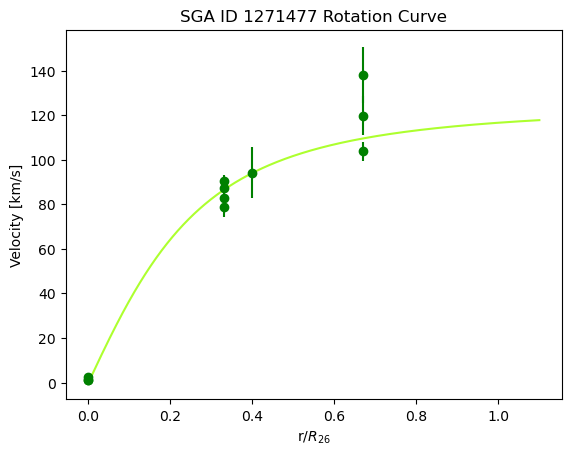

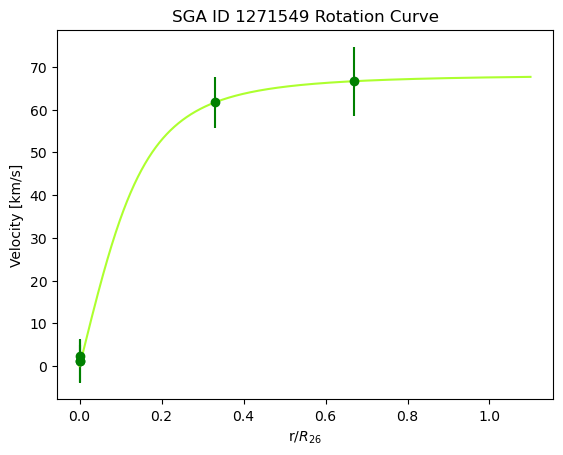

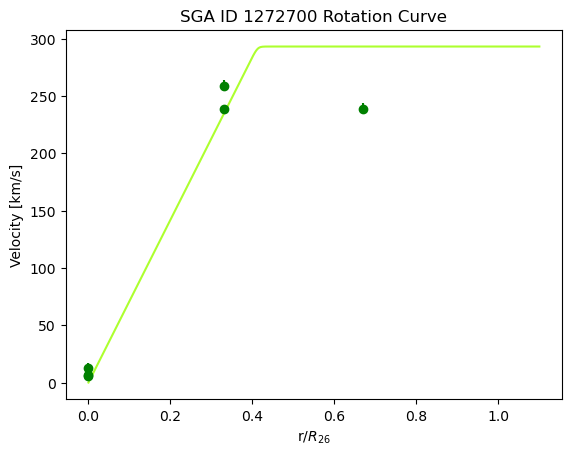

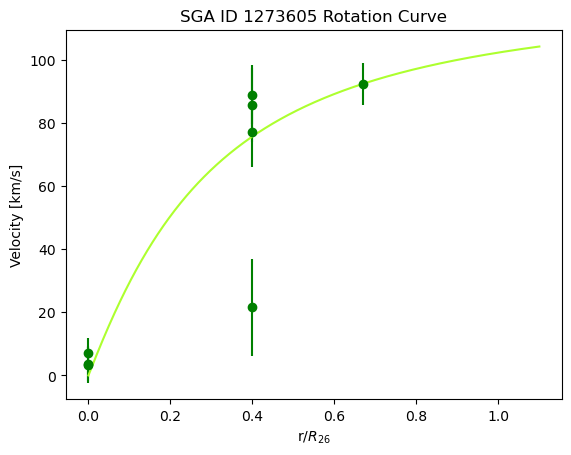

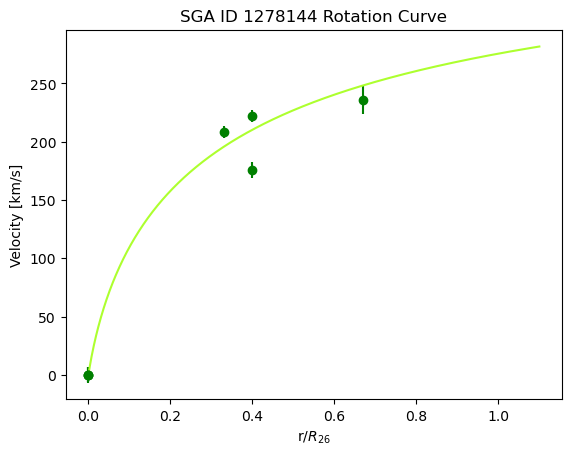

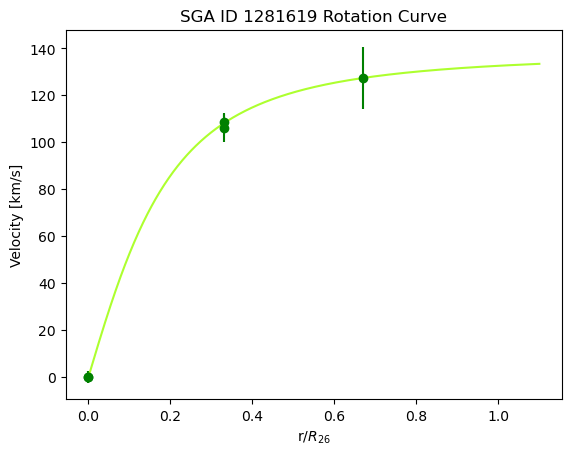

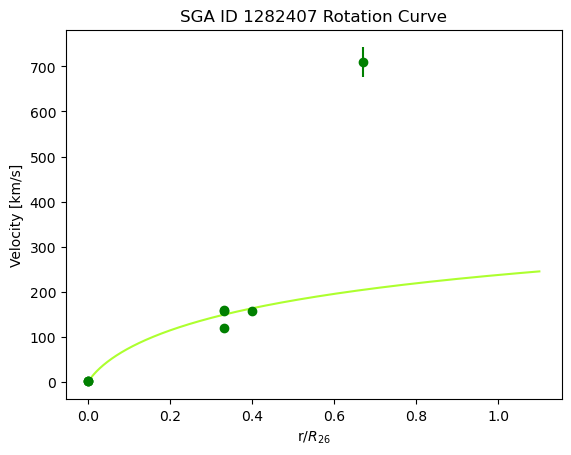

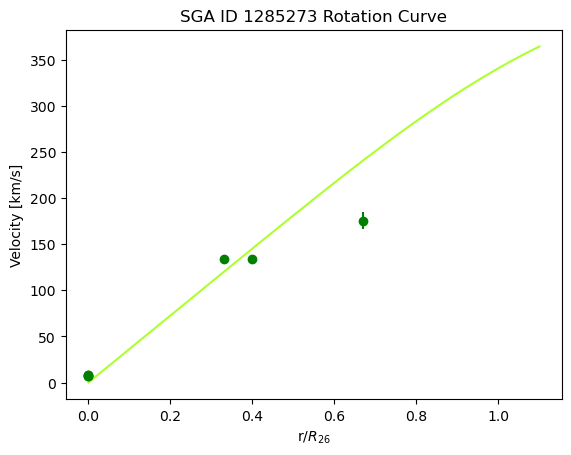

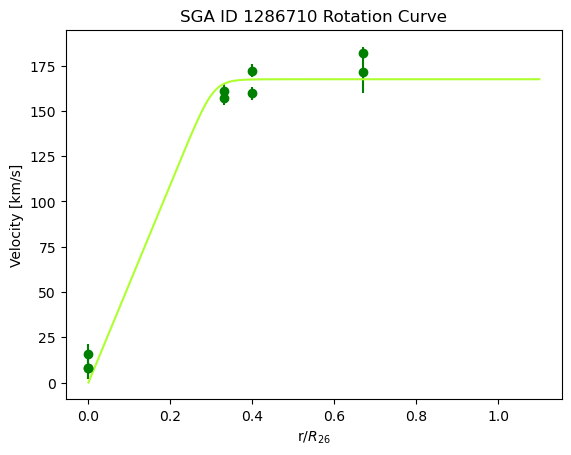

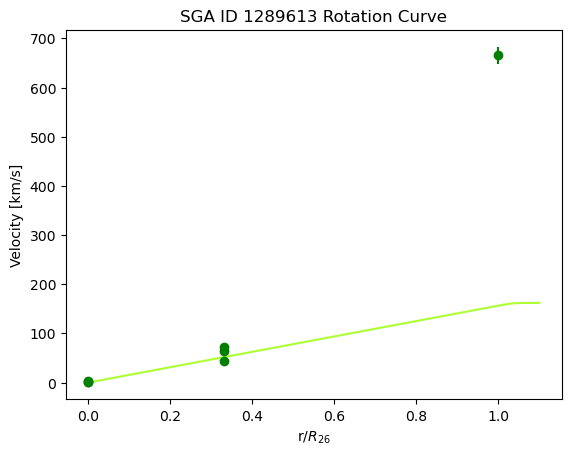

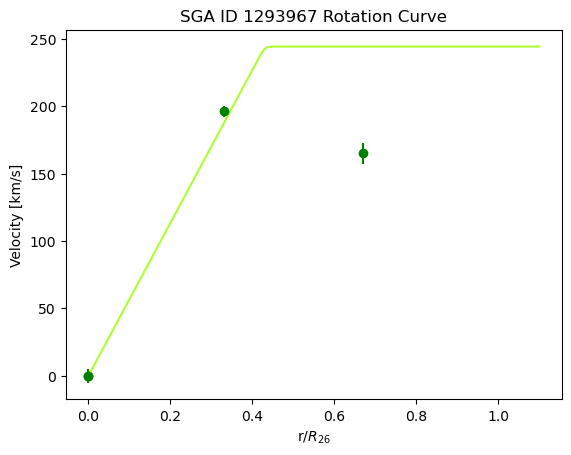

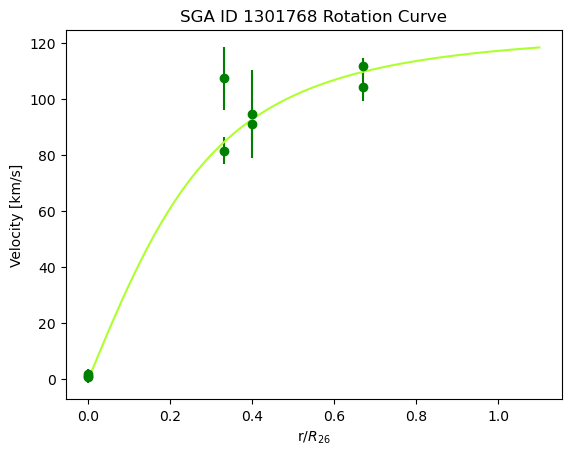

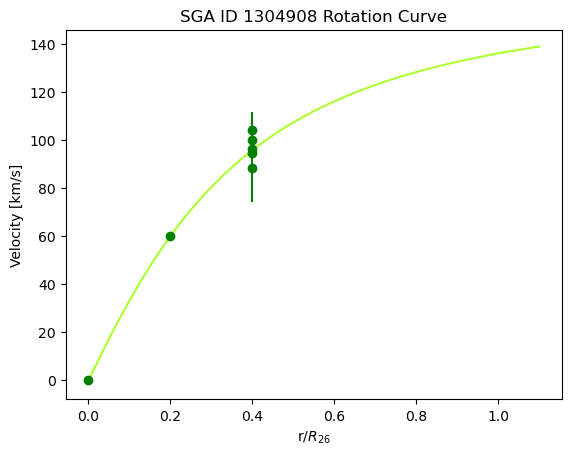

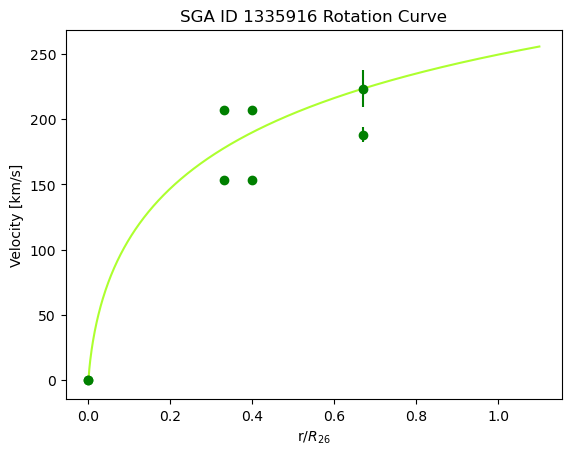

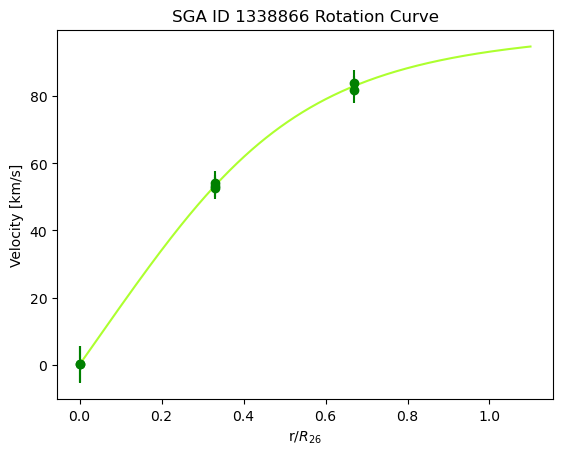

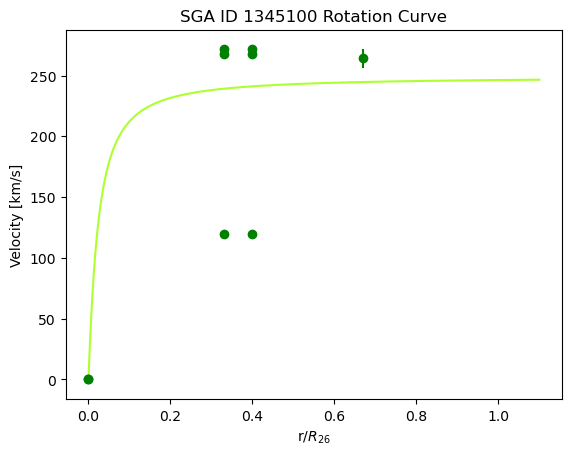

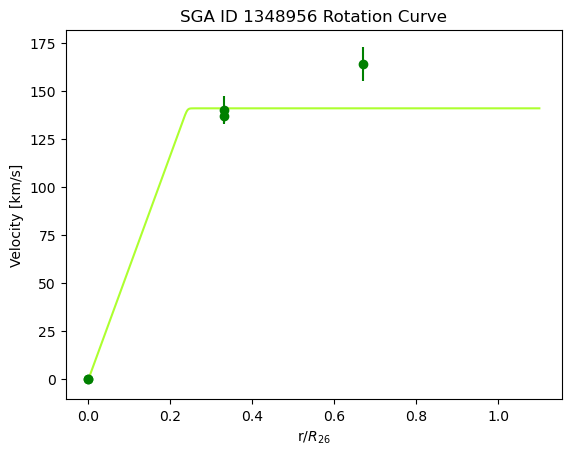

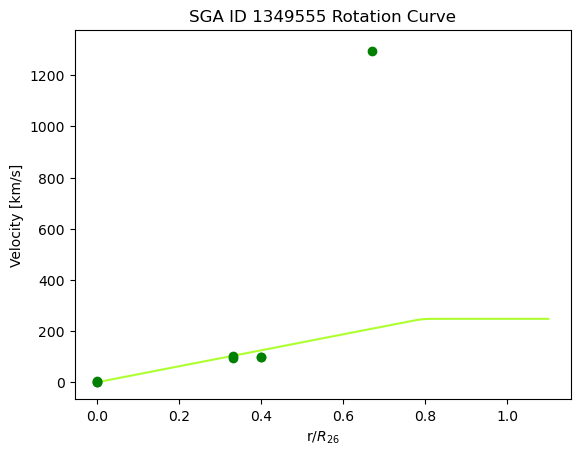

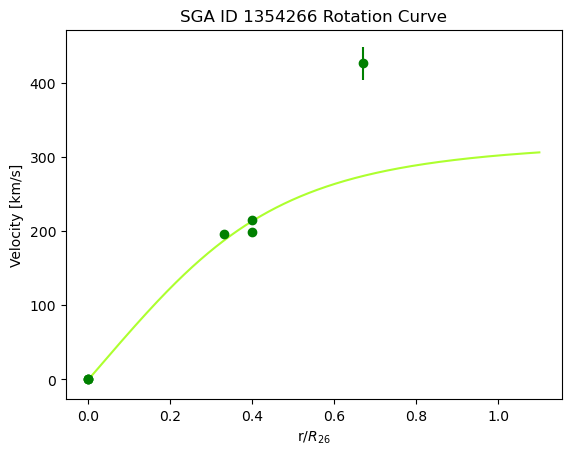

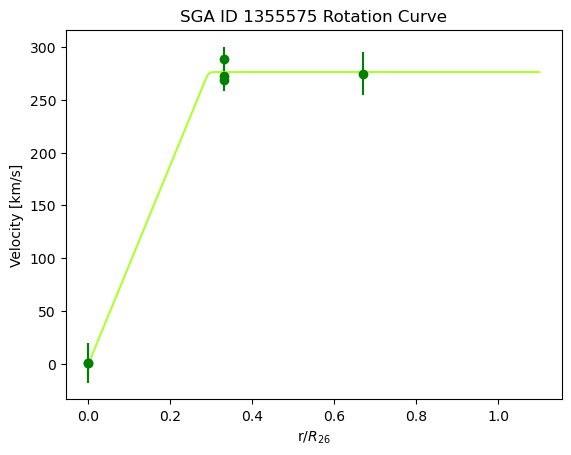

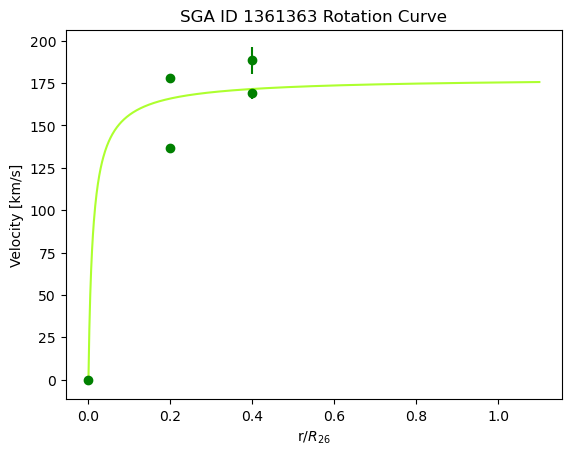

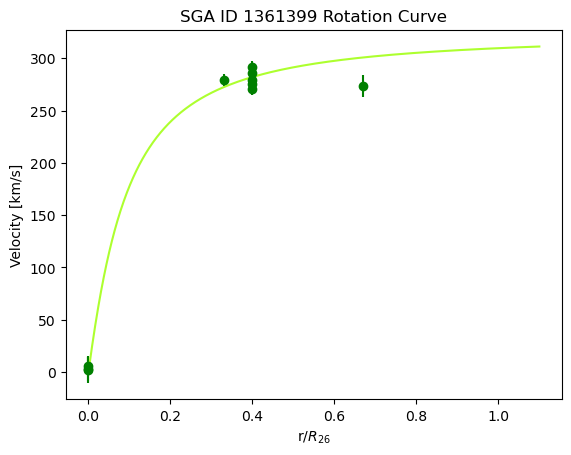

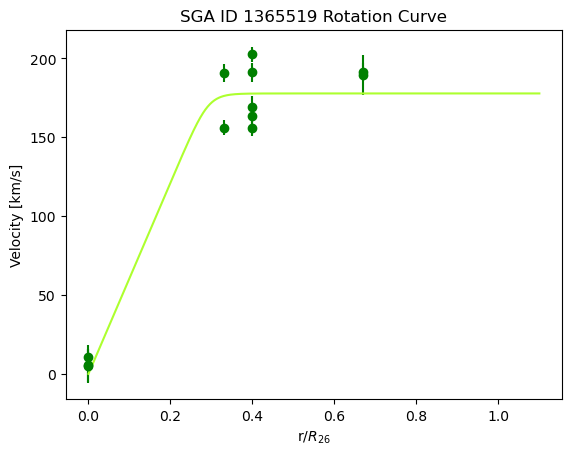

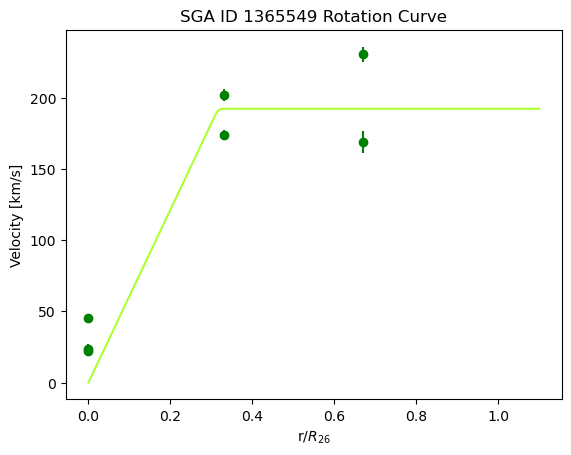

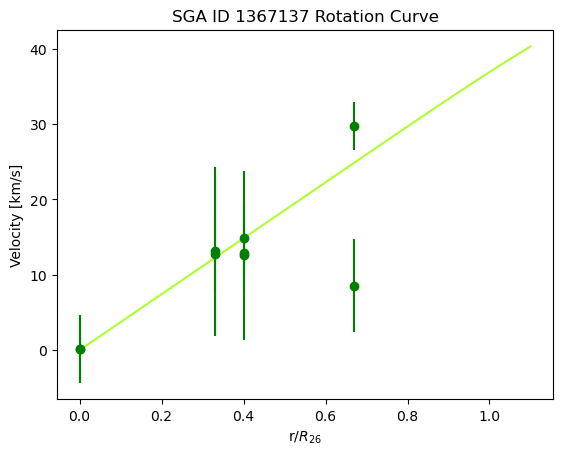

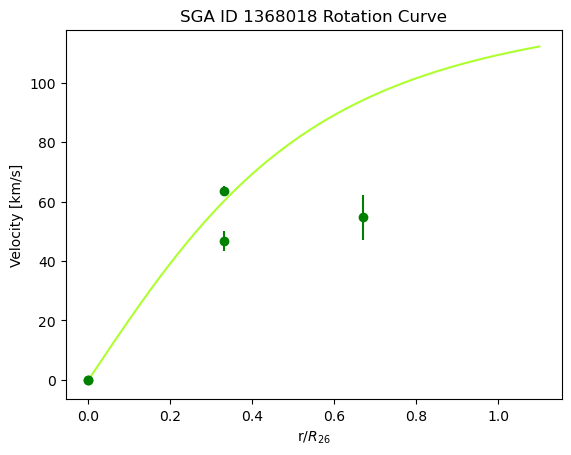

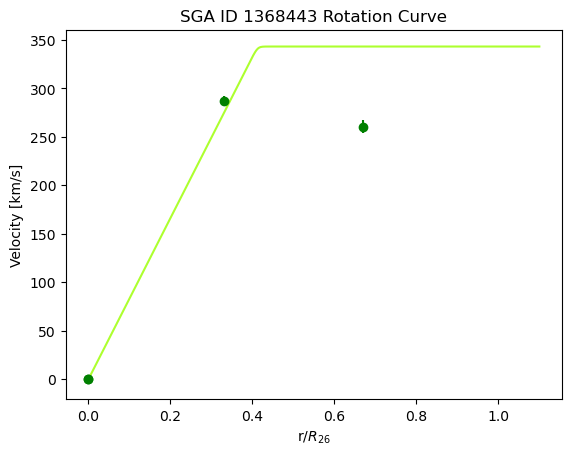

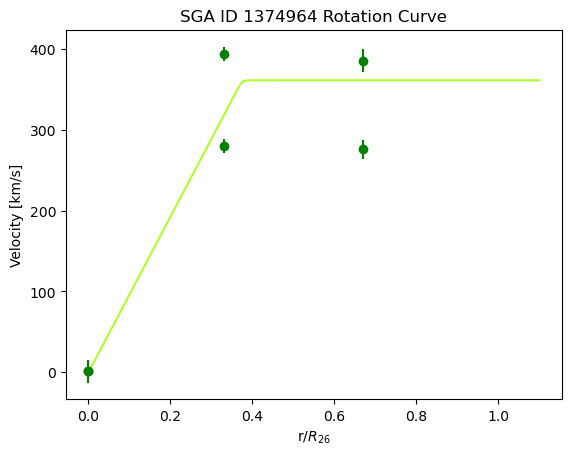

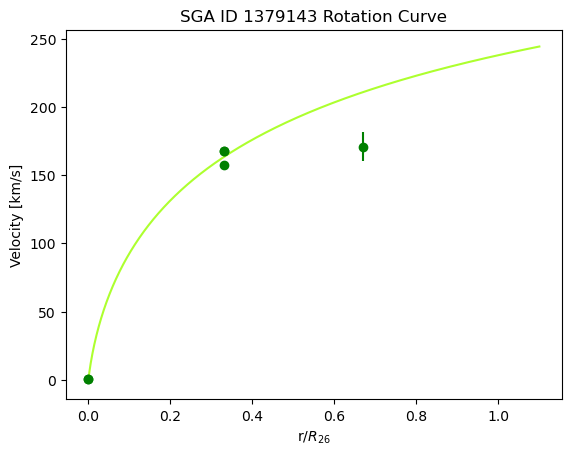

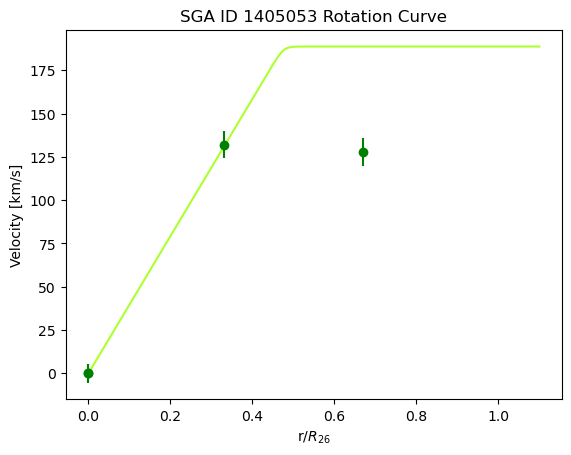

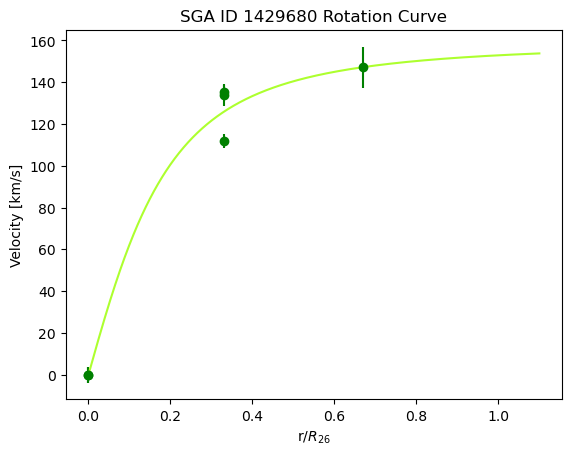

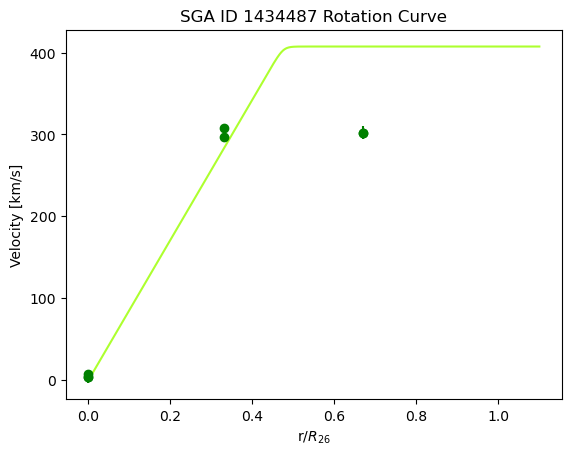

In [21]:
#loop through all plottables
for sga_id in sga_ids:
    sga_idx = SGA_dict[sga_id]
    axis_ratio = SGA['BA'][sga_idx]
    
    #calculate inclination and assign to table
    inc = inclination_angle(axis_ratio)
    tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = inc
    
    #velocty cut <= 1000 and define parameters
    v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VELOCITY'])
    verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['VERR']
    r = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)]['SKY_FIBER_DIST_R26']
    
    #calculate rotational velocity and error adjusted for inclination
    vrot = v / (np.sin(inc))
    vrot_err = verr / (np.sin(inc))
    
    #initial guesses and bounds
    alpha_guess = 2
    alpha_low = 0.001
    alpha_high = 100
    v_max_guess = 500
    v_max_low = 10
    v_max_high = 5100
    r_turn_guess = 0.5
    r_turn_low = 0.01
    r_turn_high = 30
    
    #put guesses and bounds into array / tuples to pass into functions
    guess = [v_max_guess, r_turn_guess, alpha_guess]
    bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]
    
    #define result
    result = minimize(chi_2, guess, method = 'Powell', args=(vrot, vrot_err, r), bounds=bounds)
    
    #plot only if result succeeds
    if result.success:
        tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[0]
        tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[1]
        tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.x[2]
        #chi_normal = result.fun/(len(v)-3)
        tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, np.abs(tf_mastertable['VELOCITY']) <= 1000)] = result.fun
    
        #create and index linear space
        rs = np.linspace(0, 1.1, 1000)
        vs = v_rot(rs, result.x[0], result.x[1], result.x[2])
    
        plt.errorbar(r, vrot, yerr=vrot_err, linestyle='none', marker='o', color='g')
        plt.plot(rs, vs, color='greenyellow')
        plt.xlabel(r"r/$R_{26}$")
        plt.ylabel("Velocity [km/s]")
        plt.title("SGA ID "+str(sga_id)+ " Rotation Curve")

        img_name = v_dir + '{}.jpg'.format(sga_id)
        plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
        plt.show()
        plt.close()

In [61]:
sga_id = 9769
sga_idx = SGA_dict[sga_id]
axis_ratio = SGA['BA'][sga_idx]
inc = inclination_angle(axis_ratio)
tf_mastertable['INCLINATION'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)] = inc

In [38]:
v = np.abs(tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)]['VELOCITY'])
verr = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)]['VERR']
r = tf_mastertable[np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)]['SKY_FIBER_DIST_R26']
vrot = v / (np.sin(inc))
vrot_err = verr / (np.sin(inc))

In [39]:
#initial guesses and bounds
alpha_guess = 2
alpha_low = 0.001
alpha_high = 100
v_max_guess = 500
v_max_low = 10
v_max_high = 5100
r_turn_guess = 0.5
r_turn_low = 0.01
r_turn_high = 30
#lists
guess = [v_max_guess, r_turn_guess, alpha_guess]
bounds = [(v_max_low, v_max_high), (r_turn_low, r_turn_high), (alpha_low, alpha_high)]

In [76]:
result = minimize(chi_2, guess,
                  method = 'Powell', 
                  args=(v, verr, r), bounds=bounds)
if result.success:
    tf_mastertable['VMAX'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)] = result.x[0]
    tf_mastertable['RTURN'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)] = result.x[1]
    tf_mastertable['ALPHA'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)] = result.x[2]
    #chi_normal = result.fun/(len(v)-3)
    tf_mastertable['ROTCURVE_CHI2'][np.logical_and(tf_mastertable['SGA_ID']==sga_id, tf_mastertable['VELOCITY'] <= 1000)] = result.fun

In [46]:
rs = np.linspace(0, 1.1, 1000)
vs = v_rot(rs, result.x[0], result.x[1], result.x[2])

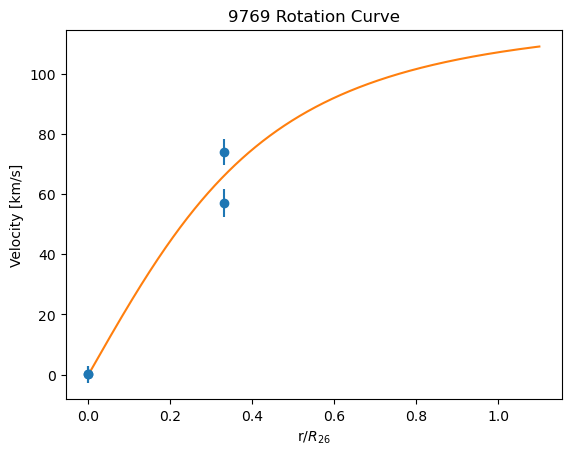

In [77]:
plt.errorbar(r, v, yerr=verr, linestyle='none', marker='o')
plt.plot(rs, vs)
plt.xlabel(r"r/$R_{26}$")
plt.ylabel("Velocity [km/s]")
plt.title(str(sga_id)+ " Rotation Curve")

img_name = v_dir + '{}.jpg'.format(sga_id)
plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
plt.show()

In [78]:
tf_mastertable[tf_mastertable['SGA_ID']==sga_id]

<Table length=19>
     TARGETID        TARGET_RA     ... ALPHA_ERR    INCLINATION   
      int64           float64      ...  float64       float64     
----------------- ---------------- ... --------- -----------------
 1071051324784642  235.85328413992 ...       nan 0.986102593691706
 1084245464317954  235.85328413992 ...       nan 0.986102593691706
 1071051324784641 235.851693978453 ...       nan 0.986102593691706
 1084245464317953 235.851693978453 ...       nan 0.986102593691706
 1071051324784640 235.850150584191 ...       nan               nan
 1084245464317952 235.850150584191 ...       nan               nan
 1071051324784643 235.856370917228 ...       nan 0.986102593691706
 1084245464317955 235.856370917228 ...       nan 0.986102593691706
 1071051324784644 235.857961071773 ...       nan 0.986102593691706
 1084245464317956 235.857961071773 ...       nan 0.986102593691706
 1071051324784645 235.859504454814 ...       nan               nan
 1084245464317957 235.859504454814 ...       nan               nan
39633123134144866 235.854827529683 ...       nan 0.986102593691706
 1071051324784642  235.85328413992 ...       nan 0.986102593691706
 1084245464317954  235.85328413992 ...       nan 0.986102593691706
39633123134144866 235.854827529683 ...       nan 0.986102593691706
39633123134144866 235.854827529683 ...       nan 0.986102593691706
 1071051324784643 235.856370917228 ...       nan 0.986102593691706
 1084245464317955 235.856370917228 ...       nan 0.986102593691706

In [75]:
print(len(v))

4
